### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary


In [1]:
# to selectively re-import as needed
# import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']


In [2]:
from datetime import datetime, timedelta
import os
import yaml
import sqlite3
import json
from collections import Counter
import uuid
from typing import TypedDict, Annotated
import subprocess
import requests

import operator
import pickle

import langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

from langchain_core.output_parsers import SimpleJsonOutputParser, JsonOutputParser, StrOutputParser

from langgraph.graph import StateGraph, START, END

import numpy as np
import pandas as pd
import umap

import sklearn
from sklearn.cluster import DBSCAN

import bs4
from urllib.parse import urljoin, urlparse

import multiprocessing
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

import openai
from openai import OpenAI

import trafilatura

VERBOSE=1
from ainb_const import (DOWNLOAD_DIR, PAGES_DIR,
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, CANONICAL_TOPICS,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT, TOP_CATEGORIES_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE, SQLITE_DB,
                        HOSTNAME_SKIPLIST, SITE_NAME_SKIPLIST,
                       )
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article,
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            unicode_to_ascii, send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file,
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory,
                            process_url_queue_factory, get_google_news_redirects)
from ainb_llm import (paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries,
                      fetch_openai_summary, count_tokens, trunc_tokens, 
                      categorize_headline, categorize_df, clean_topics,
                      get_site_name, fetch_missing_site_names)


import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()


In [3]:
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")


LangChain         0.3.0
OpenAI            1.47.0
trafilatura       1.12.2
numpy             1.26.4
pandas            2.2.3
sklearn           1.5.2
umap              0.5.6


In [4]:
# a basic LLM call with langchain
model = ChatOpenAI(model=MODEL)

model.invoke([
    SystemMessage(content="Translate the following from English into Italian"),
    HumanMessage(content='Listen to me. You are beautiful. You are perfect and I love you.'),
])


2024-10-08 16:14:49,566 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content='Ascoltami. Sei bellissima. Sei perfetta e ti amo.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 34, 'total_tokens': 50, 'completion_tokens_details': {'reasoning_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0}}, 'model_name': 'chatgpt-4o-latest', 'system_fingerprint': 'fp_61e551c4c2', 'finish_reason': 'stop', 'logprobs': None}, id='run-4b0751ac-9a25-4532-b597-7b9e0e4ee58e-0', usage_metadata={'input_tokens': 34, 'output_tokens': 16, 'total_tokens': 50})

In [5]:
# use template
system_template = "Translate the following into {language}:"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)
parser = StrOutputParser()
chain = prompt_template | model | parser
chain.invoke({"language": "italian", "text": "hi"})


2024-10-08 16:14:50,102 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Ciao'

In [6]:
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

system_template = 'Translate the following into {language}:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    response = ""
    # stream tokens as they are generated
    for r in chain.stream(tpl):
        print(r, end="")
        response += r
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")


2024-10-08 16:14:50,501 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Écoute-moi. Tu es parfaite. Tu es belle et je t'aime.

2024-10-08 16:14:51,430 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.

2024-10-08 16:14:52,461 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Escúchame. Eres perfecta. Eres hermosa y te amo.

2024-10-08 16:14:53,069 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ascoltami. Sei incredibile. Sei magnifica e ti amo.

2024-10-08 16:14:53,772 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Figyelj rám. Elbűvölő vagy. Lenyűgöző vagy, és szeretlek.

Elapsed seconds: 3.922654


In [7]:
# same but send all at once using asyncio

async def async_langchain(chain, input_dict):
    response = await chain.ainvoke(input_dict)
    return response


prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    task = asyncio.create_task(async_langchain(chain, d))
    tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()


difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")
print("\n".join(responses))


2024-10-08 16:14:54,674 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-08 16:14:54,694 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-08 16:14:54,751 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-08 16:14:54,969 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-08 16:14:55,344 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Elapsed seconds: 1.299669
Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.
Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.
Escúchame. Eres perfecto/a. Eres hermoso/a y te amo.
Ascoltami. Sei fantastico. Sei magnifico e ti amo.
Figyelj rám. Elbűvölő vagy. Lenyűgöző vagy, és szeretlek.


In [8]:
# class to maintain state within graph

class AgentState(TypedDict):
    AIdf: dict                #  the current working set of headlines (pandas dataframe not supported)
    before_date: str          #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool         #  if False use existing files, else download from sources
    sources: dict             #  sources to scrap
    sources_reverse: dict     #  map file names to sources
    bullets: str              #  bullet point summary email
    summary: str              #  final summary
    n_edits: int              #  count edit iterations so we don't keep editing forever
    edit_complete: bool       #  edit will update if no more edits to make
    # message thread with OpenAI
    messages: Annotated[list[AnyMessage], operator.add]


In [29]:
DEBUG = True
N_BROWSERS = 4
before_date = None
do_download = True
# before_date="2024-10-07 13:00:00"


In [30]:
test_state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'n_edits': 0,
    'edit_complete': False,
    'messages': None}
)


In [31]:
# Initialize reading configurations from YAML file

def fn_initialize(state: AgentState) -> AgentState:
    """
    Initializes the agent state by loading source configurations from SOURCECONFIG (sources.yaml) .

    Args:
        state (AgentState): The current state of the agent.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        AgentState: The updated state of the agent.

    Raises:
        yaml.YAMLError: If there is an error while loading the YAML file.

    """

    #  load sources to scrape from sources.yaml
    with open(SOURCECONFIG, "r") as stream:
        try:
            state['sources'] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

    log(f"Initialized {len(state['sources'])} items in sources from {SOURCECONFIG}")

    # make a reverse dict to map file titles to source names
    state['sources_reverse'] = {}
    for k, v in state['sources'].items():
        log(f"{k} -> {v['url']} -> {v['title']}.html")
        v['sourcename'] = k
        # map filename (title) to source name
        state['sources_reverse'][v['title']] = k

    log(f"Initialized {len(state['sources_reverse'])} items in sources_reverse")

    return state


if DEBUG:
    test_state = fn_initialize(test_state)


2024-10-08 16:16:09,395 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2024-10-08 16:16:09,396 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-10-08 16:16:09,397 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-10-08 16:16:09,397 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-10-08 16:16:09,398 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-10-08 16:16:09,398 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-10-08 16:16:09,399 - AInewsbot - INFO - 

In [32]:
# scrape sources with selenium and save local files in DOWNLOAD_DIR (htmldata)
def fn_download_sources(state: AgentState) -> AgentState:
    """
    Scrapes sources and saves HTML files.
    If state["do_download"] is True, deletes all files in DOWNLOAD_DIR (htmldata) and scrapes fresh copies.
    If state["do_download"] is False, uses existing files in DOWNLOAD_DIR.
    Uses state["sources"] for config info on sources to scrape
    For each source, saves the current filename to state["sources"][sourcename]['latest']

    Args:
        state (AgentState): The current state of the agent.
        do_delete (bool, optional): Whether to delete files in DOWNLOAD_DIR. Defaults to True.

    Returns:
        AgentState: The updated state of the agent.
    """

    if state["do_download"]:
        # empty download directory
        delete_files(DOWNLOAD_DIR)

        # save each file specified from sources
        log(f"Saving HTML files using {N_BROWSERS} browsers")

        # Create a queue for multiprocessing and populate it
        queue = multiprocessing.Queue()
        for item in state["sources"].values():
            queue.put(item)

        # Function to take the queue and pop entries off and process until none are left
        # lets you create an array of functions with different args
        callable = process_source_queue_factory(queue)

        saved_pages = launch_drivers(N_BROWSERS, callable)
        for sourcename, file in saved_pages:
            log(f"Downloaded {sourcename} to {file}")
            state['sources'][sourcename]['latest'] = file
        log(f"Saved {len(saved_pages)} HTML files")

    else:   # use existing files
        log(f"Web fetch disabled, using existing files in {DOWNLOAD_DIR}")
        # Get the current date
        datestr = datetime.now().strftime("%m_%d_%Y")
        files = [os.path.join(DOWNLOAD_DIR, file)
                 for file in os.listdir(DOWNLOAD_DIR)]
        # filter files with today's date ending in .html
        files = [
            file for file in files if datestr in file and file.endswith(".html")]
        log(f"Found {len(files)} previously downloaded files")
        for file in files:
            log(file)

        saved_pages = []
        for file in files:
            filename = os.path.basename(file)
            # locate date like '01_14_2024' in filename
            position = filename.find(" (" + datestr)
            basename = filename[:position]
            # match to source name
            sourcename = state["sources_reverse"].get(basename)
            if sourcename is None:
                log(f"Skipping {basename}, no sourcename metadata")
                continue
            state["sources"][sourcename]['latest'] = file

    return state

if DEBUG:
    test_state = fn_download_sources(test_state)


2024-10-08 16:16:13,330 - AInewsbot - INFO - Saving HTML files using 4 browsers
2024-10-08 16:16:13,366 - AInewsbot - INFO - get_driver - 30661 Initializing webdriver
2024-10-08 16:16:13,368 - AInewsbot - INFO - get_driver - 30661 Initializing webdriver
2024-10-08 16:16:13,368 - AInewsbot - INFO - get_driver - 30661 Initializing webdriver
2024-10-08 16:16:13,369 - AInewsbot - INFO - get_driver - 30661 Initializing webdriver
2024-10-08 16:16:30,509 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-08 16:16:30,509 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-08 16:16:30,509 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-08 16:16:30,509 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-08 16:16:30,510 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-08 16:16:30,511 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-08 16:16:30,511 - AInewsbot - INFO -

2024-10-08 16:18:08,741 - AInewsbot - INFO - Processing NYT Tech
2024-10-08 16:18:08,742 - AInewsbot - INFO - get_files(New York Times Technology) - starting get_files https://www.nytimes.com/section/technology
2024-10-08 16:18:12,945 - AInewsbot - INFO - get_files(Feedly AI) - Loading additional infinite scroll items
2024-10-08 16:18:14,764 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

2024-10-08 16:18:14,765 - AInewsbot - INFO - get_files(Ars Technica) - Saving Ars Technica (10_08_2024 04_18_14 PM).ht

2024-10-08 16:18:54,263 - AInewsbot - INFO - get_files(Washington Post Technology) - Saving Washington Post Technology (10_08_2024 04_18_54 PM).html as utf-8
2024-10-08 16:18:54,266 - AInewsbot - INFO - Quit webdriver
2024-10-08 16:19:03,001 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

2024-10-08 16:19:03,002 - AInewsbot - INFO - get_files(Feedly AI) - Saving Feedly AI (10_08_2024 04_19_03 PM).html as utf-8
2024-10-08 16:19:03,003 - AInewsbot - INFO - Quit webdriver
2024-10-08 16:19:04,875 - AInewsbot 

In [33]:
def fn_extract_urls(state: AgentState) -> AgentState:
    """
    Extracts news URLs from the latest HTML files matching the patterns defined in the state['sources'] configuration info.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted URLs stored in state['AIdf'].
    """
    # Parse news URLs and titles from downloaded HTML files
    log("Parsing html files")
    all_urls = []
    for sourcename, sourcedict in state['sources'].items():
        filename = sourcedict.get('latest')
        if not filename:
            log(f"no filename found for {sourcename}")
            continue

        log(sourcename + ' -> ' + filename)
        links = parse_file(state['sources'][sourcename])
        log(f"{len(links)} links found")
        all_urls.extend(links)

    log(f"Saved {len(all_urls)} links")

    # make a pandas dataframe of all the links found
    AIdf = (
        pd.DataFrame(all_urls)
        .groupby("url")
        .first()
        .reset_index()
        .sort_values("src")[["src", "title", "url"]]
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={"index": "id"})
    )
    state['AIdf'] = AIdf.to_dict()

    return state


if DEBUG:
    test_state = fn_extract_urls(test_state)

    # s/b 17 but if some like bloomberg" or wsj are missing, maybe got a robot block
    # if so, download missing ones manually and then re-run fn_extract_urls
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])


2024-10-08 16:19:04,895 - AInewsbot - INFO - Parsing html files
2024-10-08 16:19:04,897 - AInewsbot - INFO - Ars Technica -> htmldata/Ars Technica (10_08_2024 04_18_14 PM).html
2024-10-08 16:19:04,961 - AInewsbot - INFO - parse_file - found 171 raw links
2024-10-08 16:19:04,967 - AInewsbot - INFO - parse_file - found 25 filtered links
2024-10-08 16:19:04,967 - AInewsbot - INFO - 25 links found
2024-10-08 16:19:04,967 - AInewsbot - INFO - Bloomberg Tech -> htmldata/Bloomberg Technology (10_08_2024 04_17_48 PM).html
2024-10-08 16:19:04,988 - AInewsbot - INFO - parse_file - found 198 raw links
2024-10-08 16:19:04,991 - AInewsbot - INFO - parse_file - found 14 filtered links
2024-10-08 16:19:04,991 - AInewsbot - INFO - 14 links found
2024-10-08 16:19:04,992 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider Tech (10_08_2024 04_17_42 PM).html
2024-10-08 16:19:05,018 - AInewsbot - INFO - parse_file - found 311 raw links
2024-10-08 16:19:05,022 - AInewsbot - INFO - parse_file 

17


,id
src,
Ars Technica,25
Bloomberg Tech,11
Business Insider,51
FT Tech,66
Feedly AI,63
Google News,67
Hacker News,27
Hacker News 2,22
HackerNoon,98


In [34]:
# get AI news via newscatcher

newscatcher_sources = ['247wallst.com',
 '9to5mac.com',
 'androidauthority.com',
 'androidcentral.com',
 'androidheadlines.com',
 'appleinsider.com',
 'benzinga.com',
 'borneobulletin.com.bn',
 'cnet.com',
 'cnn.com',
 'digitaltrends.com',
 'engadget.com',
 'fastcompany.com',
 'finextra.com',
 'fintechnews.sg',
 'fonearena.com',
 'ft.com',
 'gadgets360.com',
 'geekwire.com',
 'gizchina.com',
 'gizmochina.com',
 'gizmodo.com',
 'gsmarena.com',
 'hackernoon.com',
 'howtogeek.com',
 'ibtimes.co.uk',
 'itwire.com',
 'lifehacker.com',
 'macrumors.com',
 'mashable.com',
#  'medium.com',
 'mobileworldlive.com',
 'msn.com',
 'nypost.com',
 'phonearena.com',
 'phys.org',
 'popsci.com',
 'scmp.com',
 'sify.com',
 'siliconangle.com',
 'siliconera.com',
 'siliconrepublic.com',
 'slashdot.org',
 'slashgear.com',
 'statnews.com',
 'tech.co',
 'techcrunch.com',
 'techdirt.com',
 'technode.com',
 'technologyreview.com',
 'techopedia.com',
 'techradar.com',
 'techraptor.net',
 'techtimes.com',
 'techxplore.com',
 'telecomtalk.info',
 'thecut.com',
 'thedrum.com',
 'thehill.com',
 'theregister.com',
 'theverge.com',
 'thurrott.com',
 'tipranks.com',
 'tweaktown.com',
 'videocardz.com',
 'washingtonpost.com',
 'wccftech.com',
 'wired.com',
 'xda-developers.com',
 'yahoo.com',
 'zdnet.com']

def fn_extract_newscatcher(state: AgentState) -> AgentState:

    base_url = "https://api.newscatcherapi.com/v2/search"
    time_24h_ago = datetime.now() - timedelta(hours=24)

    # Put API key in headers 
    headers = {'x-api-key': os.getenv('NEWSCATCHER_API_KEY')}

    # Define search parameters
    params = {
        'q': 'Artificial Intelligence',
        'lang': 'en',
        'sources': ','.join(newscatcher_sources),
        'from': time_24h_ago.strftime('%Y-%m-%d %H:%M:%S'),
        'to': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'page_size': 300,
        'page': 1
        }

    # Make API call with headers and params
    response = requests.get(base_url, headers=headers, params=params)

    # Encode received results
    results = json.loads(response.text.encode())
    if response.status_code != 200:
        print('ERROR: API call failed.')
        print(results)
        
    # merge into existing df
    newscatcher_df = pd.DataFrame(results['articles'])[['title', 'link']]
    newscatcher_df['src']='Newscatcher'
    newscatcher_df = newscatcher_df.rename(columns={'link': 'url'})
    
    AIdf = pd.DataFrame(test_state['AIdf'])
    max_id = AIdf['id'].max()
    # add id column to newscatcher_df
    newscatcher_df['id'] = range(max_id + 1, max_id + 1 + len(newscatcher_df))
    AIdf = pd.concat([AIdf, newscatcher_df], ignore_index=True)
    state['AIdf'] = AIdf.to_dict()
    return state
    

if DEBUG:
    test_state = fn_extract_newscatcher(test_state)
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    

18


,id
src,
Ars Technica,25
Bloomberg Tech,11
Business Insider,51
FT Tech,66
Feedly AI,63
Google News,67
Hacker News,27
Hacker News 2,22
HackerNoon,98


In [35]:
# sqlite schema to store previously processed 
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [36]:
# filter and clean URLs for new AI stories

def fn_filter_urls(state: AgentState) -> AgentState:
    """
    Filters the URLs in state["AIdf"] to include only those that have not been previously seen,
    and are related to AI according to the response from a ChatGPT prompt.

    Args:
        state (AgentState): The current state of the agent.
        before_date (str, optional): The date before which the URLs should be filtered. Defaults to "".

    Returns:


        AgentState: The updated state of the agent with the filtered URLs stored in state["AIdf"].

    """
    # filter to URL not previously seen
    AIdf = pd.DataFrame(state["AIdf"])

    AIdf = filter_unseen_urls_db(AIdf, before_date=state["before_date"])

    if len(AIdf) == 0:
        log("No new URLs, returning")
        return state

    # dedupe identical headlines
    # filter similar titles differing by type of quote or something
    AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)
    AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
    AIdf = AIdf.sort_values("src") \
        .groupby("title_clean") \
        .first() \
        .reset_index(drop=True) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})
    log(f"Found {len(AIdf)} unique new headlines")

    # structured response format
    json_schema = {
        "name": "json_schema",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "isai_array": {
                    "type": "array",
                    "items": {
                        "type": "object",
                                "properties": {
                                    "id": {
                                        "type": "number"
                                    },
                                    "isAI": {
                                        "type": "boolean"
                                    }
                                },
                        "required": ["id", "isAI"],
                        "additionalProperties": False
                    }
                }
            },
            "required": ["isai_array"],
            "additionalProperties": False
        }
    }

    # filter AI-related headlines using a prompt
    pages = paginate_df(AIdf)
    enriched_urls = asyncio.run(fetch_pages(pages, prompt=FILTER_PROMPT, json_schema=json_schema))
    filter_df = pd.DataFrame(enriched_urls)
    
    try:  # for idempotency
        AIdf = AIdf.drop(columns=['isAI'])
    except:
        pass

    # merge returned df with isAI column into original df on id column
    AIdf = pd.merge(AIdf, filter_df, on="id", how="outer")
    log(AIdf.columns)
    # set hostname based on actualurl
    AIdf['actual_url'] = AIdf['url']    # ideally resolve redirects but Google News blocks
    AIdf['hostname']=AIdf['actual_url'].apply(lambda url: urlparse(url).netloc)

    # update SQLite database with all seen URLs (we are doing this using url and ignoring redirects)
    log(f"Inserting {len(AIdf)} URLs into {SQLITE_DB}")
    conn = sqlite3.connect(SQLITE_DB)
    cursor = conn.cursor()
    for row in AIdf.itertuples():
        insert_article(conn, cursor, row.src, row.hostname, row.title,
                       row.url, row.actual_url, row.isAI, datetime.now().date())

    # keep headlines that are related to AI
    AIdf = AIdf.loc[AIdf["isAI"]==1] \
        .reset_index(drop=True)  \
        .reset_index()  \
        .drop(columns=["id"])  \
        .rename(columns={'index': 'id'})

    log(f"Found {len(AIdf)} AI headlines")

    # update actual URLs for Google News redirects
    # I think Google changed something so this no longer works, instead of a 301 redirct
    # get a javascript page that redirects. Also tomorrow we might see different URLs for same stories
    # AIdf = get_google_news_redirects(AIdf)

    conn = sqlite3.connect('articles.db')
    query = "select * from sites"
    sites_df = pd.read_sql_query(query, conn)
    sites_dict = {row.hostname:row.site_name for row in sites_df.itertuples()}
    conn.close()

    # get clean site_name
    AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))

    # if any missing clean site names, populate them using OpenAI
    missing_site_names =  len(AIdf.loc[AIdf['site_name']==""])
    if missing_site_names:
        log(f"Asking OpenAI for {missing_site_names} missing site names")
        responses = asyncio.run(fetch_missing_site_names(AIdf))
        # update site_dict from responses
        new_urls = []
        for r in responses:
            if r['url'].startswith('https://'):
                r['url'] = r['url'][8:]
            new_urls.append(r['url'])
            sites_dict[r['url']] = r['site_name']
            log(f"Looked up {r['url']} -> {r['site_name']}")
        # update sites table with new names
        for url in new_urls:
            sqlstr = "INSERT OR IGNORE INTO sites (hostname, site_name) VALUES (?, ?);"
            log(f"Updated {url} -> {sites_dict[url]}")
            conn.execute(sqlstr, (url, sites_dict[url]))
            conn.commit()
        # reapply to AIdf with updated sites
        AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))
    else:
        log("No missing site names")
  
    # drop banned slop sites

    AIdf = AIdf.loc[~AIdf["hostname"].str.lower().isin(HOSTNAME_SKIPLIST)]
    AIdf = AIdf.loc[~AIdf["site_name"].str.lower().isin(SITE_NAME_SKIPLIST)]
    
    state["AIdf"] = AIdf.to_dict()
    return state


if DEBUG:
    test_state = fn_filter_urls(test_state)
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    display(list(pd.DataFrame(test_state["AIdf"]).columns))



2024-10-08 16:19:46,777 - AInewsbot - INFO - Querying SQLite with where_clause: 
2024-10-08 16:19:47,393 - AInewsbot - INFO - URLs in orig_df: 1328
2024-10-08 16:19:47,395 - AInewsbot - INFO - Existing URLs in DB: 158176
2024-10-08 16:19:47,428 - AInewsbot - INFO - New URLs in df filtered by URL: 500
2024-10-08 16:19:47,516 - AInewsbot - INFO - Existing src+title: 59
2024-10-08 16:19:47,517 - AInewsbot - INFO - New URLs in df filtered by src+title: 441
2024-10-08 16:19:47,528 - AInewsbot - INFO - Found 421 unique new headlines
2024-10-08 16:19:47,789 - AInewsbot - INFO - Applying prompt to 9 pages using gpt-4o-mini
2024-10-08 16:19:47,790 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:19:47,791 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:19:47,792 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:19:47,792 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:19:47,792 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:19:47,793 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:19:

,id
src,
Ars Technica,1
Bloomberg Tech,2
Business Insider,2
Feedly AI,40
Google News,21
Hacker News,2
Hacker News 2,1
HackerNoon,2
NYT Tech,1


['id', 'src', 'title', 'url', 'isAI', 'actual_url', 'hostname', 'site_name']

In [37]:
# Function for topic extraction

def clean_topics(row, lcategories):
    """
    Cleans the extracted_topics and assigned_topics by removing certain common topics and combining them into a single list.

    Args:
        row (pandas.Series): The row containing the extracted_topics and assigned_topics.
        lcategories (set): The set of lowercase categories.

    Returns:
        list: The cleaned and combined list of topics.
    """
    extracted_topics = [x.title() for x in row.extracted_topics if x.lower() not in {"technology", "ai", "artificial intelligence"}]
    assigned_topics = [x.title() for x in row.assigned_topics if x.lower() in lcategories]
    combined = sorted(list(set(extracted_topics + assigned_topics)))
    combined = [s.replace("Ai", "AI") for s in combined]
    combined = [s.replace("Genai", "Gen AI") for s in combined]
    combined = [s.replace("Openai", "OpenAI") for s in combined]

    return combined


async def do_cat(AIdf, categories):
    """
    Sends a prompt to ChatGPT to select topics for the title for each row in AIdf
    which match the topics in categories.

    Args:
        AIdf (pandas.DataFrame): The DataFrame containing the headlines.
        categories (list): The list of topics to match with the headlines.

    Returns:
        dict: A dictionary where the keys are the row IDs and the values are lists
        of selected topics for each headline.

    """

    catdict = {}
    async with aiohttp.ClientSession() as session:
        for i, row in enumerate(AIdf.itertuples()):
            tasks = []
            log(f"Categorizing headline {row.id+1} of {len(AIdf)}")
            h = row.title
            log(h)
            for c in categories:
                task = asyncio.create_task(categorize_headline(h, c, session))
                tasks.append(task)
            responses = await asyncio.gather(*tasks)
            catdict[row.id] = [item for sublist in responses for item in sublist]
            log(str(catdict[row.id]))

    return catdict


def fn_topic_analysis(state: AgentState) -> AgentState:

    """
    Extracts and selects topics for each headline in the state['AIdf'] dataframe, scrubs them, and stores them back in the dataframe.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted and selected topics stored in state['AIdf'].
    """
    AIdf = pd.DataFrame(state["AIdf"])
    pages = paginate_df(AIdf)
    # apply topic extraction prompt to AI headlines
    log("start free-form topic extraction")
    json_schema = {
        "name": "extracted_topics",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "extracted_topics": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "id": {
                                "type": "number",
                            },
                            "topics": {
                                "type": "array",
                                "items": {
                                    "type": "string",
                                },
                            },
                        },
                        "required": ["id", "topics"],
                        "additionalProperties": False,
                    }
                }
            },
            "required": ["extracted_topics"],
            "additionalProperties": False,
        }
    }
    response = asyncio.run(fetch_pages(pages, prompt=TOPIC_PROMPT, json_schema=json_schema))
    topic_df = pd.DataFrame(response)
    topic_df = topic_df.rename(columns={'topics': 'extracted_topics'})
    log(f"{len(topic_df)} free-form topics extracted")
    all_topics = [item.lower() for row in topic_df.itertuples() for item in row.extracted_topics]
    item_counts = Counter(all_topics)
    filtered_topics = [item for item in item_counts if item_counts[item] >= 2 and item not in {'technology', 'ai', 'artificial intelligence'}]

    categories = sorted(CANONICAL_TOPICS)
    # use categories that are canonical or show up twice in freeform
    lcategories = set([c.lower() for c in categories] + [c.lower() for c in filtered_topics])
    # new topics
    log([c for c in filtered_topics if c not in categories])

    catdict = asyncio.run(categorize_headline(AIdf, categories=categories))
    topic_df['assigned_topics'] = topic_df['id'].apply(lambda id: catdict.get(id, ""))

    topic_df["topics"] = topic_df.apply(lambda t: clean_topics(t, lcategories), axis=1)
    topic_df["topic_str"] = topic_df.apply(lambda row: ", ".join(row.topics), axis=1)

    try: # for idempotency
        AIdf = AIdf.drop(columns=['topic_str', 'title_topic_str'])
    except:
        pass

    AIdf = pd.merge(AIdf, topic_df[["id", "topic_str"]], on="id", how="outer")
    AIdf['title_topic_str'] = AIdf.apply(lambda row: f'{row.title} (Topics: {row.topic_str})', axis=1)

    state["AIdf"] = AIdf.to_dict()
    return state

if DEBUG:
    test_state = fn_topic_analysis(test_state)


2024-10-08 16:20:02,466 - AInewsbot - INFO - start free-form topic extraction
2024-10-08 16:20:02,467 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-08 16:20:02,468 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:20:02,468 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:20:02,468 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:20:02,469 - AInewsbot - INFO - sent 20 items 
2024-10-08 16:20:08,319 - AInewsbot - INFO - got dict with 20 items 
2024-10-08 16:20:22,378 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:20:23,119 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:20:40,563 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:20:40,564 - AInewsbot - INFO - Processed 170 responses.
2024-10-08 16:20:40,566 - AInewsbot - INFO - 170 free-form topics extracted
2024-10-08 16:20:40,567 - AInewsbot - INFO - ['geoffrey hinton', 'nobel prize', 'physics', 'hopfield', 'hinton', 'machine learning', 'discoveries', 'wall street', 'privac

2024-10-08 16:21:47,630 - AInewsbot - INFO - got dict with 20 items 
2024-10-08 16:21:51,006 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:21:51,218 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:21:51,225 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:21:51,229 - AInewsbot - INFO - Processed 170 responses.
2024-10-08 16:21:51,231 - AInewsbot - INFO - Bubble, topic 10 of 100
2024-10-08 16:21:51,232 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-08 16:21:51,234 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:21:51,235 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:21:51,237 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:21:51,237 - AInewsbot - INFO - sent 20 items 
2024-10-08 16:21:54,150 - AInewsbot - INFO - got dict with 20 items 
2024-10-08 16:21:59,070 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:21:59,586 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:21:59,684 - AInewsbot - INFO - got

2024-10-08 16:23:17,571 - AInewsbot - INFO - sent 20 items 
2024-10-08 16:23:21,117 - AInewsbot - INFO - got dict with 20 items 
2024-10-08 16:23:23,045 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:23:23,049 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:23:23,754 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:23:23,756 - AInewsbot - INFO - Processed 170 responses.
2024-10-08 16:23:23,757 - AInewsbot - INFO - Deals, topic 21 of 100
2024-10-08 16:23:23,758 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-08 16:23:23,759 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:23:23,761 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:23:23,761 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:23:23,762 - AInewsbot - INFO - sent 20 items 
2024-10-08 16:23:26,673 - AInewsbot - INFO - got dict with 20 items 
2024-10-08 16:23:30,108 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:23:30,271 - AInewsbot - INFO - got dict with

2024-10-08 16:25:00,305 - AInewsbot - INFO - sent 20 items 
2024-10-08 16:25:03,942 - AInewsbot - INFO - got dict with 20 items 
2024-10-08 16:25:08,110 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:25:08,575 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:25:08,589 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:25:08,590 - AInewsbot - INFO - Processed 170 responses.
2024-10-08 16:25:08,591 - AInewsbot - INFO - Fashion, topic 32 of 100
2024-10-08 16:25:08,592 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-08 16:25:08,593 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:25:08,594 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:25:08,595 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:25:08,595 - AInewsbot - INFO - sent 20 items 
2024-10-08 16:25:11,796 - AInewsbot - INFO - got dict with 20 items 
2024-10-08 16:25:15,215 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:25:15,698 - AInewsbot - INFO - got dict wi

2024-10-08 16:26:36,139 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-08 16:26:36,141 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:26:36,143 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:26:36,144 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:26:36,145 - AInewsbot - INFO - sent 20 items 
2024-10-08 16:26:39,006 - AInewsbot - INFO - got dict with 20 items 
2024-10-08 16:26:42,940 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:26:43,384 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:26:47,035 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:26:47,037 - AInewsbot - INFO - Processed 170 responses.
2024-10-08 16:26:47,039 - AInewsbot - INFO - History, topic 43 of 100
2024-10-08 16:26:47,039 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-08 16:26:47,040 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:26:47,041 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:26:47,042 - AInewsbot - INFO -

2024-10-08 16:28:11,829 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-08 16:28:11,834 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:28:11,835 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:28:11,836 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:28:11,837 - AInewsbot - INFO - sent 20 items 
2024-10-08 16:28:16,525 - AInewsbot - INFO - got dict with 20 items 
2024-10-08 16:28:20,570 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:28:20,833 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:28:21,478 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:28:21,482 - AInewsbot - INFO - Processed 170 responses.
2024-10-08 16:28:21,483 - AInewsbot - INFO - Korea, topic 54 of 100
2024-10-08 16:28:21,484 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-08 16:28:21,485 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:28:21,487 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:28:21,488 - AInewsbot - INFO - s

2024-10-08 16:29:39,599 - AInewsbot - INFO - Open Source, topic 64 of 100
2024-10-08 16:29:39,600 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-08 16:29:39,601 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:29:39,602 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:29:39,604 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:29:39,605 - AInewsbot - INFO - sent 20 items 
2024-10-08 16:29:42,170 - AInewsbot - INFO - got dict with 20 items 
2024-10-08 16:29:47,471 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:29:49,258 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:29:53,361 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:29:53,364 - AInewsbot - INFO - Processed 170 responses.
2024-10-08 16:29:53,365 - AInewsbot - INFO - Opinion, topic 65 of 100
2024-10-08 16:29:53,366 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-08 16:29:53,367 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:29:53,368 - AIne

2024-10-08 16:31:24,757 - AInewsbot - INFO - Processed 170 responses.
2024-10-08 16:31:24,757 - AInewsbot - INFO - Review, topic 75 of 100
2024-10-08 16:31:24,758 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-08 16:31:24,758 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:31:24,759 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:31:24,760 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:31:24,761 - AInewsbot - INFO - sent 20 items 
2024-10-08 16:31:29,092 - AInewsbot - INFO - got dict with 20 items 
2024-10-08 16:31:31,614 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:31:32,332 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:31:33,159 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:31:33,161 - AInewsbot - INFO - Processed 170 responses.
2024-10-08 16:31:33,161 - AInewsbot - INFO - Robots, topic 76 of 100
2024-10-08 16:31:33,162 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-08 16:31:33,163 - 

2024-10-08 16:33:23,670 - AInewsbot - INFO - got dict with 20 items 
2024-10-08 16:33:23,672 - AInewsbot - INFO - Processed 170 responses.
2024-10-08 16:33:23,673 - AInewsbot - INFO - Sports, topic 86 of 100
2024-10-08 16:33:23,674 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-08 16:33:23,675 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:33:23,677 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:33:23,678 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:33:23,679 - AInewsbot - INFO - sent 20 items 
2024-10-08 16:33:26,380 - AInewsbot - INFO - got dict with 20 items 
2024-10-08 16:33:29,590 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:33:30,919 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:33:30,923 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:33:30,926 - AInewsbot - INFO - Processed 170 responses.
2024-10-08 16:33:30,926 - AInewsbot - INFO - Stocks, topic 87 of 100
2024-10-08 16:33:30,928 - AInewsbot - INFO - Ap

2024-10-08 16:35:06,388 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:35:06,391 - AInewsbot - INFO - Processed 170 responses.
2024-10-08 16:35:06,392 - AInewsbot - INFO - UK, topic 97 of 100
2024-10-08 16:35:06,393 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-10-08 16:35:06,394 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:35:06,395 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:35:06,396 - AInewsbot - INFO - sent 50 items 
2024-10-08 16:35:06,397 - AInewsbot - INFO - sent 20 items 
2024-10-08 16:35:09,022 - AInewsbot - INFO - got dict with 20 items 
2024-10-08 16:35:11,990 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:35:14,552 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:35:17,092 - AInewsbot - INFO - got dict with 50 items 
2024-10-08 16:35:17,094 - AInewsbot - INFO - Processed 170 responses.
2024-10-08 16:35:17,095 - AInewsbot - INFO - Venture Capital, topic 98 of 100
2024-10-08 16:35:17,096 - AInewsbot - INFO

In [38]:
async def write_topic_name(session, topic_list_str, max_retries=3, model=LOWCOST_MODEL):
    """
    Generates a name for a cluster based on a list of headline topics.

    Parameters:
    session (aiohttp.ClientSession): The client session for making async HTTP requests.
    topic_list_str (str): A string containing the list of headline topics.
    max_retries (int, optional): The maximum number of retries in case of an error. Defaults to 3.
    model (str, optional): The model to use for generating the topic name. Defaults to LOWCOST_MODEL.

    Returns:
    dict: A dictionary containing the generated topic name.

    Example Usage:
    title_topic_str_list = "Headline 1 (Topic: Topic 1)\n\nHeadline 2 (Topic: Topic 2)"
    result = await write_topic_name(session, title_topic_str_list)
    print(result)

    Output:
    {"topic_title": "Generated Topic Name"}
    ```
    """
    TOPIC_WRITER_PROMPT = f"""
You are a topic writing assistant. I will provide a list of headlines with extracted topics in parentheses.
Your task is to propose a name for a topic that very simply, clearly and accurately captures all the provided
headlines in less than 7 words. You will output a JSON object with the key "topic_title".

Example Input:
In the latest issue of Caixins weekly magazine: CATL Bets on 'Skateboard Chassis' and Battery Swaps to Dispell Market Concerns (powered by AI) (Topics: Battery Swaps, Catl, China, Market Concerns, Skateboard Chassis)

AI, cheap EVs, future Chevy  the week (Topics: Chevy, Evs)

Electric Vehicles and AI: Driving the Consumer & World Forward (Topics: Consumer, Electric Vehicles, Technology)

Example Output:
{{"topic_title": "Electric Vehicles"}}

Task
Propose the name for the overall topic based on the following provided headlines and individual topics:

{topic_list_str}
"""

    for i in range(max_retries):
        try:
            messages=[
                      {"role": "user", "content": TOPIC_WRITER_PROMPT
                      }]

            payload = {"model":  model,
                       "response_format": {"type": "json_object"},
                       "messages": messages,
                       "temperature": 0
                       }
#             print(topic_list_str)
            response = asyncio.run(fetch_openai(session, payload))
            response_dict = json.loads(response["choices"][0]["message"]["content"])
            return response_dict

            break
        except Exception as exc:
            log(f"Error: {exc}")

    return {}


async def afn_topic_clusters(state: AgentState) -> AgentState:
    """
    Fetches embeddings for the headlines, creates clusters of similar articles using DBSCAN, and sorts
    using the clusters and a traveling salesman shortest traversal in embedding space.

    Parameters:
    state (AgentState): The state of the agent.

    Returns:
    AgentState: The updated state of the agent.

    """
    AIdf = pd.DataFrame(state["AIdf"])

    log(f"Fetching embeddings for {len(AIdf)} headlines")
    embedding_model = 'text-embedding-3-large'
    client = OpenAI()
    response = client.embeddings.create(input=AIdf['title_topic_str'].tolist(),
                                        model=embedding_model)
    embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])

    # greedy traveling salesman sort
    log(f"Sort with nearest_neighbor_sort sort")
    sorted_indices = nearest_neighbor_sort(embedding_df)
    AIdf['sort_order'] = sorted_indices

    # do dimensionality reduction on embedding_df and cluster analysis
    log(f"Perform dimensionality reduction")
    with open("reducer.pkl", 'rb') as file:
        # Load the model from the file
        reducer = pickle.load(file)
    reduced_data = reducer.transform(embedding_df)
    log(f"Cluster with DBSCAN")
    dbscan = DBSCAN(eps=0.4, min_samples=3)  # Adjust eps and min_samples as needed
    AIdf['cluster'] = dbscan.fit_predict(reduced_data)
    AIdf.loc[AIdf['cluster'] == -1, 'cluster'] = 999

    # sort first by clusters found by DBSCAN, then by semantic ordering
    AIdf = AIdf.sort_values(['cluster', 'sort_order']) \
        .reset_index(drop=True) \
        .reset_index() \
        .drop(columns=["id"]) \
        .rename(columns={'index': 'id'})

    # show clusters
    cluster_topics = []
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        async with aiohttp.ClientSession() as session:
            for i in range(30):
                tmpdf = AIdf.loc[AIdf['cluster']==i][["id", "title_topic_str"]]
                if len(tmpdf) ==0:
                    break
                display(tmpdf)
                title_topic_str_list = ("\n\n".join(tmpdf['title_topic_str'].to_list()))
                cluster_topic = await write_topic_name(session, title_topic_str_list)
                cluster_topic = cluster_topic['topic_title']
                cluster_topics.append(cluster_topic)
                log(f"I dub this cluster: {cluster_topic}")
    state["cluster_topics"] = cluster_topics
    AIdf["cluster_name"] = AIdf['cluster'].apply(lambda i: cluster_topics[i] if i < len(cluster_topics) else "")
    state["AIdf"] = AIdf.to_dict()
    return state

# TODO: could add a quality rating for stories based on site reputation, length, complexity of story
# could then add the quality rating to the summaries and tell the prompt to favor high-quality stories
# could put summaries into vector store and retrieve stories by topic. but then you will have to deal
# with duplicates across categories, ask the prompt to dedupe

def fn_topic_clusters(state: AgentState) -> AgentState:
    "call async afn_topic_clusters on state"
    asyncio.run(afn_topic_clusters(state))
    return state


if DEBUG:
    test_state = fn_topic_clusters(test_state)


2024-10-08 16:35:47,071 - AInewsbot - INFO - Fetching embeddings for 170 headlines
2024-10-08 16:35:47,832 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-10-08 16:35:48,319 - AInewsbot - INFO - Sort with nearest_neighbor_sort sort
2024-10-08 16:35:48,381 - AInewsbot - INFO - Perform dimensionality reduction
2024-10-08 16:35:51,539 - AInewsbot - INFO - Cluster with DBSCAN
python(38959) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


,id,title_topic_str
0,0,"Nobel physics prize awarded to 'godfather of AI' who warned the technology could end humanity (Topics: AI Doom, Bias And Fairness, Ethics, Gen AI, Humanity, Language Models, Nobel Prize, Safety And Alignment, Science, Scientists, Singularity, Warnings)"
1,1,"Nobel Prize in Physics awarded to godfather of AI' Geoffrey Hinton who warned it could wipe out humanity (Topics: AI Doom, Ethics, Gen AI, Geoffrey Hinton, Humanity, Language Models, Nobel Prize, Physics, Safety And Alignment, Science, Singularity, Uk, Warnings)"
2,2,"Godfather of AI' wins Nobel Prize for work he fears threatens humanity (Topics: AI Doom, Bias And Fairness, Cognitive Science, Concerns, Ethics, Gen AI, Geoffrey Hinton, Humanity, Language Models, Nobel Prize, Privacy & Surveillance, Safety And Alignment, Science)"
3,3,"Geoffrey Hinton, Godfather of AI Who Expressed Alarm Over the Technology, Shares Nobel Prize in Physics (Topics: AI Doom, Cognitive Science, Concerns, Ethics, Gen AI, Geoffrey Hinton, Language Models, Nobel Prize, Safety And Alignment, Science)"
4,4,"Nobel Prize Goes to Godfathers of AI' Who Now Fear Their Work Is Growing Too Powerful (Topics: AI Doom, Ethics, Gen AI, Language Models, Nobel Prize, Power, Safety And Alignment, Science, Scientists, Singularity)"
5,5,"Nobel Prize awarded to godfather of AI who warned it could wipe out humanity (Topics: AI Doom, Ethics, Gen AI, Humanity, Language Models, Nobel Prize, Safety And Alignment, Science, Scientists, Singularity, Warnings)"
6,6,"'Godfather of AI' Geoffrey Hinton just won a Nobel even though he's now scared of AI (Topics: AI Doom, Artificial General Intelligence, Cognitive Science, Ethics, Fear Of AI, Gen AI, Geoffrey Hinton, Nobel Prize, Safety And Alignment, Science)"


2024-10-08 16:35:53,197 - AInewsbot - INFO - I dub this cluster: AI Ethics and Humanity Concerns


,id,title_topic_str
7,7,"Two artificial intelligence leaders win physics Nobel Prize (Topics: Gen AI, Language Models, Leaders, Nobel Prize, Physics, Research, Science)"
8,8,"AI visionary Geoffrey Hinton wins physics Nobel Prize (Topics: Artificial General Intelligence, Cognitive Science, Gen AI, Geoffrey Hinton, Nobel Prize, Physics, Recognition, Science)"
9,9,"In stunning Nobel win, AI researchers Hopfield and Hinton take 2024 Physics Prize (Topics: Cognitive Science, Gen AI, Hinton, Hopfield, Language Models, Nobel Prize, Physics, Science)"
10,10,"2024 Nobel Prize winners: Physics award goes to Hopfield, Hinton for machine learning discoveries (Topics: Cognitive Science, Discoveries, Gen AI, Hinton, Hopfield, Machine Learning, Nobel Prize, Physics, Science)"
11,11,"Nobel Prize awarded to pioneers of artificial intelligence (Topics: Gen AI, Language Models, Nobel Prize, Pioneers, Research, Science)"
12,12,"Kumo AI Crowned a Winner in The 2024 A.I. Awards (Topics: 2024 A.I. Awards, Gen AI, Kumo AI, Science)"
13,13,"The 2024 A.I. Awards Winners Announced (Topics: Awards, Gen AI, Winners)"


2024-10-08 16:35:53,873 - AInewsbot - INFO - I dub this cluster: Artificial Intelligence and Nobel Prize


,id,title_topic_str
14,14,"AI is fixing and ruining our photos (Topics: Art & Design, Gen AI, Image Editing, Photography, Technology Impact)"
15,15,"Adobe launches a Content Authenticity web app to let creators use its Content Credentials nutrition labels to apply attribution and opt out of AI training (Topics: Adobe, AI Training, Art & Design, Attribution, Authors & Writing, Bias And Fairness, Content Authenticity, Entertainment, Ethics, Gen AI, Intellectual Property, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Web App)"
16,16,"Adobe is giving creators a way to prove their art isnt AI slop (Topics: Adobe, Art, Art & Design, Authenticity, Authors & Writing, Bias And Fairness, Creators, Entertainment, Gen AI, Intellectual Property, Products)"
17,17,"I Tried Using Free AI Tools to Replicate My Best Smartphone Photos: Here's What Happened (Topics: Art & Design, Computer Vision, Gen AI, Opinion, Photography, Products, Review, Science, Smartphone)"


2024-10-08 16:35:54,385 - AInewsbot - INFO - I dub this cluster: AI and Authenticity in Art


,id,title_topic_str
18,18,"AI disclaimers in political ads backfire on candidates, study finds (Topics: Bias And Fairness, Disclaimers, Disinformation, Election Impact, Ethics, Gen AI, Governance, Policy And Regulation, Political Ads, Politics, Study)"
19,19,"Incumbent congressman not turning up to debates? Train an AI on his press releases (Topics: Bias And Fairness, Debates, Gen AI, Governance, Job Automation, Policy And Regulation, Politics, Science, Training)"
20,20,"Incumbent congressman not turning up to debates? Train an AI on his press releasesHallucinations, made-up facts... and that's just the human politiciansAI + ML2 hrs|3 (Topics: Bias And Fairness, Disinformation, Gen AI, Governance, Hallucinations, Job Automation, Policy And Regulation, Politics, Science, Training)"
21,21,"Viewers don't trust candidates who use generative AI in political ads, study finds (Topics: Advertising, AI Doom, Bias And Fairness, Deepfakes, Disinformation, Ethics, Gen AI, Generative AI, Governance, Language Models, Opinion, Policy And Regulation, Political Ads, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, Study, Trust)"
22,22,"An era of politically motivated AI slop is here, exacerbating viral conspiracy theories and making a big impact after disasters, as in the US, Brazil, and Gaza (Topics: AI Doom, Bias And Fairness, Conspiracy Theories, Disasters, Disinformation, Ethics, Gen AI, Governance, Impact, Inequality, Opinion, Policy And Regulation, Politics, Safety And Alignment, Society & Culture)"
23,23,"Exclusive-Virginia congressional candidate creates AI chatbot as debate stand-in for incumbent (Topics: Candidate, Chatbot, Chatbots, Debate, Disinformation, Gen AI, Governance, Language Models, Politics, Society & Culture, Virtual Assistants)"
24,24,"Arkansas election officials consider AI threats as they coordinate security plans (Topics: AI Doom, Arkansas, Bias And Fairness, Coordination, Cybersecurity, Disinformation, Election Security, Ethics, Gen AI, Governance, Policy And Regulation, Politics, Safety And Alignment, Society & Culture, Threats)"


2024-10-08 16:35:55,102 - AInewsbot - INFO - I dub this cluster: AI in Political Advertising and Ethics


,id,title_topic_str
25,25,"iPhone Might Not Offer Serious AI Performance Until 2027 (Topics: Future, Hardware, Iphone, Performance, Products)"
26,26,"Nothing OS 3.0 preview shows revamped UI, AI-based app management, and more (Topics: App Management, Art & Design, Chatbots, Gen AI, Hardware, Nothing Os, Open Source, Products, Review, User Interface, Virtual Assistants)"
27,27,"Apple's new Depth Pro AI could revolutionise AR capturing 3D space from a single image in just seconds (Topics: 3D Imaging, Apple, Ar, Computer Vision, Depth Pro AI, Gen AI, Hardware, Products, Science, Technology Innovation, Virtual & Augmented Reality)"


2024-10-08 16:35:55,719 - AInewsbot - INFO - I dub this cluster: AI and Future Technology Innovations


,id,title_topic_str
28,28,"AI startup Driver raises $8M to drive productivity gains by simplifying technical documentation (Topics: Economics, Finance, Funding, Gen AI, Productivity, Products, Startup, Technical Documentation, Transportation, Venture Capital)"
29,29,"Dave Clark launches Auger, raises $100M for the AI venture (Topics: Auger, Dave Clark, Deals, Economics, Finance, Funding, Gen AI, Products, Stocks, Supply Chain Optimization, Venture, Venture Capital)"
30,30,"Bellevue, Washington-based Auger, founded by ex-Amazon and Flexport exec Dave Clark to offer AI-powered supply chain tools, raised a $100M seed led by Oak HC/FT (Topics: Auger, Deals, Economics, Finance, Funding, Gen AI, Products, Stocks, Supply Chain, Supply Chain Optimization, Transportation, Venture Capital)"
31,31,"Unify, an OpenAI Converge accelerator grad, lands $12M for warm outbound messages (Topics: Deals, Economics, Finance, Funding, Gen AI, Open Source, OpenAI, Outbound Messages, Products, Unify, Venture Capital)"
32,32,"Legal document AI startup EvenUp raises $135M at $1B valuation - SiliconANGLE (Topics: Deals, Economics, Evenup, Finance, Fintech, Funding, Gen AI, Intellectual Property, Ipos, Job Automation, Jobs & Careerslabor Market, Legal Documents, Legal Issues, Mergers And Acquisitions, Products, Science, Stocks, Venture Capital)"
33,33,"Former Google Maps engineers get Sequioa backing to build out an AI-powered collboration board (Topics: Collaboration, Funding, Gen AI, Google Maps, Science, Sequoia, Venture Capital)"


2024-10-08 16:35:56,390 - AInewsbot - INFO - I dub this cluster: AI Startups and Funding Trends


,id,title_topic_str
34,34,"How to Improve Model Quality Without Building Larger Models (Topics: Language Models, Machine Learning, Model Quality, Reinforcement Learning, Retrieval Augmented Generation, Science, Testing)"
35,35,"MIO: A New Multimodal Token-Based Foundation Model for End-to-End Autoregressive Understanding and Generation of Speech, Text, Images, and Videos (Topics: Art & Design, Artificial General Intelligence, Cognitive Science, Computer Vision, Foundation Model, Gen AI, Language Models, Mio, Multimodal, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis)"
36,36,"Improving Parquet Dedupe on Hugging Face Hub (Topics: Hugging Face, Language Models, Model Improvement, Open Source, Science)"
37,37,"EMOVA: A Novel Omni-Modal LLM for Seamless Integration of Vision, Language, and Speech (Topics: Artificial General Intelligence, Cognitive Science, Computer Vision, Emova, Gen AI, Integration, Language, Language Models, Llm, Retrieval Augmented Generation, Science, Speech, Speech Recognition & Synthesis, Virtual Assistants, Vision)"


2024-10-08 16:35:56,998 - AInewsbot - INFO - I dub this cluster: Advancements in Language and Multimodal Models


,id,title_topic_str
38,38,"Nobel Prize in Physics awarded to John Hopfield and Geoffrey Hinton [pdf] (Topics: Geoffrey Hinton, John Hopfield, Language Models, Nobel Prize, Physics, Science, Uk)"
39,39,"Nobel Prize in physics awarded to 2 scientists for discoveries that enabled machine learning (Topics: Discoveries, Gen AI, Language Models, Machine Learning, Nobel Prize, Physics, Reinforcement Learning, Science, Scientists)"
40,40,"Geoff Hinton and John Hopfield win Nobel Prize in Physics for their work in foundational AI (Topics: Cognitive Science, Foundational AI, Gen AI, Geoff Hinton, John Hopfield, Language Models, Nobel Prize, Physics, Science)"
41,41,"John Hopfield and Geoffrey Hinton awarded Nobel Prize in Physics (Topics: Cognitive Science, Gen AI, Geoffrey Hinton, John Hopfield, Language Models, Nobel Prize, Physics, Science)"
42,42,"Nobel Prize in physics awarded to two scientists for discoveries that enable machine learning (Topics: Discoveries, Gen AI, Language Models, Machine Learning, Nobel Prize, Physics, Reinforcement Learning, Science, Scientists)"
43,43,"Pioneers in artificial intelligence win the Nobel Prize in physics (Topics: Gen AI, Language Models, Nobel Prize, Physics, Pioneers, Science)"
44,44,"Nobel Prize in physics awarded to John Hopfield and Geoffrey Hinton for work on artificial intelligence (Topics: Gen AI, Geoffrey Hinton, John Hopfield, Language Models, Nobel Prize, Physics, Science, Uk)"
45,45,"Geoffrey Hinton and John Hopfield share Nobel Prize for work on AI (Topics: Cognitive Science, Gen AI, Geoffrey Hinton, John Hopfield, Language Models, Nobel Prize, Science)"


2024-10-08 16:35:57,505 - AInewsbot - INFO - I dub this cluster: Nobel Prize in Physics and AI


,id,title_topic_str
46,46,"Global company Nvidia launches first 'AI Tech Community in Pittsburgh (Topics: Community, Gen AI, Nvidia, Pittsburgh, Science)"
47,47,"Nvidia highlights AI software and services at D.C. AI Summit (Topics: Chatbots, D.C. AI Summit, Gen AI, Nvidia, Politics, Products, Services, Software)"
48,48,"Nvidia Touts Energy Efficiency of Chips at Washington Summit (Topics: Chips, Climate, Energy, Energy Efficiency, Hardware, Nvidia, Politics, Products, Semiconductor Chips, Sustainability, Washington Summit)"
49,49,"NVIDIA AI Summit Highlights Game-Changing Energy Efficiency and AI-Driven Innovation (Topics: AI Summit, Climate, Economics, Energy, Energy Efficiency, Gaming, Gen AI, Hardware, Innovation, Nvidia, Science, Semiconductor Chips, Sustainability)"


2024-10-08 16:35:58,116 - AInewsbot - INFO - I dub this cluster: Nvidia and AI Innovations


,id,title_topic_str
50,50,"Meta Launches Generative AI Video Tools for Advertisers (Topics: Advertising, Deals, Economics, Gen AI, Generative AI, Language Models, Meta, Products, Retrieval Augmented Generation, Science, Streaming, Tv & Film & Movies, Video Tools)"
51,51,"TikTok Has Launched an AI Platform That Can Create Ad Campaigns (Topics: Ad Campaigns, Advertising, China, Economics, Finance, Gen AI, Job Automation, Language Models, Products, Tiktok)"
52,52,"Meta Expands Gen AI Tools to Video Ads As Platform Competition Ramps Up (Topics: Competition, Economics, Gen AI, Language Models, Meta, Products, Retrieval Augmented Generation, Science, Streaming, Tv & Film & Movies, Video Ads)"
53,53,"Meta begins rolling out new AI tools that will let advertisers expand the aspect ratio of their videos as well as generate a video ad from a static image (Topics: Computer Vision, Deals, Economics, Gen AI, Language Models, Meta, Products, Retrieval Augmented Generation, Science, Streaming, Tv & Film & Movies, Video Ads)"


2024-10-08 16:35:58,685 - AInewsbot - INFO - I dub this cluster: AI Tools for Advertising and Video


,id,title_topic_str
54,54,"OpenAI, Hearst Strike Deal to Bring News Content to ChatGPT (Topics: Authors & Writing, Books & Publishing, Chatbots, Chatgpt, Code Assistants, Deals, Finance, Fintech, Gen AI, Hearst, Intellectual Property, Language Models, Mergers And Acquisitions, News Content, OpenAI, Retrieval Augmented Generation, Virtual Assistants)"
55,55,"OpenAI signs a content deal with Hearst, letting it use content from 40+ local newspapers and 20+ magazines, after deals with Conde Nast and Dotdash Meredith (Topics: Authors & Writing, Books & Publishing, Chatbots, Code Assistants, Content Deal, Deals, Finance, Fintech, Gen AI, Hearst, Intellectual Property, Language Models, Magazines, Mergers And Acquisitions, Newspapers, OpenAI, Retrieval Augmented Generation, Virtual Assistants)"
56,56,"OpenAI will bring Cosmopolitan publisher Hearsts content to ChatGPT (Topics: Authors & Writing, Books & Publishing, Chatbots, Chatgpt, Code Assistants, Cosmopolitan, Deals, Finance, Fintech, Gen AI, Hearst, Intellectual Property, Language Models, Mergers And Acquisitions, OpenAI, Retrieval Augmented Generation, Virtual Assistants)"
57,57,"OpenAI, Hearst Strike Deal for Newspaper, Magazine Content Integration (Topics: Authors & Writing, Books & Publishing, Chatbots, Content Integration, Deal, Deals, Finance, Fintech, Gen AI, Hearst, Intellectual Property, Language Models, Mergers And Acquisitions, OpenAI)"


2024-10-08 16:35:59,609 - AInewsbot - INFO - I dub this cluster: OpenAI and Hearst Content Partnership


,id,title_topic_str
58,58,"Princeton physicist wins physics Nobel Prize for pioneering AI research (Topics: Gen AI, Language Models, Nobel Prize, Physicist, Princeton, Research, Science, Singularity)"
59,59,"Scientists who built foundation for AI awarded Nobel Prize (Topics: Foundation, Gen AI, Language Models, Nobel Prize, Science, Scientists, Singularity)"
60,60,"Nobel Physics Prize Awarded for Pioneering A.I. Research by 2 Scientists (Topics: Gen AI, Language Models, Nobel Prize, Physics, Research, Science, Scientists)"
61,61,"Machine learning pioneers, including the 'Godfather of AI,' are awarded the Nobel Prize in Physics (Topics: Cognitive Science, Gen AI, Language Models, Machine Learning, Nobel Prize, Pioneers, Science)"
62,62,"Scientists who built foundation' for AI awarded Nobel Prize (Topics: Foundation, Gen AI, Language Models, Nobel Prize, Science, Scientists, Singularity)"


2024-10-08 16:36:00,426 - AInewsbot - INFO - I dub this cluster: Nobel Prize in AI Research


In [39]:
# scrape individual pages
def fn_download_pages(state: AgentState) -> AgentState:
    """
    Uses several Selenium browser sessions to download all the pages referenced in the
    state["AIdf"] DataFrame and store their pathnames.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the downloaded pages' pathnames stored in the `state["AIdf"]` DataFrame.
    """
    log("Queuing URLs for scraping")
    AIdf = pd.DataFrame(state['AIdf'])
    queue = multiprocessing.Queue()

    count = 0
    for row in AIdf.itertuples():
#         if row.cluster < 999:
        queue.put((row.id, row.url, row.title))
        count +=1
    # scrape urls in queue asynchronously
    num_browsers = 4

    callable = process_url_queue_factory(queue)

    log(f"fetching {count} pages using {num_browsers} browsers")
    saved_pages = launch_drivers(num_browsers, callable)

    pages_df = pd.DataFrame(saved_pages)
    if len(pages_df):
        pages_df.columns = ['id', 'url', 'title', 'path']

        try: # for idempotency
            AIdf = AIdf.drop(columns=['path'])
        except:
            pass        
        AIdf = pd.merge(AIdf, pages_df[["id", "path"]], on='id', how="inner")
    state["AIdf"] = AIdf.to_dict()
    return state


if DEBUG:
    test_state = fn_download_pages(test_state)



2024-10-08 16:36:00,467 - AInewsbot - INFO - Queuing URLs for scraping
2024-10-08 16:36:00,473 - AInewsbot - INFO - fetching 170 pages using 4 browsers
2024-10-08 16:36:00,475 - AInewsbot - INFO - get_driver - 30661 Initializing webdriver
2024-10-08 16:36:00,476 - AInewsbot - INFO - get_driver - 30661 Initializing webdriver
2024-10-08 16:36:00,477 - AInewsbot - INFO - get_driver - 30661 Initializing webdriver
2024-10-08 16:36:00,478 - AInewsbot - INFO - get_driver - 30661 Initializing webdriver
2024-10-08 16:36:16,125 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-08 16:36:16,125 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-08 16:36:16,125 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-08 16:36:16,125 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-08 16:36:16,126 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-08 16:36:16,126 - AInewsbot - INFO - get_driver - In

2024-10-08 16:37:31,577 - AInewsbot - INFO - get_url(https://www.statnews.com/2024/10/08/nobel-prizes-hinton-hopfield-awarded-nobel-prize-physics) - starting get_url https://www.statnews.com/2024/10/08/nobel-prizes-hinton-hopfield-awarded-nobel-prize-physics
2024-10-08 16:37:36,392 - AInewsbot - INFO - get_url(Two artificial intelligence leaders win physics Nobel Prize) - Saving Two_artificial_intelligence_leaders_win_physics_Nobel_Prize_20241008_163736.html as utf-8
2024-10-08 16:37:36,393 - AInewsbot - INFO - Processing page 11: https://www.siliconrepublic.com/innovation/nobel-prize-physics-2024-john-hopfield-geoffrey-hinton
2024-10-08 16:37:36,394 - AInewsbot - INFO - get_url(https://www.siliconrepublic.com/innovation/nobel-prize-physics-2024-john-hopfield-geoffrey-hinton) - starting get_url https://www.siliconrepublic.com/innovation/nobel-prize-physics-2024-john-hopfield-geoffrey-hinton
2024-10-08 16:37:41,493 - AInewsbot - INFO - get_url(AI visionary Geoffrey Hinton wins physics N

2024-10-08 16:38:14,522 - AInewsbot - INFO - get_url(AI disclaimers in political ads backfire on candidates, study finds) - Saving AI_disclaimers_in_political_ads_backfire_on_candidates__study_finds_20241008_163814.html as utf-8
2024-10-08 16:38:14,524 - AInewsbot - INFO - Processing page 23: https://www.yahoo.com/tech/exclusive-virginia-congressional-candidate-creates-100438383.html
2024-10-08 16:38:14,524 - AInewsbot - INFO - get_url(https://www.yahoo.com/tech/exclusive-virginia-congressional-candidate-creates-100438383.html) - starting get_url https://www.yahoo.com/tech/exclusive-virginia-congressional-candidate-creates-100438383.html
2024-10-08 16:38:16,736 - AInewsbot - INFO - get_url(Incumbent congressman not turning up to debates? Train an AI on his press releasesHallucinations, made-up facts... and that's just the human politiciansAI + ML2 hrs|3) - Saving Incumbent_congressman_not_turning_up_to_debates__Train_an_AI_on_his_press_releasesHallucinations__made-up_facts____and_that_

2024-10-08 16:38:46,428 - AInewsbot - INFO - get_url(Bellevue, Washington-based Auger, founded by ex-Amazon and Flexport exec Dave Clark to offer AI-powered supply chain tools, raised a $100M seed led by Oak HC/FT) - Saving Bellevue__Washington-based_Auger__founded_by_ex-Amazon_and_Flexport_exec_Dave_Clark_to_offer_AI-powered_supply_chain_tools__raised_a__100M_seed_led_by_Oak_HC_FT_20241008_163846.html as utf-8
2024-10-08 16:38:46,432 - AInewsbot - INFO - Processing page 34: https://towardsdatascience.com/how-to-improve-model-quality-without-building-larger-models-d6c8e76a86fe
2024-10-08 16:38:46,436 - AInewsbot - INFO - get_url(https://towardsdatascience.com/how-to-improve-model-quality-without-building-larger-models-d6c8e76a86fe) - starting get_url https://towardsdatascience.com/how-to-improve-model-quality-without-building-larger-models-d6c8e76a86fe
2024-10-08 16:38:51,564 - AInewsbot - INFO - get_url(Unify, an OpenAI Converge accelerator grad, lands $12M for warm outbound messages)

2024-10-08 16:39:08,637 - AInewsbot - INFO - get_url(EMOVA: A Novel Omni-Modal LLM for Seamless Integration of Vision, Language, and Speech) - Saving EMOVA__A_Novel_Omni-Modal_LLM_for_Seamless_Integration_of_Vision__Language__and_Speech_20241008_163908.html as utf-8
2024-10-08 16:39:08,638 - AInewsbot - INFO - Processing page 41: https://www.washingtonpost.com/science/2024/10/08/nobel-prize-physics
2024-10-08 16:39:08,638 - AInewsbot - INFO - get_url(https://www.washingtonpost.com/science/2024/10/08/nobel-prize-physics) - starting get_url https://www.washingtonpost.com/science/2024/10/08/nobel-prize-physics
2024-10-08 16:39:09,076 - AInewsbot - INFO - get_url(Nobel Prize in Physics awarded to John Hopfield and Geoffrey Hinton [pdf]) - Saving Nobel_Prize_in_Physics_awarded_to_John_Hopfield_and_Geoffrey_Hinton__pdf__20241008_163909.html as utf-8
2024-10-08 16:39:09,077 - AInewsbot - INFO - Processing page 42: https://nypost.com/2024/10/08/world-news/nobel-prize-in-physics-awarded-to-two-

2024-10-08 16:39:48,325 - AInewsbot - INFO - Processing page 52: https://www.adweek.com/media/meta-gen-ai-video/
2024-10-08 16:39:48,326 - AInewsbot - INFO - get_url(https://www.adweek.com/media/meta-gen-ai-video/) - starting get_url https://www.adweek.com/media/meta-gen-ai-video/
2024-10-08 16:39:48,540 - AInewsbot - INFO - get_url(Meta Launches Generative AI Video Tools for Advertisers) - Saving Meta_Launches_Generative_AI_Video_Tools_for_Advertisers_20241008_163948.html as utf-8
2024-10-08 16:39:48,541 - AInewsbot - INFO - Processing page 53: https://siliconangle.com/2024/10/08/meta-debuts-new-generative-ai-tools-creating-video-based-ads/
2024-10-08 16:39:48,541 - AInewsbot - INFO - get_url(https://siliconangle.com/2024/10/08/meta-debuts-new-generative-ai-tools-creating-video-based-ads/) - starting get_url https://siliconangle.com/2024/10/08/meta-debuts-new-generative-ai-tools-creating-video-based-ads/
2024-10-08 16:39:48,595 - AInewsbot - INFO - get_url(Nobel Prize in physics award

2024-10-08 16:40:24,132 - AInewsbot - INFO - get_url(Scientists who built foundation' for AI awarded Nobel Prize) - Saving Scientists_who_built_foundation__for_AI_awarded_Nobel_Prize_20241008_164024.html as utf-8
2024-10-08 16:40:24,134 - AInewsbot - INFO - Processing page 65: https://news.google.com/read/CBMizAFBVV95cUxPZXJERmlWNC1MSnJ1dUl3SjhLSnh1czJfNDZkMFNsb3JUOHRVSlFvbHNSamtkVlNQcFExaVBPYjhzN1RfZUw5QzBYbXdWWUp2aG5TQ2ZmQ1h5TzFPNnk0ejFSb2RHYVlKYkVNRWRZM1ozS3pDVHZjTFpzckhnVWJtWDRGNlp4RWdWRTBaWktRQzJyNERTOTJ5Z1B5TU15alhhNnFobWc5eTdPdDU2VUw4MllMNmVwZDhTR2VvX2ZONU1pejZ4N2JWejI5TEY
2024-10-08 16:40:24,134 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMizAFBVV95cUxPZXJERmlWNC1MSnJ1dUl3SjhLSnh1czJfNDZkMFNsb3JUOHRVSlFvbHNSamtkVlNQcFExaVBPYjhzN1RfZUw5QzBYbXdWWUp2aG5TQ2ZmQ1h5TzFPNnk0ejFSb2RHYVlKYkVNRWRZM1ozS3pDVHZjTFpzckhnVWJtWDRGNlp4RWdWRTBaWktRQzJyNERTOTJ5Z1B5TU15alhhNnFobWc5eTdPdDU2VUw4MllMNmVwZDhTR2VvX2ZONU1pejZ4N2JWejI5TEY) - starting get_url https://news.google.com/read/CB

2024-10-08 16:40:50,985 - AInewsbot - INFO - get_url(https://siliconangle.com/2024/10/08/big-data-company-dbt-labs-new-ai-copilot-simplify-data-analytics-lifecycles/) - starting get_url https://siliconangle.com/2024/10/08/big-data-company-dbt-labs-new-ai-copilot-simplify-data-analytics-lifecycles/
2024-10-08 16:40:57,220 - AInewsbot - INFO - get_url(Kaplan Survey: Law Schools Lag on Official Policies on How Applicants Can Use AI in Admissions Essays, Potentially Leaving Them in Limbo) - Saving Kaplan_Survey__Law_Schools_Lag_on_Official_Policies_on_How_Applicants_Can_Use_AI_in_Admissions_Essays__Potentially_Leaving_Them_in_Limbo_20241008_164057.html as utf-8
2024-10-08 16:40:57,223 - AInewsbot - INFO - Processing page 75: https://www.cnn.com/2024/10/08/science/nobel-prize-physics-hopfield-hinton-machine-learning-intl/index.html
2024-10-08 16:40:57,223 - AInewsbot - INFO - get_url(https://www.cnn.com/2024/10/08/science/nobel-prize-physics-hopfield-hinton-machine-learning-intl/index.html)

2024-10-08 16:41:23,500 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMirAFBVV95cUxOQm9pajFSb1lNbEltdWRkVWhsTzROTTY2dVdLaUM3aUUxWFR0dl90bmN5WXBPcjVfSUhSMHNyZFNtUEh0STZjMkVac0U1cXhZWDhKSDNIc3lRVG5UNS15YzZ0a0dkNzVEZjVKRkE1bUloNEUwQUdIMzAzZ1Zhd0h2ZXNJdGV1b1ViMjRBaUNiZGlBY1l2LVNFWkRCWkpiUURNRlJBWXVDcnhNMVF1) - starting get_url https://news.google.com/read/CBMirAFBVV95cUxOQm9pajFSb1lNbEltdWRkVWhsTzROTTY2dVdLaUM3aUUxWFR0dl90bmN5WXBPcjVfSUhSMHNyZFNtUEh0STZjMkVac0U1cXhZWDhKSDNIc3lRVG5UNS15YzZ0a0dkNzVEZjVKRkE1bUloNEUwQUdIMzAzZ1Zhd0h2ZXNJdGV1b1ViMjRBaUNiZGlBY1l2LVNFWkRCWkpiUURNRlJBWXVDcnhNMVF1
2024-10-08 16:41:25,495 - AInewsbot - INFO - get_url(Hitachi Digital Services Launches R2O2.ai Framework to Build, Scale and Operate Trustworthy AI) - Saving Hitachi_Digital_Services_Launches_R2O2_ai_Framework_to_Build__Scale_and_Operate_Trustworthy_AI_20241008_164125.html as utf-8
2024-10-08 16:41:25,498 - AInewsbot - INFO - Processing page 85: https://www.them.us/story/grindrs-upcoming-ai-w

2024-10-08 16:41:56,925 - AInewsbot - INFO - get_url(NextGen Digital Advances Development of Cloud AI Hosting Platform and PCSections.com) - Saving NextGen_Digital_Advances_Development_of_Cloud_AI_Hosting_Platform_and_PCSections_com_20241008_164156.html as utf-8
2024-10-08 16:41:56,927 - AInewsbot - INFO - Processing page 95: https://techxplore.com/news/2024-10-neural-networks-machine-nobel-ai.html
2024-10-08 16:41:56,927 - AInewsbot - INFO - get_url(https://techxplore.com/news/2024-10-neural-networks-machine-nobel-ai.html) - starting get_url https://techxplore.com/news/2024-10-neural-networks-machine-nobel-ai.html
2024-10-08 16:41:58,970 - AInewsbot - INFO - get_url(Digital Global Systems Cements AI Leadership for Spectrum Optimization) - Saving Digital_Global_Systems_Cements_AI_Leadership_for_Spectrum_Optimization_20241008_164158.html as utf-8
2024-10-08 16:41:58,971 - AInewsbot - INFO - Processing page 96: https://news.google.com/read/CBMiqwFBVV95cUxPVDFwQWx1TWxCaUZMSmVhUVo2MGxneDZ3

2024-10-08 16:42:20,749 - AInewsbot - INFO - Processing page 105: https://finance.yahoo.com/news/simulations-plus-university-southern-california-123000472.html
2024-10-08 16:42:20,749 - AInewsbot - INFO - get_url(https://finance.yahoo.com/news/simulations-plus-university-southern-california-123000472.html) - starting get_url https://finance.yahoo.com/news/simulations-plus-university-southern-california-123000472.html
2024-10-08 16:42:24,735 - AInewsbot - INFO - get_url(Adobe wants to make it easier for artists to blacklist their work from AI scraping) - Saving Adobe_wants_to_make_it_easier_for_artists_to_blacklist_their_work_from_AI_scraping_20241008_164224.html as utf-8
2024-10-08 16:42:24,736 - AInewsbot - INFO - Processing page 106: https://news.google.com/read/CBMicEFVX3lxTE9iU09ZaUJLSjFSYTZHdXhzN3ZLTy1sOWc2SElKSndZUm5EQmxuRDhUd3VTRkMwTVJtcXg4NzRfU0RlU3J1bzNObHl3eXVXamlUY1lnazY1UGQ2alpOU1VKSjh1ZkJ5SGVPUG8tQkxzOUk
2024-10-08 16:42:24,737 - AInewsbot - INFO - get_url(https://news.goo

2024-10-08 16:42:56,970 - AInewsbot - INFO - get_url(Meta is bringing AI-edited video ads to Facebook and Instagram) - Saving Meta_is_bringing_AI-edited_video_ads_to_Facebook_and_Instagram_20241008_164256.html as utf-8
2024-10-08 16:42:56,972 - AInewsbot - INFO - Processing page 117: https://finance.yahoo.com/news/fti-consulting-technology-segment-launches-113000243.html
2024-10-08 16:42:56,972 - AInewsbot - INFO - get_url(https://finance.yahoo.com/news/fti-consulting-technology-segment-launches-113000243.html) - starting get_url https://finance.yahoo.com/news/fti-consulting-technology-segment-launches-113000243.html
2024-10-08 16:43:01,642 - AInewsbot - INFO - get_url(What AI images reveal about our world - 3 Quarks Daily) - Saving What_AI_images_reveal_about_our_world_-_3_Quarks_Daily_20241008_164301.html as utf-8
2024-10-08 16:43:01,643 - AInewsbot - INFO - Processing page 118: https://news.google.com/read/CBMivwFBVV95cUxPcDJ2Mk5hZlZGa2tSbGNWa1Zyc254NjFqUk1oYnppNnVodE8waDBjNFV5Ui05X

2024-10-08 16:43:32,616 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMipwFBVV95cUxNLWotSkl5WFhPWGtEb21yODRQb2Y1bWUwcE5hZE53cDYzQXNxOTlGcHRJTUJ2M3NlTVBGcl9HOV9ON0w2SnJ2all4aGtEdXlObUI1TE1LUGExeUVNeF9DSDJ3VmNsTDRCbFdmcmdkemktWUtvMnZHek9PTWFmTWtpYURKc3ZpaHBBczlJcW91MTFyb3VBNWRvd1l2UDdvQlBiaVphT0YwZw) - starting get_url https://news.google.com/read/CBMipwFBVV95cUxNLWotSkl5WFhPWGtEb21yODRQb2Y1bWUwcE5hZE53cDYzQXNxOTlGcHRJTUJ2M3NlTVBGcl9HOV9ON0w2SnJ2all4aGtEdXlObUI1TE1LUGExeUVNeF9DSDJ3VmNsTDRCbFdmcmdkemktWUtvMnZHek9PTWFmTWtpYURKc3ZpaHBBczlJcW91MTFyb3VBNWRvd1l2UDdvQlBiaVphT0YwZw
2024-10-08 16:43:32,636 - AInewsbot - INFO - get_url(NinjaOne introduces AI-driven Patch Sentiment feature for enhanced security) - Saving NinjaOne_introduces_AI-driven_Patch_Sentiment_feature_for_enhanced_security_20241008_164332.html as utf-8
2024-10-08 16:43:32,638 - AInewsbot - INFO - Processing page 129: https://techcrunch.com/2024/10/08/ai-mortgage-startup-loansnap-loses-license-to-operate-in-conne

2024-10-08 16:44:02,978 - AInewsbot - INFO - Processing page 139: https://www.theregister.com/2024/10/08/eric_schmidt_speech/
2024-10-08 16:44:02,979 - AInewsbot - INFO - get_url(https://www.theregister.com/2024/10/08/eric_schmidt_speech/) - starting get_url https://www.theregister.com/2024/10/08/eric_schmidt_speech/
2024-10-08 16:44:09,027 - AInewsbot - INFO - get_url(InFlux Technologies Launches FluxONE, Pioneering AI Image Generation with FLUX.1 Technology) - Saving InFlux_Technologies_Launches_FluxONE__Pioneering_AI_Image_Generation_with_FLUX_1_Technology_20241008_164409.html as utf-8
2024-10-08 16:44:09,028 - AInewsbot - INFO - Processing page 140: https://www.abc.net.au/news/2024-10-04/robot-vacuum-hacked-photos-camera-audio/104414020
2024-10-08 16:44:09,029 - AInewsbot - INFO - get_url(https://www.abc.net.au/news/2024-10-04/robot-vacuum-hacked-photos-camera-audio/104414020) - starting get_url https://www.abc.net.au/news/2024-10-04/robot-vacuum-hacked-photos-camera-audio/10441402

2024-10-08 16:44:42,237 - AInewsbot - INFO - get_url(You Might Soon Be Able to Make Inline Edits to Gemini-Generated Images) - Saving You_Might_Soon_Be_Able_to_Make_Inline_Edits_to_Gemini-Generated_Images_20241008_164442.html as utf-8
2024-10-08 16:44:42,239 - AInewsbot - INFO - Processing page 150: https://news.google.com/read/CBMimwFBVV95cUxQYjI1SHlsNVNQZGs0TTBqeHNXY0Y5MTBmR2lmc0Z0Z0JqOXp2dGRVdWozanRvbll4V24wUTJHbGViUTduS1JaOFlldy13N05nRXVtM3JULWdEV2VBQ1B5ckFldnd0R21DSjladzVPYUhCanoydkhzZV9wR1JuSmlIbWg0b0R2T05oYXdLUGNLV0pmWURDaWFtNGZ5Yw
2024-10-08 16:44:42,239 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMimwFBVV95cUxQYjI1SHlsNVNQZGs0TTBqeHNXY0Y5MTBmR2lmc0Z0Z0JqOXp2dGRVdWozanRvbll4V24wUTJHbGViUTduS1JaOFlldy13N05nRXVtM3JULWdEV2VBQ1B5ckFldnd0R21DSjladzVPYUhCanoydkhzZV9wR1JuSmlIbWg0b0R2T05oYXdLUGNLV0pmWURDaWFtNGZ5Yw) - starting get_url https://news.google.com/read/CBMimwFBVV95cUxQYjI1SHlsNVNQZGs0TTBqeHNXY0Y5MTBmR2lmc0Z0Z0JqOXp2dGRVdWozanRvbll4V24wUTJHbGViUTduS1JaOFlldy13N

2024-10-08 16:45:16,524 - AInewsbot - INFO - get_url(Unlocking Creative Storytelling With AI: iOne Digital Takes The CultureCon Stage) - Saving Unlocking_Creative_Storytelling_With_AI__iOne_Digital_Takes_The_CultureCon_Stage_20241008_164516.html as utf-8
2024-10-08 16:45:16,524 - AInewsbot - INFO - Processing page 162: https://www.404media.co/twitter-acts-fast-on-nonconsensual-nudity-if-it-thinks-its-a-copyright-violation/
2024-10-08 16:45:16,525 - AInewsbot - INFO - get_url(https://www.404media.co/twitter-acts-fast-on-nonconsensual-nudity-if-it-thinks-its-a-copyright-violation/) - starting get_url https://www.404media.co/twitter-acts-fast-on-nonconsensual-nudity-if-it-thinks-its-a-copyright-violation/
2024-10-08 16:45:22,167 - AInewsbot - INFO - get_url(NO-BOT! Three dangers of AI chatbots revealed by expert over fears criminals could drain bank  use rule of thumb to stay safe) - Saving NO-BOT__Three_dangers_of_AI_chatbots_revealed_by_expert_over_fears_criminals_could_drain_bank__use_

In [40]:
# summarize individual pages

def fn_summarize_pages(state: AgentState) -> AgentState:
    """
    Reads all the articles, summarizes each one using a ChatGPT prompt, and sends an email with the summaries.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent.

    """
    log("Starting summarize")
    AIdf = pd.DataFrame(state['AIdf'])
    responses = asyncio.run(fetch_all_summaries(AIdf))
    log(f"Received {len(responses)} summaries")
    response_dict = {}
    for i, response in responses:
        try:
            response_str = response["choices"][0]["message"]["content"]
            response_dict[i] = response_str
        except Exception as exc:
            print(exc)

    markdown_str = ''
    bullets = []

    for i, row in enumerate(AIdf.itertuples()):
        try:
            topics = []
            if row.cluster_name:
                topics.append(row.cluster_name)
            if row.topic_str:
                topics.append(row.topic_str)
            topic_str = ", ".join(topics)

            mdstr = f"[{i+1}. {row.title} - {row.site_name}]({row.actual_url})  \n\n {topic_str}  \n\n{response_dict[row.id]} \n\n"
            bullets.append(f"[{row.title} - {row.site_name}]({row.actual_url})\n\nTopics: {row.topic_str} \n\n{response_dict[row.id]}\n\n")
            display(Markdown(mdstr.replace("$","\\\\$")))
            markdown_str += mdstr
        except Exception as exc:
            print("Error:", exc)

    state['bullets'] = bullets
    # Convert Markdown to HTML
    html_str = markdown.markdown(markdown_str, extensions=['extra'])
    # save bullets
    with open('bullets.md', 'w') as f:
        f.write(markdown_str)
    # send email
    log("Sending bullet points email")
    subject = f'AI news bullets {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)

    return state


if DEBUG:
    test_state = fn_summarize_pages(test_state)



2024-10-08 16:45:50,954 - AInewsbot - INFO - Starting summarize
2024-10-08 16:45:50,970 - AInewsbot - INFO - fetch_all_summaries - Page title: Yahoo is part of the Yahoo family of brands

2024-10-08 16:45:51,052 - AInewsbot - INFO - fetch_all_summaries - Page title: Nobel Prize in Physics awarded to ‘godfather of AI’ Geoffrey Hinton who warned it could wipe out humanity
Social card title: Nobel Prize in Physics awarded to ‘godfather of AI’ Geoffrey Hinton who warned it could wipe out humanity
Social card description: John Hopfield and Geoffrey Hinton both recognised for their work on early machine learning techniques that helped build today’s advanced systems

2024-10-08 16:45:51,109 - AInewsbot - INFO - fetch_all_summaries - Page title: ‘Godfather of AI’ wins Nobel Prize for work he fears threatens humanity
Social card title: ‘Godfather of AI’ wins Nobel Prize for work he fears threatens humanity
Social card description: Geoffrey Hinton, one of the so-called ‘Godfathers of AI’ has won

2024-10-08 16:45:52,569 - AInewsbot - INFO - fetch_all_summaries - Page title: Virginia congressional candidate creates AI chatbot as debate stand-in for incumbent
Social card title: Virginia congressional candidate creates AI chatbot as debate stand-in for incumbent
Social card description: (Reuters) -A long-shot congressional challenger in Virginia is so determined to debate the Democratic incumbent one more time that he created an AI chatbot to stand in for the candidate in case he's a no-show.  Less than a month from election day, the race for Virginia’s 8th congressional district is all but decided.  The sitting congressman in this deeply Democratic district, Don Beyer, won handily in 2022 with nearly three-quarters of the vote.

2024-10-08 16:45:52,620 - AInewsbot - INFO - fetch_all_summaries - Page title: Arkansas election officials consider AI threats as they coordinate security plans
Social card title: Arkansas election officials consider AI threats as they coordinate security

2024-10-08 16:45:53,347 - AInewsbot - INFO - fetch_all_summaries - Page title: Geoff Hinton and John Hopfield win Nobel Prize in Physics for their work in foundational AI
Social card title: Geoff Hinton and John Hopfield win Nobel Prize in Physics for their work in foundational AI
Social card description: The Royal Swedish Academy of Sciences has announced the Nobel Prize in Physics 2024. Geoff Hinton and John Hopfield are jointly sharing the prestigious award for their work on artificial neural networks starting back in the late 1970s and early 1980s. More specifically, Hinton and Hopfield were given the award for “foundational discoveries and inventions […] © 2024 TechCrunch. All rights reserved. For personal use only.

2024-10-08 16:45:53,446 - AInewsbot - INFO - fetch_all_summaries - Page title: Nobel Prize in physics awarded to John Hopfield, Geoffrey Hinton for machine learning - The Washington Post
Social card title: John Hopfield and Geoffrey Hinton awarded Nobel Prize in physi

2024-10-08 16:45:54,492 - AInewsbot - INFO - fetch_all_summaries - Page title: Nobel Physics Prize Awarded for Pioneering A.I. Research by 2 Scientists - The New York Times
Social card title: Nobel Physics Prize Awarded for Pioneering A.I. Research by 2 Scientists
Social card description: With work on machine learning that uses artificial neural networks, John J. Hopfield and Geoffrey E. Hinton “showed a completely new way for us to use computers,” the committee said.

2024-10-08 16:45:54,518 - AInewsbot - INFO - fetch_all_summaries - Page title: Machine learning pioneers, including the 'Godfather of AI,' are awarded the Nobel Prize in Physics
Social card title: Machine learning pioneers, including the 'Godfather of AI,' are awarded the Nobel Prize in Physics
Social card description: Two pioneers in the field of machine learning have been awarded the Nobel Prize in Physics. The Royal Swedish Academy of Sciences honored John Hopfield and Geoffrey Hinton “for foundational discoveries and

2024-10-08 16:45:56,270 - AInewsbot - INFO - fetch_all_summaries - Page title: Hitachi Digital Services Launches R2O2.ai Framework to Build, Scale and Operate Trustworthy AI
Social card title: Hitachi Digital Services Launches R2O2.ai Framework to Build, Scale and Operate Trustworthy AI
Social card description: Hitachi Digital Services, the digital consultancy and technology services subsidiary of Hitachi, Ltd. (TSE: 6501), today announced the launch of its generative artificial intelligence (GenAI) offering: Reliable, Responsible, Observable and Optimal AI or R2O2.ai. The R2O2.ai framework is designed to bridge the gap between conceptualizing AI workloads and deploying them at scale, delivering reliable, responsible and observable AI models at unprecedented speed and efficiency — ideal for enterprises

2024-10-08 16:45:56,387 - AInewsbot - INFO - fetch_all_summaries - Page title: CemAI Adds Process Optimization Solution to Digital Offerings for Cement Plants
Social card title: CemAI A

2024-10-08 16:45:57,390 - AInewsbot - INFO - fetch_all_summaries - Page title: Nobel Prize in physics 2024 awarded for work on artificial intelligence to John Hopfield and Geoffrey Hinton | CNN
Social card title: ‘Godfather of AI’ shares Nobel Prize in physics for work on machine learning | CNN
Social card description: The 2024 Nobel Prize in physics has been awarded to John Hopfield and Geoffrey Hinton for their fundamental discoveries in machine learning, which paved the way for how artificial intelligence is used today.

2024-10-08 16:45:57,453 - AInewsbot - INFO - fetch_all_summaries - Page title: Exploring the ethics of AI in health care
Social card title: Exploring the ethics of AI in health care
Social card description: As the role of artificial intelligence tools in health care continues to grow, little ethical guidance exists for health care professionals when it comes to notifying patients of how and when such tools are being used, and when their consent is necessary. With no

2024-10-08 16:45:58,678 - AInewsbot - INFO - fetch_all_summaries - Page title: What AI images reveal about our world - 3 Quarks Daily
Social card title: What AI images reveal about our world - 3 Quarks Daily
Social card description: Rachel Ossip in The Guardian:

2024-10-08 16:45:58,772 - AInewsbot - INFO - fetch_all_summaries - Page title: Absolutely insane AI sample sentence from Bing.  : r/ChatGPT

2024-10-08 16:45:58,906 - AInewsbot - INFO - fetch_all_summaries - Page title: First result when googling for “Chopin” is an AI image  : r/ChatGPT

2024-10-08 16:45:59,013 - AInewsbot - INFO - fetch_all_summaries - Page title: FTI Consulting’s Technology Segment Launches IQ.AI for Legal and Compliance
Social card title: FTI Consulting’s Technology Segment Launches IQ.AI for Legal and Compliance
Social card description: New Offerings Provide a Foundation for Measurable, Scalable and Reliable Use of Artificial Intelligence to Bridge the Gap Between Risk and InnovationWASHINGTON, Oct. 08, 20

2024-10-08 16:46:00,010 - AInewsbot - INFO - fetch_all_summaries - Page title: I've been testing ChatGPT Canvas — here's why I think it's the most important AI tool of the year | Tom's Guide
Social card title: I've been testing ChatGPT Canvas — here's why I think it's the most important AI tool of the year
Social card description: A Collaboration, Not Dictation

2024-10-08 16:46:00,090 - AInewsbot - INFO - fetch_all_summaries - Page title: The Download: Geoffrey Hinton's Nobel Prize, and multimodal AI | MIT Technology Review
Social card title: The Download: Geoffrey Hinton’s Nobel Prize, and multimodal AI
Social card description: Plus: Florida residents are evacuating ahead of Hurricane Milton

2024-10-08 16:46:00,122 - AInewsbot - INFO - fetch_all_summaries - Page title: Yahoo is part of the Yahoo family of brands

2024-10-08 16:46:00,138 - AInewsbot - INFO - fetch_all_summaries - Page title: Eric Schmidt: Build more AI DCs, climate goals not in reach • The Register
Social card title:

2024-10-08 16:46:01,065 - AInewsbot - INFO - fetch_all_summaries - Page title: Unlocking Creative Storytelling With AI: iOne Digital x CultureCon
Social card title: Unlocking Creative Storytelling With AI: iOne Digital Takes The CultureCon Stage
Social card description: The iOne Digital team was at this year’s CultureCon, where they took center stage to discuss a topic sparking widespread conversation—AI.

2024-10-08 16:46:01,121 - AInewsbot - INFO - fetch_all_summaries - Page title: Intel Vs. Oracle: Can Apollo's Rescue Plan Beat Oracle's AI Cloud Domination? - Intel (NASDAQ:INTC), Oracle (NYSE:ORCL) - Benzinga
Social card title: Intel Vs. Oracle: Can Apollo's Rescue Plan Beat Oracle's AI Cloud Domination? - Intel (NASDAQ:INTC), Oracle (NYSE:ORCL)
Social card description: Intel and Oracle are two tech giants with contrasting trajectories. Intel struggles with a corporate overhaul; Oracle thrives in AI and cloud.

2024-10-08 16:46:01,174 - AInewsbot - INFO - fetch_all_summaries - Page 

[1. Nobel physics prize awarded to 'godfather of AI' who warned the technology could end humanity - Yahoo News UK](https://uk.news.yahoo.com/nobel-physics-prize-awarded-godfather-114800139.html)  

 AI Ethics and Humanity Concerns, AI Doom, Bias And Fairness, Ethics, Gen AI, Humanity, Language Models, Nobel Prize, Safety And Alignment, Science, Scientists, Singularity, Warnings  

- Yahoo uses cookies for site functionality, user authentication, security, and usage measurement.
- Clicking 'Accept all' permits Yahoo and its partners to access personal data for personalized advertising and research.
- Users can manage their privacy settings and data usage preferences at any time through provided links. 



[2. Nobel Prize in Physics awarded to godfather of AI' Geoffrey Hinton who warned it could wipe out humanity - Yahoo Finance](https://ca.finance.yahoo.com/news/nobel-prize-awarded-godfather-ai-103515114.html)  

 AI Ethics and Humanity Concerns, AI Doom, Ethics, Gen AI, Geoffrey Hinton, Humanity, Language Models, Nobel Prize, Physics, Safety And Alignment, Science, Singularity, Uk, Warnings  

- Geoffrey Hinton and John Hopfield were awarded the Nobel Prize in Physics for their foundational work on machine learning techniques that led to advancements in artificial intelligence.
- Hinton, known as the "godfather of AI," has expressed concerns about the existential risks posed by AI, especially after resigning from Google to freely voice these warnings.
- The Nobel Prize recognized their contributions to artificial neural networks, which are crucial for today's AI technologies, but did not address Hinton's warnings about potential dangers. 



[3. Godfather of AI' wins Nobel Prize for work he fears threatens humanity - Yahoo](https://www.yahoo.com/news/godfather-ai-wins-nobel-prize-155313191.html)  

 AI Ethics and Humanity Concerns, AI Doom, Bias And Fairness, Cognitive Science, Concerns, Ethics, Gen AI, Geoffrey Hinton, Humanity, Language Models, Nobel Prize, Privacy & Surveillance, Safety And Alignment, Science  

- Geoffrey Hinton, known as a 'Godfather of AI', won the Nobel Prize in Physics for his pioneering work on artificial neural networks, despite fears it could lead to an "existential threat" to humanity.
- Hinton's early research laid the groundwork for advanced AI technologies, including large language models and image recognition systems, which have significant implications for various fields.
- Following his concerns about the rapid development of AI, Hinton resigned from Google to voice his apprehensions publicly, stating the possibility of AI systems becoming smarter than humans poses serious risks. 



[4. Geoffrey Hinton, Godfather of AI Who Expressed Alarm Over the Technology, Shares Nobel Prize in Physics - The Wall Street Journal](https://www.wsj.com/science/nobel-prize-in-physics-awarded-to-duo-for-machine-learning-c9e4b0d7)  

 AI Ethics and Humanity Concerns, AI Doom, Cognitive Science, Concerns, Ethics, Gen AI, Geoffrey Hinton, Language Models, Nobel Prize, Safety And Alignment, Science  

- John Hopfield and Geoffrey Hinton were awarded the Nobel Prize in Physics for their contributions to machine learning and the development of artificial neural networks.
- Their work has enabled significant advancements in technologies such as facial recognition and language translation by recognizing patterns in large data sets.
- Hinton has also expressed concerns about the implications of artificial intelligence technology. 



[5. Nobel Prize Goes to Godfathers of AI' Who Now Fear Their Work Is Growing Too Powerful - Gizmodo](https://gizmodo.com/nobel-prize-goes-to-godfathers-of-ai-who-now-fear-their-work-is-growing-too-powerful-2000509098)  

 AI Ethics and Humanity Concerns, AI Doom, Ethics, Gen AI, Language Models, Nobel Prize, Power, Safety And Alignment, Science, Scientists, Singularity  

- John Hopfield and Geoffrey Hinton received the Nobel Prize for their foundational work on artificial neural networks that has enabled significant advancements in AI and modern recommendation systems.
- Hinton expressed concerns about the rapid advancement of AI technology, stating it could surpass human intelligence and potentially manipulate people, urging for stricter controls and safety research.
- Both researchers advocate for a pause in developing more powerful generative AI systems to address the associated risks and ensure human oversight. 



[6. Nobel Prize awarded to godfather of AI who warned it could wipe out humanity - Reddit](https://www.reddit.com/r/technology/comments/1fyztie/nobel_prize_awarded_to_godfather_of_ai_who_warned/)  

 AI Ethics and Humanity Concerns, AI Doom, Ethics, Gen AI, Humanity, Language Models, Nobel Prize, Safety And Alignment, Science, Scientists, Singularity, Warnings  

- The text discusses concerns regarding AI's potential to cause human extinction, with humor and sarcasm about current global issues like climate change and resource depletion.  
- It references a recent Nobel Prize awarded to a figure dubbed the "godfather of AI" and questions the relevance of the prize to physics.  
- There’s commentary on the state of artificial intelligence programming, indicating some optimism about the current quality of AI, despite fears of its future impact. 



[7. 'Godfather of AI' Geoffrey Hinton just won a Nobel even though he's now scared of AI - TechRadar](https://www.techradar.com/computing/artificial-intelligence/godfather-of-ai-geoffrey-hinton-just-won-a-nobel-even-though-hes-now-scared-of-ai)  

 AI Ethics and Humanity Concerns, AI Doom, Artificial General Intelligence, Cognitive Science, Ethics, Fear Of AI, Gen AI, Geoffrey Hinton, Nobel Prize, Safety And Alignment, Science  

- Geoffrey Hinton, known as the 'Godfather of AI', won a Nobel Prize in Physics for his foundational work on artificial neural networks, contributing to the development of modern AI technologies.
- Despite his groundbreaking contributions to AI, Hinton has expressed concerns about its potential risks, including job disruption and the spread of misinformation, especially after leaving Google in 2023.
- Hinton's early innovations in applying physics to pattern recognition were pivotal in creating neural networks, which are essential for advancements in machine learning and AI capabilities. 



[8. Two artificial intelligence leaders win physics Nobel Prize - Yahoo](https://www.yahoo.com/news/two-artificial-intelligence-leaders-win-125056547.html)  

 Artificial Intelligence and Nobel Prize, Gen AI, Language Models, Leaders, Nobel Prize, Physics, Research, Science  

- The 2023 Nobel Prize in Physics was awarded to John Hopfield and Geoffrey Hinton for their foundational work in artificial intelligence that underpins machine learning.
- Hopfield developed an associative memory system useful for image and pattern recognition, while Hinton created methods for autonomously analyzing data, including identifying elements in images.
- Their contributions to artificial neural networks, inspired by the human brain, have significant benefits across various fields, helping to address societal challenges. 



[9. AI visionary Geoffrey Hinton wins physics Nobel Prize - Reddit](https://www.reddit.com/r/ChatGPT/comments/1fywev3/ai_visionary_geoffrey_hinton_wins_physics_nobel/)  

 Artificial Intelligence and Nobel Prize, Artificial General Intelligence, Cognitive Science, Gen AI, Geoffrey Hinton, Nobel Prize, Physics, Recognition, Science  

- Geoffrey Hinton, awarded the 2024 Nobel Prize in Physics with John Hopfield, contributed significantly to artificial neural networks, particularly through the development of the Boltzmann machine in the 1980s.
- Hinton's work laid the foundation for deep learning and modern AI systems, ultimately aiding in the creation of large language models with trillions of parameters.
- His research integrated principles from statistical physics to model neural networks, showcasing a strong link between physics and advancements in AI technology. 



[10. In stunning Nobel win, AI researchers Hopfield and Hinton take 2024 Physics Prize - Ars Technica](https://arstechnica.com/ai/2024/10/in-stunning-nobel-win-ai-researchers-hopfield-and-hinton-take-2024-physics-prize/)  

 Artificial Intelligence and Nobel Prize, Cognitive Science, Gen AI, Hinton, Hopfield, Language Models, Nobel Prize, Physics, Science  

- John J. Hopfield and Geoffrey E. Hinton were awarded the 2024 Nobel Prize in Physics for their foundational research in machine learning and artificial neural networks.
- Hinton, who left Google in 2023 to warn about the dangers of AI, expressed surprise at receiving the award, highlighting the unexpected recognition of their work from the early 1980s.
- Their pioneering research has been instrumental in advancements like image recognition and pattern completion, which are now commonplace in technology. 



[11. 2024 Nobel Prize winners: Physics award goes to Hopfield, Hinton for machine learning discoveries - Stat News](https://www.statnews.com/2024/10/08/nobel-prizes-hinton-hopfield-awarded-nobel-prize-physics)  

 Artificial Intelligence and Nobel Prize, Cognitive Science, Discoveries, Gen AI, Hinton, Hopfield, Machine Learning, Nobel Prize, Physics, Science  

- John Hopfield and Geoffrey Hinton won the Nobel Prize in Physics for their foundational contributions to machine learning, specifically through artificial neural networks.
- Their research not only advanced physics but has also significantly impacted daily life and technology, including medical diagnostics and applications like facial recognition and translation.
- The Nobel committee highlighted the ethical concerns raised by the rapid development of machine learning technologies and the responsibility to use them safely and beneficially. 



[12. Nobel Prize awarded to pioneers of artificial intelligence - www.siliconrepublic.com](https://www.siliconrepublic.com/innovation/nobel-prize-physics-2024-john-hopfield-geoffrey-hinton)  

 Artificial Intelligence and Nobel Prize, Gen AI, Language Models, Nobel Prize, Pioneers, Research, Science  

- John Hopfield and Geoffrey Hinton were awarded the 2024 Nobel Prize in Physics for their foundational work on AI models in the 1980s, which laid the groundwork for modern artificial intelligence and machine learning.
- Hopfield developed the 'associative memory' or 'Hopfield Network' in 1982, which can store and recreate patterns, while Hinton created the Boltzmann machine in 1985, an early generative model that learns from examples.
- Their advancements significantly influenced the AI boom, enabling machines to analyze complex data, as highlighted by experts in space science and neuroscience who appreciate the impact of machine learning on understanding complex datasets and brain processes. 



[13. Kumo AI Crowned a Winner in The 2024 A.I. Awards - Yahoo Finance](https://finance.yahoo.com/news/kumo-ai-crowned-winner-2024-153000196.html)  

 Artificial Intelligence and Nobel Prize, 2024 A.I. Awards, Gen AI, Kumo AI, Science  

- Kumo AI won the Most Innovative AI Technology category at The 2024 A.I. Awards for its SaaS platform that utilizes Graph Neural Networks and Generative AI for predictive modeling and data science.
- The platform streamlines the predictive modeling workflow, enhancing operational efficiency and automating data science processes, allowing data scientists and business leaders to focus on value creation.
- User success stories include Yieldmo achieving a 20% improvement in targeting accuracy, a U.S. financial institution attaining 70% greater accuracy in predictive modeling, and iFood doubling the effectiveness of merchant recommendations using Kumo AI. 



[14. The 2024 A.I. Awards Winners Announced - Yahoo Finance](https://finance.yahoo.com/news/2024-awards-winners-announced-123400885.html)  

 Artificial Intelligence and Nobel Prize, Awards, Gen AI, Winners  

- The 2024 A.I. Awards have announced their winners, recognizing innovative organizations globally for achievements in cloud artificial intelligence and machine learning across various sectors.
- The awards program highlights excellence in AI development, integration, and ethical practices while showcasing tangible positive impacts of cloud AI solutions.
- New submissions for the A.I. Awards will be accepted in summer 2025, continuing the recognition of advancements in cloud AI technology. 



[15. AI is fixing  and ruining  our photos - The Verge](https://www.theverge.com/2024/10/8/24264652/ai-photos-apple-google-halide-vergecast)  

 AI and Authenticity in Art, Art & Design, Gen AI, Image Editing, Photography, Technology Impact  

- The discussion revolves around how AI is changing photography, questioning the essence of a photo in a world where devices capture and process images automatically.
- Guests from the Halide camera app share insights on the evolution of camera usage and the popularity of their new feature that captures unprocessed images.
- An experiment is highlighted where a Verge staff member fully relied on AI capabilities of major phone brands, examining the impact on her photography experience and outcomes. 



[16. Adobe launches a Content Authenticity web app to let creators use its Content Credentials nutrition labels to apply attribution and opt out of AI training - The Verge](https://www.theverge.com/2024/10/8/24265031/adobe-content-authenticity-web-app-ai-label-availability)  

 AI and Authenticity in Art, Adobe, AI Training, Art & Design, Attribution, Authors & Writing, Bias And Fairness, Content Authenticity, Entertainment, Ethics, Gen AI, Intellectual Property, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Web App  

- Adobe has launched a new free web app to enhance its Content Credentials, allowing creators to easily apply attribution to their work and opt-out of AI training for their content.
- The app aims to protect artists by embedding tamper-evident metadata in their digital files and facilitating better integration with Adobe's existing tools and other AI models.
- The effectiveness of this initiative relies on industry-wide adoption, as current participation from AI providers is limited, making the voluntary aspect a significant concern. 



[17. Adobe is giving creators a way to prove their art isnt AI slop - Digital Trends](https://www.digitaltrends.com/computing/adobe-ai-content-authentication-scheme-arrives-in-2025/)  

 AI and Authenticity in Art, Adobe, Art, Art & Design, Authenticity, Authors & Writing, Bias And Fairness, Creators, Entertainment, Gen AI, Intellectual Property, Products  

- Adobe is launching a web app in 2025 to allow creators to certify their content as human-made, addressing concerns over AI-generated works.
- A Chrome browser extension for the Content Authenticity program will be available immediately, leveraging digital watermarking to protect creators' content credentials.
- Adobe's efforts include forming industry groups to promote transparency and adoption of content authenticity standards, with over 2,000 signatories from major companies and platforms. 



[18. I Tried Using Free AI Tools to Replicate My Best Smartphone Photos: Here's What Happened - Google News](https://news.google.com/read/CBMid0FVX3lxTE5udHQ5UFRwa0F6eHNnaWpNdFRVMVBfUWRYSEZEallpcmg3UFNmTmZrY2E2Y0JQVm5Fclh4ZklzblBaSG5wd2NVRzY2ZEo4TElTUzFTN2dJeUp0MnViUHhkeVRUeTEyTUhvU2otZkdzeWVYUm5nVDJn)  

 AI and Authenticity in Art, Art & Design, Computer Vision, Gen AI, Opinion, Photography, Products, Review, Science, Smartphone  

- Adobe Firefly produced the most realistic images when replicating smartphone photos, closely following the user's prompts.
- Microsoft Image Creator generated some realistic results, particularly with animal photos, but lacked customization options and photorealism.
- Canva's Magic Media performed poorly, especially with animal images, producing unrealistic elements like strange tongue appearances. 



[19. AI disclaimers in political ads backfire on candidates, study finds - The Washington Post](https://www.washingtonpost.com/politics/2024/10/08/ai-disclaimers-political-ads-backfire-candidates-study-finds/)  

 AI in Political Advertising and Ethics, Bias And Fairness, Disclaimers, Disinformation, Election Impact, Ethics, Gen AI, Governance, Policy And Regulation, Political Ads, Politics, Study  

- A study shows that AI disclaimers in political advertisements may negatively impact candidates' effectiveness.
- The findings highlight the potential drawbacks of using AI in political messaging.
- The release comes as elections approach, emphasizing the relevance of tech policy in politics. 



[20. Incumbent congressman not turning up to debates? Train an AI on his press releases - The Register](https://go.theregister.com/feed/www.theregister.com/2024/10/08/congressman_ai_bot/)  

 AI in Political Advertising and Ethics, Bias And Fairness, Debates, Gen AI, Governance, Job Automation, Policy And Regulation, Politics, Science, Training  

- Bentley Hensel, an independent candidate for US Congress, developed "DonBot," an AI chatbot trained on incumbent Congressman Don Beyer's statements to participate in debates he has not attended.
- DonBot aims to provide transparent, factual responses based on public data, with measures in place to minimize AI hallucinations by using strictly defined datasets from Beyer's official materials.
- Hensel envisions expanding DonBot's capabilities to allow comparisons between multiple candidates and acknowledges ongoing concerns about AI's implications in political discourse. 



[21. Incumbent congressman not turning up to debates? Train an AI on his press releasesHallucinations, made-up facts... and that's just the human politiciansAI + ML2 hrs|3 - The Register](https://www.theregister.com/2024/10/08/congressman_ai_bot/)  

 AI in Political Advertising and Ethics, Bias And Fairness, Disinformation, Gen AI, Governance, Hallucinations, Job Automation, Policy And Regulation, Politics, Science, Training  

- Bentley Hensel, a software engineer running for US Congress, has created "DonBot," a generative AI trained on incumbent Don Beyer's press releases to participate in debates if Beyer does not show up.
- The AI aims to provide factual responses solely based on Beyer's official materials, minimizing "hallucinations" by grounding its replies in verified data.
- Hensel plans to enhance the AI further and hopes to implement a candidate comparison feature for multiple candidates in future debates. 



[22. Viewers don't trust candidates who use generative AI in political ads, study finds - Engadget](https://www.engadget.com/ai/viewers-dont-trust-candidates-who-use-generative-ai-in-political-ads-study-finds-194532117.html)  

 AI in Political Advertising and Ethics, Advertising, AI Doom, Bias And Fairness, Deepfakes, Disinformation, Ethics, Gen AI, Generative AI, Governance, Language Models, Opinion, Policy And Regulation, Political Ads, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, Study, Trust  

- Voters react negatively to disclaimers about the use of generative AI in political ads, viewing candidates as less trustworthy when such disclaimers are present.
- A study found that participants reported being more likely to flag ads containing AI disclaimers and formed negative opinions about candidates associated with those ads.
- Two different disclaimers were tested, with participants preferring the broader disclaimer for AI use, although a significant percentage did not recall seeing any AI-related language. 



[23. An era of politically motivated AI slop is here, exacerbating viral conspiracy theories and making a big impact after disasters, as in the US, Brazil, and Gaza - 404 Media](https://www.404media.co/hurricane-helene-and-the-fuck-it-era-of-ai-generated-slop/)  

 AI in Political Advertising and Ethics, AI Doom, Bias And Fairness, Conspiracy Theories, Disasters, Disinformation, Ethics, Gen AI, Governance, Impact, Inequality, Opinion, Policy And Regulation, Politics, Safety And Alignment, Society & Culture  

- The article discusses the emergence of AI-generated images used for politically motivated disinformation, exemplified by an AI image related to Hurricane Helene that is being utilized to critique governmental responses despite being fake.
- Individuals recognize these images as artificial but continue to share them because they evoke emotions and support their political narratives, reflecting a "fuck it" attitude towards truth and accuracy.
- The rampant creation and viral spread of AI slop content undermine the reliability of social media, fueled by a lack of accountability from both AI creators and major tech companies, further eroding public trust in information. 



[24. Exclusive-Virginia congressional candidate creates AI chatbot as debate stand-in for incumbent - Yahoo](https://www.yahoo.com/tech/exclusive-virginia-congressional-candidate-creates-100438383.html)  

 AI in Political Advertising and Ethics, Candidate, Chatbot, Chatbots, Debate, Disinformation, Gen AI, Governance, Language Models, Politics, Society & Culture, Virtual Assistants  

- Virginia congressional candidate Bentley Hensel created an AI chatbot named DonBot to stand in for incumbent Don Beyer during a debate after Beyer declined to participate.
- The debate aims to enhance transparency and awareness in a predictable election where Beyer won with a significant majority in the previous election.
- Hensel's initiative raises questions about the propriety of using AI in political discourse, amidst ongoing concerns about AI's potential impact on elections and misinformation. 



[25. Arkansas election officials consider AI threats as they coordinate security plans - Yahoo](https://www.yahoo.com/news/arkansas-election-officials-consider-ai-103039387.html)  

 AI in Political Advertising and Ethics, AI Doom, Arkansas, Bias And Fairness, Coordination, Cybersecurity, Disinformation, Election Security, Ethics, Gen AI, Governance, Policy And Regulation, Politics, Safety And Alignment, Society & Culture, Threats  

- Arkansas election officials are prioritizing the management of artificial intelligence-related threats for the November general election, focusing on countering the spread of misinformation that could impact voter turnout.
- The State Board of Election Commissioners, alongside local law enforcement and county officials, is coordinating safety measures to protect polling places and ensure a secure voting environment against potential threats.
- Election integrity is being reinforced through thorough testing of voting machines and logistics management, as well as the establishment of the Arkansas attorney general’s Election Integrity Unit to investigate any irregularities during the election process. 



[26. iPhone Might Not Offer Serious AI Performance Until 2027 - www.gadgets360.com](https://www.gadgets360.com/ai/news/apple-intelligence-features-serious-ai-performance-iphone-2027-report-6743461)  

 AI and Future Technology Innovations, Future, Hardware, Iphone, Performance, Products  

- Apple is set to release new AI features with the iOS 18.1 update, but an analyst predicts that "serious AI" performance won't be achieved until 2027 due to hardware limitations.
- The upcoming features include Writing Tools, Notification Summaries, and improved Siri capabilities, but initial sales of the iPhone 16 series may not significantly increase as expected.
- The analyst believes that while current offerings may lack impact, Apple's integrated hardware-software approach can eventually enable successful, low-cost, personalized AI services. 



[27. Nothing OS 3.0 preview shows revamped UI, AI-based app management, and more - GizmoChina](https://www.gizmochina.com/2024/10/08/nothing-os-3-0-preview-shows-revamped-ui-ai-based-app-management-and-more)  

 AI and Future Technology Innovations, App Management, Art & Design, Chatbots, Gen AI, Hardware, Nothing Os, Open Source, Products, Review, User Interface, Virtual Assistants  

- Nothing OS 3.0, based on Android 15, has launched an open beta with a revamped user interface, smarter app organization, and enhanced customization options for users. 
- Key features include a redesigned notification area, resizable Quick Settings tiles, a dedicated "Special features" section, and AI-powered app drawer organization for improved user experience. 
- The OS also inherits several Android 15 features, such as app archiving, color contrast adjustments, and partial screen sharing, along with minor updates like a “Current” card in the wallpaper picker. 



[28. Apple's new Depth Pro AI could revolutionise AR  capturing 3D space from a single image in just seconds - Tom's Guide](https://www.tomsguide.com/ai/apples-new-depth-pro-ai-could-revolutionise-ar-capturing-3d-space-from-a-single-image-in-just-seconds)  

 AI and Future Technology Innovations, 3D Imaging, Apple, Ar, Computer Vision, Depth Pro AI, Gen AI, Hardware, Products, Science, Technology Innovation, Virtual & Augmented Reality  

- Apple's Depth Pro AI can create real-time depth maps from a single image, enhancing augmented reality (AR) experiences without the need for advanced hardware.
- The technology estimates both relative and absolute depth for more accurate measurements and object placement in images, which could benefit various applications, from autonomous vehicles to medical imaging.
- While Depth Pro is a research model not yet in production, it has the potential to significantly improve AR functionalities in future products like Apple Glasses and Vision Pro. 



[29. AI startup Driver raises \\$8M to drive productivity gains by simplifying technical documentation - SiliconANGLE](https://siliconangle.com/2024/10/08/ai-startup-driver-raises-8m-drive-productivity-gains-simplifying-technical-documentation)  

 AI Startups and Funding Trends, Economics, Finance, Funding, Gen AI, Productivity, Products, Startup, Technical Documentation, Transportation, Venture Capital  

- Driver AI has raised \\$8 million in seed funding to simplify technical documentation for software and hardware, enhancing productivity and speed of onboarding for engineering teams.
- The AI platform can transform complex manuals into accessible formats and generate new documentation in about two hours, compared to the average three months required manually.
- The technology is particularly beneficial in the semiconductor industry, allowing companies to quickly decode extensive product manuals and synchronize with existing documents on platforms like GitHub. 



[30. Dave Clark launches Auger, raises \\$100M for the AI venture - www.freightwaves.com](https://www.freightwaves.com/news/dave-clark-launches-auger-raises-100m-for-the-ai-venture)  

 AI Startups and Funding Trends, Auger, Dave Clark, Deals, Economics, Finance, Funding, Gen AI, Products, Stocks, Supply Chain Optimization, Venture, Venture Capital  

- Dave Clark has launched Auger, a logistics software startup backed by \\$100 million from Oak HC/FT, aimed at optimizing supply chain decision-making for midsize to large businesses using AI.
- The platform will unify data sources and provide real-time insights, addressing the inefficiencies of current fragmented systems in logistics management.
- Clark's experience at Amazon and Flexport has informed Auger's mission to support companies facing challenges in managing complex supply chains, particularly those relying on outdated tools. 



[31. Bellevue, Washington-based Auger, founded by ex-Amazon and Flexport exec Dave Clark to offer AI-powered supply chain tools, raised a \\$100M seed led by Oak HC/FT - TechCrunch](https://techcrunch.com/2024/10/08/dave-clark-formerly-of-amazon-and-flexport-just-landed-100m-for-new-supply-chain-venture/)  

 AI Startups and Funding Trends, Auger, Deals, Economics, Finance, Funding, Gen AI, Products, Stocks, Supply Chain, Supply Chain Optimization, Transportation, Venture Capital  

- Dave Clark has launched a new supply chain venture called Auger, raising \\$100 million to develop an AI-powered tool aimed at improving supply chain management.
- Auger will integrate supply chain data to provide real-time insights and a user-friendly interface, addressing inefficiencies caused by fragmented systems and outdated tools.
- The logistics software market is experiencing significant demand and funding, with Clark positioned to compete against established players due to his extensive experience in the industry. 



[32. Unify, an OpenAI Converge accelerator grad, lands \\$12M for warm outbound messages - TechCrunch](https://techcrunch.com/2024/10/08/unify-an-openai-converge-accelerator-grad-lands-12m-for-warm-outbound-messages/)  

 AI Startups and Funding Trends, Deals, Economics, Finance, Funding, Gen AI, Open Source, OpenAI, Outbound Messages, Products, Unify, Venture Capital  

- Unify, an AI-powered startup that enhances sales outreach through personalized messaging, has raised \\$12 million in Series A funding led by Emergence Capital and Thrive Capital.
- Co-founded by Austin Hughes, the company focuses on utilizing data to create "warm outbound" messages rather than competing directly with AI sales development representatives (AISDR).
- Unify's innovative approach leverages CRMs and online data to identify prospects and tailor communication, contributing to its rapid growth and existing customer base that includes Justworks and Lattice. 



[33. Legal document AI startup EvenUp raises \\$135M at \\$1B valuation - SiliconANGLE - SiliconANGLE](https://siliconangle.com/2024/10/08/legal-document-ai-startup-evenup-raises-135m-1b-valuation/)  

 AI Startups and Funding Trends, Deals, Economics, Evenup, Finance, Fintech, Funding, Gen AI, Intellectual Property, Ipos, Job Automation, Jobs & Careerslabor Market, Legal Documents, Legal Issues, Mergers And Acquisitions, Products, Science, Stocks, Venture Capital  

- EvenUp Inc. raised \\$135 million in a Series D funding round, bringing its total funding to \\$235 million and valuing the company at over \\$1 billion.
- The startup offers AI-driven solutions for personal injury law firms, including tools for document generation and case management, with a mission to help 20 million injury victims in the U.S. achieve fairer outcomes.
- EvenUp's platform is used by over 1,000 law firms, has facilitated claims totaling more than \\$1.5 billion, and has introduced a range of new products to streamline the personal injury litigation process. 



[34. Former Google Maps engineers get Sequioa backing to build out an AI-powered collboration board - TechCrunch](https://techcrunch.com/2024/10/08/former-google-maps-engineers-get-sequioa-backing-to-build-out-an-ai-powered-collboration-board/)  

 AI Startups and Funding Trends, Collaboration, Funding, Gen AI, Google Maps, Science, Sequoia, Venture Capital  

- Former Google Maps engineers have launched Cove, an AI-powered collaboration board designed to facilitate iterative and non-linear thinking in project planning and organization.
- Cove has secured \\$6 million in seed funding from Sequoia Capital and other investors, offering features like an infinite board interface, editable response cards, and collaboration tools similar to Google Docs.
- The platform is currently web-based and includes a Chrome extension for content integration, aiming to target users seeking enhanced collaborative experiences compared to traditional whiteboarding tools. 



[35. How to Improve Model Quality Without Building Larger Models - Towards Data Science](https://towardsdatascience.com/how-to-improve-model-quality-without-building-larger-models-d6c8e76a86fe)  

 Advancements in Language and Multimodal Models, Language Models, Machine Learning, Model Quality, Reinforcement Learning, Retrieval Augmented Generation, Science, Testing  

- OpenAI's new model o1 showcases improved performance through longer response times, outperforming others despite slower interaction speeds.
- The model's success raises questions about the methodologies used, particularly in light of recent research suggesting optimizing test-time compute can be more effective than simply scaling model parameters.
- Insights from the Google DeepMind paper may explain the advancements achieved in model quality without increasing size. 



[36. MIO: A New Multimodal Token-Based Foundation Model for End-to-End Autoregressive Understanding and Generation of Speech, Text, Images, and Videos - Google News](https://news.google.com/read/CBMijwJBVV95cUxNMzNaSlkzYW5MRXFEMG1GcGZaMGZaeHNBc1NKQ1BRZjJudG9PMGZDQWpJYW9WMzRlMjZJeUhSSjlhS0xSUWJIdzZpV2w0TVIwbWU4ODF0QzlLajE4VFZPd1VXWXhhVHlSUERxX01Za1ozUjlnUVRGaE5UdUdScVBVSTBkV0VUUXNKX3VOcUJId0llLXZvWTdka3V1a0xncEdzMWtwZGw1SnZwajhGNXU4UGJpVjBVQmpmSHBHS1FsdTl4WjlZai1wVFNrdElDZ0xaRkFrUjZjbDBtdHBnZUxudWpoZm1YUHA1clVIZG5qVjJ4Qlo1UGtjZkZxM1F4RGo5V2ZWbF9xSDFuOUk2U21J0gGUAkFVX3lxTE9rbmFOMUItdmgxVnlnVHdwZkppbUo5X0hTXzlGeFhpaUdpaF9TdGw1S2NBZ3o1cW56bHY3LWRxTXdFUmdfb2I3ekQycVYyTm1RM0JncGluYTRGTVNnb0FmRU51NV9kbzM3ZVhadUpMLU9nXzczWEk4S0VUMXJkVVRKMGFWUHhLbEplRlZJbkJjNDMwbTRUWk10Vlc2TTdPRUNOQUw3NVNIUTdPMEdBSWdxTXVWaVRBWld4bk9oNFhvcXpZMjJsaUswa2RpRUtSYjBGc2RfOUdKLV93aDNlMENtNnhZWHktdzFsVVNOdFhRY1cxdDFpcjZnQ0ItVDRQM3Mzc1hBNWI2aVJLY3ZJRWQ2dGhoSw)  

 Advancements in Language and Multimodal Models, Art & Design, Artificial General Intelligence, Cognitive Science, Computer Vision, Foundation Model, Gen AI, Language Models, Mio, Multimodal, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis  

- The MIO model (Multimodal Input and Output) is an open-source foundation model that enhances multimodal integration, capable of processing and generating text, speech, images, and videos within a unified framework.
- MIO's unique four-stage training process improves its understanding of diverse data types and allows for the generation of interleaved multimodal outputs, outperforming existing models in various benchmarks, including visual question answering and speech recognition tasks.
- This advancement presents a significant step forward in multimodal AI research, highlighting the collaborative efforts of multiple prestigious universities and research institutes in creating a robust tool for complex multimodal interactions. 



[37. Improving Parquet Dedupe on Hugging Face Hub - Hugging Face](https://huggingface.co/blog/improve_parquet_dedupe)  

 Advancements in Language and Multimodal Models, Hugging Face, Language Models, Model Improvement, Open Source, Science  

- The Xet team at Hugging Face is enhancing the efficiency of Parquet file storage on the Hub to manage the large volume of datasets more effectively, addressing the need for improved deduplication processes.
- Experiments conducted on appending, modifying, and deleting rows in Parquet files reveal that row modifications can lead to increased storage requirements due to fixed absolute file offsets in column headers.
- Proposed solutions include using relative offsets for file structure data and applying content-defined chunking on row groups to improve deduplication capabilities while maintaining compression benefits. 



[38. EMOVA: A Novel Omni-Modal LLM for Seamless Integration of Vision, Language, and Speech - Google News](https://news.google.com/read/CBMiwgFBVV95cUxPMVp4XzFteDJySHhYMzZ1U2NobkJxOWp0TmVlUXNlY0xkTlpEcUs0U0d1Um5rZjhoNWhZMkRFS2Y1N3N1X0NYY2ZoR29pY21hVGVRNTl5THg2b1F4b0VyaU52dWowRV9aSkZoMDJyVWhhakV3UkxLS3lOM0JpV0Z3V2dHT1J0eVdwdXZydUhMRWtXb2RZVlgwOUdPdDJDM3lXR2NSUXJkcTBFZjI5TFJIUWtZRGtPd3c0bWh5WHhreTNGd9IBxwFBVV95cUxQaUpZZUlzTzNnY3l3TkxpdVpPV1RiMHVBZXlUdjBNbzYxTHNyU045bXpLZVdfMkZlNll0aVYzMGV1SnRCLTV6bFVTbVFjd0hCMnV2UDhfZlUxSkJxV25RYTV6dDU0V1I5UkpMSFNMSXJiT0tmUlcxUjNQQkZSV0pDVnJqWEtRQ3JXdkNQSndCSWctZklPcVZ0NDBYeXViQ19BcUFQeW9nOTNtSDhnbzRkRnQ3c0RYdHFSbDBpT2c1NUVEanBUQzhr)  

 Advancements in Language and Multimodal Models, Artificial General Intelligence, Cognitive Science, Computer Vision, Emova, Gen AI, Integration, Language, Language Models, Llm, Retrieval Augmented Generation, Science, Speech, Speech Recognition & Synthesis, Virtual Assistants, Vision  

- EMOVA is an advanced omni-modal large language model that integrates vision, language, and speech capabilities for enhanced interactive AI systems, enabling natural interactions akin to human communication.
- It features a unique semantic-acoustic disentanglement mechanism that separates the semantic content from the acoustic style, allowing for emotional variations in speech generation, crucial for real-time dialogue systems.
- EMOVA outperforms existing models in both speech and vision tasks, achieving high accuracy rates and establishing itself as the first LLM capable of supporting emotionally rich spoken dialogues across multiple domains. 



[39. Nobel Prize in Physics awarded to John Hopfield and Geoffrey Hinton [pdf] - www.nobelprize.org](https://www.nobelprize.org/uploads/2024/09/advanced-physicsprize2024.pdf)  

 Nobel Prize in Physics and AI, Geoffrey Hinton, John Hopfield, Language Models, Nobel Prize, Physics, Science, Uk  

- The Nobel Prize in Physics 2024 is awarded for foundational discoveries and inventions that enable machine learning with artificial neural networks.
- The Royal Swedish Academy of Sciences aims to promote the sciences and enhance their societal influence. 
- The document includes official details about the Nobel Prize and its recognition. 



[40. Nobel Prize in physics awarded to 2 scientists for discoveries that enabled machine learning - Phys.org](https://phys.org/news/2024-10-nobel-prize-physics-awarded-discoveries.html)  

 Nobel Prize in Physics and AI, Discoveries, Gen AI, Language Models, Machine Learning, Nobel Prize, Physics, Reinforcement Learning, Science, Scientists  

- John Hopfield and Geoffrey Hinton were awarded the Nobel Prize in Physics for foundational discoveries that enabled modern machine learning through artificial neural networks, revolutionizing various fields and daily life.
- Hinton, known as the "godfather of artificial intelligence," compared the impact of AI advancements to the Industrial Revolution but expressed concerns over possible risks, including the loss of human control.
- The laureates' work integrates concepts from physics into machine learning, highlighting the interdisciplinary nature of their contributions and demonstrating the profound implications for science and technology. 



[41. Geoff Hinton and John Hopfield win Nobel Prize in Physics for their work in foundational AI - MSN](https://www.msn.com/en-us/news/technology/geoff-hinton-and-john-hopfield-win-nobel-prize-in-physics-for-their-work-in-foundational-ai/ar-AA1rT9DJ)  

 Nobel Prize in Physics and AI, Cognitive Science, Foundational AI, Gen AI, Geoff Hinton, John Hopfield, Language Models, Nobel Prize, Physics, Science  

- Geoff Hinton and John Hopfield have been awarded the 2024 Nobel Prize in Physics by the Royal Swedish Academy of Sciences.
- They are recognized for their foundational discoveries in artificial neural networks dating back to the late 1970s and early 1980s.
- The award highlights their significant contributions to the development of foundational AI technologies. 



[42. John Hopfield and Geoffrey Hinton awarded Nobel Prize in Physics - The Washington Post](https://www.washingtonpost.com/science/2024/10/08/nobel-prize-physics)  

 Nobel Prize in Physics and AI, Cognitive Science, Gen AI, Geoffrey Hinton, John Hopfield, Language Models, Nobel Prize, Physics, Science  

- John Hopfield and Geoffrey Hinton received the Nobel Prize in Physics for their foundational work in machine learning.  
- Hinton cautioned about the potential risks that artificial intelligence advancements pose to society.  
- The award highlights the significant impact of their discoveries and inventions on the development of AI. 



[43. Nobel Prize in physics awarded to two scientists for discoveries that enable machine learning - New York Post](https://nypost.com/2024/10/08/world-news/nobel-prize-in-physics-awarded-to-two-scientists-john-hopfield-and-geoffrey-hinton-for-discoveries-that-enable-machine-learning)  

 Nobel Prize in Physics and AI, Discoveries, Gen AI, Language Models, Machine Learning, Nobel Prize, Physics, Reinforcement Learning, Science, Scientists  

- John Hopfield and Geoffrey Hinton were awarded the Nobel Prize in physics for their significant contributions to machine learning.  
- Their discoveries and inventions serve as foundational elements for advancements in the field.  
- The award highlights the importance of these contributions in the context of modern technological developments. 



[44. Pioneers in artificial intelligence win the Nobel Prize in physics - Yahoo Finance](https://ca.finance.yahoo.com/news/nobel-prize-physics-awarded-2-110106738.html)  

 Nobel Prize in Physics and AI, Gen AI, Language Models, Nobel Prize, Physics, Pioneers, Science  

- John Hopfield and Geoffrey Hinton, pioneers in artificial intelligence, won the Nobel Prize in Physics for their foundational work in machine learning that has transformed various industries and everyday life.
- Hinton, known as the 'godfather of AI', warns about the potential risks of advanced AI systems, emphasizing the need for ethical oversight and careful control to avoid detrimental consequences for humanity.
- Despite differing views among their peers regarding AI's risks, the Nobel committee recognized the significance of merging disciplines like physics and computer science, highlighting the importance of innovative thinking in scientific progress. 



[45. Nobel Prize in physics awarded to John Hopfield and Geoffrey Hinton for work on artificial intelligence - Yahoo](https://www.yahoo.com/news/nobel-prize-physics-awarded-john-110822356.html)  

 Nobel Prize in Physics and AI, Gen AI, Geoffrey Hinton, John Hopfield, Language Models, Nobel Prize, Physics, Science, Uk  

- John Hopfield and Geoffrey Hinton were awarded the 2024 Nobel Prize in physics for their foundational work in machine learning, which is essential for modern AI technologies.
- Hinton expressed concerns about the future of AI, predicting it could surpass human intelligence and potentially lead to negative consequences if not properly managed.
- Their discoveries have significantly impacted various fields, including healthcare and data analysis, transforming how decisions are made through advanced machine learning systems. 



[46. Geoffrey Hinton and John Hopfield share Nobel Prize for work on AI - Google News](https://news.google.com/read/CBMiWkFVX3lxTFBQNDA4dzI3Rk14R1pxSExsNE5mWDRPSkowWktHUEY4ZVM3cnpOT2ZoZEpiMkpjNUhnYzNtcmFFZ19WOS1NVTJIMV9kc3cwRm5TbThuVVJqLW1uUdIBX0FVX3lxTFBRVXVIN2ZRTEQ5NVpMN1F5bzJHbTNpbFBJVGhQTDFIWWlDeUV5VElBbkFaRUw1dVljSkR0dWF6MUFWQi1SMEJ1LS12bW1YUTZud2poTnFwMzFncUlfbTRR)  

 Nobel Prize in Physics and AI, Cognitive Science, Gen AI, Geoffrey Hinton, John Hopfield, Language Models, Nobel Prize, Science  

- Geoffrey Hinton and John Hopfield have been awarded the Nobel Prize in Physics for their significant contributions to machine learning, which is pivotal for artificial intelligence technologies.
- Hinton, known as the "Godfather of AI," has expressed concerns about the potential dangers of advanced AI systems surpassing human intelligence and impacting jobs and societal inequality.
- Hopfield's research involves a network capable of recalling incomplete patterns, contributing to various applications in technology, including facial recognition and language translation. 



[47. Global company Nvidia launches first 'AI Tech Community in Pittsburgh - Pittsburgh Post-Gazette](https://www.post-gazette.com/business/tech-news/2024/10/08/nvidia-ai-tech-community-pittsburgh/stories/202410080074)  

 Nvidia and AI Innovations, Community, Gen AI, Nvidia, Pittsburgh, Science  

- Nvidia has launched its first "AI Tech Community" in Pittsburgh, establishing joint technology centers with Carnegie Mellon University (CMU) focused on robotics and the University of Pittsburgh (Pitt) on health sciences.
- The partnership will provide access to Nvidia’s AI software and resources, enhancing research capabilities and fostering collaboration with local startups and tech companies.
- Nvidia aims to accelerate innovation in robotics and AI, contributing to Pittsburgh's tech ecosystem and supporting the development of advanced solutions in various fields. 



[48. Nvidia highlights AI software and services at D.C. AI Summit - Yahoo Finance](https://finance.yahoo.com/news/nvidia-highlights-ai-software-and-services-at-dc-ai-summit-150022040.html)  

 Nvidia and AI Innovations, Chatbots, D.C. AI Summit, Gen AI, Nvidia, Politics, Products, Services, Software  

- At the AI Summit in Washington, D.C., Nvidia showcased its AI software platforms, which are utilized by various companies and research institutions for diverse applications ranging from employee assistance to drug development.
- Key software offerings include NIM Agent Blueprints for generative AI applications, NIM for chatbots, and NeMo for custom generative AI model development, aimed at enhancing non-hardware revenue streams.
- Nvidia's partnerships with institutions like Carnegie Mellon University and the University of Pittsburgh focus on establishing AI research centers, further solidifying its role in advancing AI technologies in academia. 



[49. Nvidia Touts Energy Efficiency of Chips at Washington Summit - Yahoo Finance](https://finance.yahoo.com/news/nvidia-touts-energy-efficiency-chips-151018351.html)  

 Nvidia and AI Innovations, Chips, Climate, Energy, Energy Efficiency, Hardware, Nvidia, Politics, Products, Semiconductor Chips, Sustainability, Washington Summit  

- Nvidia showcased the energy efficiency of its Blackwell chips at the AI Summit in Washington, highlighting a significant reduction in power requirements for AI computing compared to a decade ago.
- The company is focusing on software innovations, such as "agent blueprints," to enable businesses to customize AI services for specific tasks, moving beyond general AI models.
- Nvidia aims to expand the use of AI across various industries, contributing to what it views as a new industrial revolution, while experiencing substantial stock gains this year. 



[50. NVIDIA AI Summit Highlights Game-Changing Energy Efficiency and AI-Driven Innovation - NVIDIA Blogs](https://blogs.nvidia.com/blog/nvidia-ai-summit-washington/)  

 Nvidia and AI Innovations, AI Summit, Climate, Economics, Energy, Energy Efficiency, Gaming, Gen AI, Hardware, Innovation, Nvidia, Science, Semiconductor Chips, Sustainability  

- NVIDIA's AI Summit showcased the importance of energy-efficient accelerated computing, essential for driving innovations in various industries, including healthcare, manufacturing, and climate modeling.
- The introduction of agentic AI is transforming sectors by automating complex tasks, improving efficiency, and enabling organizations to innovate faster.
- Collaborations with leading institutions and federal agencies emphasize the role of public-private partnerships in advancing AI solutions for critical challenges, including cybersecurity and environmental issues. 



[51. Meta Launches Generative AI Video Tools for Advertisers - Bloomberg](https://www.bloomberg.com/news/articles/2024-10-08/meta-launches-generative-ai-video-tools-for-advertisers)  

 AI Tools for Advertising and Video, Advertising, Deals, Economics, Gen AI, Generative AI, Language Models, Meta, Products, Retrieval Augmented Generation, Science, Streaming, Tv & Film & Movies, Video Tools  

- The page requires users to confirm they are not a robot by clicking a box.
- It advises users to ensure their browser supports JavaScript and cookies.
- Users can contact support for inquiries related to the verification message. 



[52. TikTok Has Launched an AI Platform That Can Create Ad Campaigns - www.gadgets360.com](https://www.gadgets360.com/ai/news/tiktok-smart-plus-platform-ai-ad-campaign-automation-creation-6742287)  

 AI Tools for Advertising and Video, Ad Campaigns, Advertising, China, Economics, Finance, Gen AI, Job Automation, Language Models, Products, Tiktok  

- TikTok has launched an AI platform called Smart+ to automate ad campaign creation, enhancing performance marketing by managing the entire campaign journey from creative development to audience targeting.
- The platform promises a 52% improvement in return on ad spend and features three key workflows: Smart+ Web Campaigns, Smart+ App Campaigns, and Smart+ Lead Generation Campaigns, catering to different advertising needs.
- Additionally, TikTok introduced the Out of Phone: Retail service, enabling brands to display TikTok content in retail environments to enhance the connection between online engagement and in-store purchases. 



[53. Meta Expands Gen AI Tools to Video Ads As Platform Competition Ramps Up - Adweek](https://www.adweek.com/media/meta-gen-ai-video/)  

 AI Tools for Advertising and Video, Competition, Economics, Gen AI, Language Models, Meta, Products, Retrieval Augmented Generation, Science, Streaming, Tv & Film & Movies, Video Ads  

- Meta launched generative AI tools for video ads, allowing advertisers to enhance video content on Facebook and Instagram, responding to user trends showing 60% of engagement time is spent on video.
- The new Video Expansion and Image Animation features help advertisers create dynamic video content and expand existing assets, particularly benefiting small businesses with limited resources.
- Ads utilizing Meta's generative AI tools have shown improved performance, with an 11% higher click-through rate and a 7.6% higher conversion rate compared to non-AI-enhanced campaigns. 



[54. Meta begins rolling out new AI tools that will let advertisers expand the aspect ratio of their videos as well as generate a video ad from a static image - SiliconANGLE](https://siliconangle.com/2024/10/08/meta-debuts-new-generative-ai-tools-creating-video-based-ads/)  

 AI Tools for Advertising and Video, Computer Vision, Deals, Economics, Gen AI, Language Models, Meta, Products, Retrieval Augmented Generation, Science, Streaming, Tv & Film & Movies, Video Ads  

- Meta introduces a full-screen video tab on Facebook alongside new video-based ad formats to enhance user engagement and advertiser options, acknowledging that users spend over 60% of their time on videos.
- The company enhances its generative AI ad creative tools, including the new Video Expansion and Image Animation features, which help advertisers create compelling video ads with greater efficiency and improved engagement metrics.
- Meta strengthens its partnership ads tool, allowing advertisers to integrate influencer content and testimonials more effectively, thereby enhancing audience trust and ad performance. 



[55. OpenAI, Hearst Strike Deal to Bring News Content to ChatGPT - Bloomberg](https://www.bloomberg.com/news/articles/2024-10-08/openai-hearst-strike-deal-to-bring-news-content-to-chatgpt)  

 OpenAI and Hearst Content Partnership, Authors & Writing, Books & Publishing, Chatbots, Chatgpt, Code Assistants, Deals, Finance, Fintech, Gen AI, Hearst, Intellectual Property, Language Models, Mergers And Acquisitions, News Content, OpenAI, Retrieval Augmented Generation, Virtual Assistants  

- The page prompts users to click a box to verify they are not a robot.
- It mentions the need for browsers to support JavaScript and cookies.
- Users are advised to contact support for assistance regarding the verification process. 



[56. OpenAI signs a content deal with Hearst, letting it use content from 40+ local newspapers and 20+ magazines, after deals with Conde Nast and Dotdash Meredith - Axios](https://www.axios.com/2024/10/08/openai-hearst-ai-content-deal)  

 OpenAI and Hearst Content Partnership, Authors & Writing, Books & Publishing, Chatbots, Code Assistants, Content Deal, Deals, Finance, Fintech, Gen AI, Hearst, Intellectual Property, Language Models, Magazines, Mergers And Acquisitions, Newspapers, OpenAI, Retrieval Augmented Generation, Virtual Assistants  

- OpenAI has formed a deal with Hearst to integrate content from over 40 newspapers and 20 magazine brands into ChatGPT.
- The agreement will enhance the variety of content available within the ChatGPT platform.
- This collaboration marks a significant step in OpenAI's efforts to expand its content partnerships. 



[57. OpenAI will bring Cosmopolitan publisher Hearsts content to ChatGPT - VentureBeat](https://venturebeat.com/ai/openai-will-bring-cosmopolitan-publisher-hearsts-content-to-chatgpt/)  

 OpenAI and Hearst Content Partnership, Authors & Writing, Books & Publishing, Chatbots, Chatgpt, Code Assistants, Cosmopolitan, Deals, Finance, Fintech, Gen AI, Hearst, Intellectual Property, Language Models, Mergers And Acquisitions, OpenAI, Retrieval Augmented Generation, Virtual Assistants  

- OpenAI has signed a content licensing deal with Hearst, enabling the integration of articles and media from over 20 magazine brands and 40 newspapers, including Cosmopolitan and Esquire, into ChatGPT and other AI products.  
- The partnership emphasizes the importance of professional journalism in AI, with executives highlighting the need for trustworthy and curated content to enhance the quality of AI offerings.  
- OpenAI's growing list of media partnerships reflects a trend toward collaboration between tech companies and traditional publishers, raising concerns about the long-term impact on journalism and editorial integrity.   



[58. OpenAI, Hearst Strike Deal for Newspaper, Magazine Content Integration - The Wall Street Journal](https://www.wsj.com/business/media/openai-hearst-strike-deal-for-newspaper-magazine-content-integration-36153be7)  

 OpenAI and Hearst Content Partnership, Authors & Writing, Books & Publishing, Chatbots, Content Integration, Deal, Deals, Finance, Fintech, Gen AI, Hearst, Intellectual Property, Language Models, Mergers And Acquisitions, OpenAI  

- No substantive content to summarize. 



[59. Princeton physicist wins physics Nobel Prize for pioneering AI research - Yahoo](https://www.yahoo.com/news/princeton-physicist-wins-physics-nobel-103610156.html)  

 Nobel Prize in AI Research, Gen AI, Language Models, Nobel Prize, Physicist, Princeton, Research, Science, Singularity  

- John J. Hopfield and Geoffrey E. Hinton won the Nobel Prize in Physics for their foundational research in artificial intelligence and machine learning.
- Hopfield invented the "Hopfield network" in 1982, enabling computers to mimic human brain functions, while Hinton used this concept to develop networks for recognizing patterns in large data sets.
- Hinton expresses concerns about the rapid development of AI technologies and their potential misuse, highlighting the need for awareness of these dangers. 



[60. Scientists who built foundation for AI awarded Nobel Prize - The Verge](https://www.theverge.com/2024/10/8/24265066/ai-nobel-prize-winners-physics-machine-learning-regret)  

 Nobel Prize in AI Research, Foundation, Gen AI, Language Models, Nobel Prize, Science, Scientists, Singularity  

- Geoffrey Hinton and John Hopfield were awarded the Nobel Prize in physics for their foundational work in artificial intelligence, specifically the development of neural networks and the Boltzmann machine.
- Hinton has expressed regret about his contributions to AI, citing concerns over potential misuse and risks associated with the technology.
- Their research has significantly advanced machine learning, enabling AI applications ranging from language generation to image recognition. 



[61. Nobel Physics Prize Awarded for Pioneering A.I. Research by 2 Scientists - The New York Times](https://www.nytimes.com/2024/10/08/science/nobel-prize-physics.html)  

 Nobel Prize in AI Research, Gen AI, Language Models, Nobel Prize, Physics, Research, Science, Scientists  

- John J. Hopfield and Geoffrey E. Hinton received the Nobel Prize in Physics for their pioneering work on artificial neural networks and machine learning.  
- Their research significantly enhances the capacity of computers to process information similarly to the human brain, advancing artificial intelligence.  
- The Nobel committee emphasized the importance of their findings in various fields, including physics, where neural networks are utilized for data analysis and material design. 



[62. Machine learning pioneers, including the 'Godfather of AI,' are awarded the Nobel Prize in Physics - Engadget](https://www.engadget.com/ai/machine-learning-pioneers-including-the-godfather-of-ai-are-awarded-the-nobel-prize-in-physics-132124417.html)  

 Nobel Prize in AI Research, Cognitive Science, Gen AI, Language Models, Machine Learning, Nobel Prize, Pioneers, Science  

- John Hopfield and Geoffrey Hinton were awarded the Nobel Prize in Physics for their foundational work in machine learning and artificial neural networks.
- Hinton expressed ethical concerns about the implications of AI, especially regarding misinformation, job displacement, and the development of autonomous weapons, leading him to resign from Google in 2023.
- The Royal Swedish Academy highlighted their contributions as revolutionary, providing new tools to tackle societal challenges while acknowledging potential risks. 



[63. Scientists who built foundation' for AI awarded Nobel Prize - The Verge](https://www.theverge.com/2024/10/8/24265066/ai-nobel-prize-winners-physics-machine-learning-regret)  

 Nobel Prize in AI Research, Foundation, Gen AI, Language Models, Nobel Prize, Science, Scientists, Singularity  

- Geoffrey Hinton and John Hopfield were awarded the Nobel Prize in Physics for their foundational work in machine learning and artificial neural networks, significantly influencing AI developments.
- Hinton expressed regret about his contributions to AI, citing concerns about its potential misuse and the risks posed by powerful technology that surpasses human intelligence.
- Hinton developed the Boltzmann machine, and Hopfield created the Hopfield network, both pivotal in enabling AI systems to learn from data and recognize patterns. 



[64. AI to Transform Global Economy with Growth and Innovation, Says UBS: Report - telecomtalk.info](https://telecomtalk.info/ai-set-to-transform-global-economy-ubs/982758)  

 Economics, Finance, Gen AI, Global Economy, Growth, Innovation, Jobs & Careerslabor Market, Opinion, Ubs Report  

- Content primarily consists of verification and security prompts for accessing the website.
- Users are instructed to enable JavaScript and cookies to continue.
- No substantive content is provided for summarization. 



[65. AI expert thinks OpenAI will be the 'most Orwellian company of all time' - Reddit](https://www.reddit.com/r/technology/comments/1fz5vsm/ai_expert_thinks_openai_will_be_the_most/)  

 AI Doom, Bias And Fairness, Ethics, Expert Opinion, Gen AI, Open Source, OpenAI, Opinion, Orwellian, Privacy, Privacy & Surveillance, Safety And Alignment, Technology Criticism  

- An AI expert claims OpenAI could become the 'most Orwellian company of all time' due to concerns about its potential for surveillance and data collection.
- The assertion is criticized as lacking concrete evidence, suggesting it stems from doubts about OpenAI's profitability rather than actual practices.
- There are apprehensions about how data such as health information and spending habits might be tracked and used by individuals or entities. 



[66. Americans are using AI at fairly high rates. What does this mean for the economy? - Google News](https://news.google.com/read/CBMizAFBVV95cUxPZXJERmlWNC1MSnJ1dUl3SjhLSnh1czJfNDZkMFNsb3JUOHRVSlFvbHNSamtkVlNQcFExaVBPYjhzN1RfZUw5QzBYbXdWWUp2aG5TQ2ZmQ1h5TzFPNnk0ejFSb2RHYVlKYkVNRWRZM1ozS3pDVHZjTFpzckhnVWJtWDRGNlp4RWdWRTBaWktRQzJyNERTOTJ5Z1B5TU15alhhNnFobWc5eTdPdDU2VUw4MllMNmVwZDhTR2VvX2ZONU1pejZ4N2JWejI5TEY)  

 Americans, Economics, Economy, Finance, Gen AI, Job Automation, Jobs & Careerslabor Market, Opinion, Society & Culture, Technology Impact, Usage  

- A recent survey indicates that nearly 40% of Americans aged 18-64 have used generative AI, with significant usage beyond just younger and more-educated demographics, including over 20% of blue-collar workers.
- The rapid adoption of generative AI is occurring more quickly than that of personal computers and the internet, primarily due to its accessibility and ease of use.
- Economists suggest that while current use may not lead to a major productivity boost, even small increases from AI could contribute meaningfully to the U.S. economy over time. 



[67. This New Technique Slashes AI Energy Use by 95% - Decrypt](https://decrypt.co/285154/new-technique-slashes-ai-energy)  

 Climate, Energy, Energy Efficiency, Gen AI, Innovation, Science, Sustainability  

- Researchers developed a new technique that can reduce AI energy consumption by up to 95%.
- This innovative method offers a significant advantage in making AI systems more energy-efficient.
- The article highlights the importance of energy conservation in AI technologies. 



[68. Physics Nobel Prize goes to AI pioneers for work on machine learning - Yahoo](https://www.yahoo.com/news/physics-nobel-prize-goes-ai-124923966.html)  

 Gen AI, Language Models, Machine Learning, Nobel Prize, Pioneers, Reinforcement Learning, Science  

- John Hopfield and Geoffrey Hinton received the Physics Nobel Prize for their foundational work in machine learning, which utilizes tools from physics.
- Their contributions impact various sectors, including material development and daily applications like facial recognition and language translation.
- Both scientists expressed concerns about the ethical implications and potential risks of advanced AI systems surpassing human intelligence. 



[69. AI is a multi-billion dollar industry. Its underpinned by an invisible and exploited workforce - The Conversation](https://theconversation.com/ai-is-a-multi-billion-dollar-industry-its-underpinned-by-an-invisible-and-exploited-workforce-240568)  

 Bias And Fairness, Economics, Ethics, Exploitation, Finance, Gen AI, Industry, Inequality, Intellectual Property, Job Automation, Jobs & Careerslabor Market, Opinion, Society & Culture, Workforce  

- Data labellers, crucial for the AI industry, work in poor conditions for low wages, often facing exploitation without proper protections.
- Major tech companies outsource data labeling to Global South countries, where wages are significantly lower than in developed nations, and working environments can be hazardous.
- Urgent action is needed for ethical AI supply chains, including fair wages, transparency, and support for worker rights through regulation and advocacy. 



[70. Tesla's Elon Musk will soon reveal robotaxi plans. Why some analysts are keeping their expectations low - Fast Company](https://www.fastcompany.com/91205405/teslas-elon-musk-soon-reveal-robotaxi-plans-some-investors-keeping-expectations-low)  

 Analysts, Autonomous Vehicles, Climate, Economics, Elon Musk, Energy, Finance, Hardware, Internet Of Things, Job Automation, Manufacturing, Opinion, Plans, Politics, Products, Robotaxi, Robots, Stocks, Sustainability, Tesla, Transformers, Transportation  

- Elon Musk will unveil Tesla's much-delayed robotaxi plans, referred to as the Cybercab, which aims to operate on a ride-hailing platform allowing owners to earn money by sharing their cars.
- Analysts are cautious about the potential impact of the robotaxi project, highlighting concerns over regulatory hurdles, technology safety, and the time frame for mass production.
- Musk's shifting focus positions Tesla more as an AI robotics company rather than just an automaker, with a projected valuation surge driven by the robotaxi business. 



[71. Forget chat. AI that can hear, see, and click is already here. - Google News](https://news.google.com/read/CBMisAFBVV95cUxQSmdpd0Z4Q1gyUmxGeFJuVHBGemd3VUpkaTBMV2NiS0dPRTA2VWs1dnBMZHEyVE1kaC1JSmxYenJMMlRxQzZ2enh4dE5CZUtvRzBlcm94cm5UZENzd2lPQnlib2M5aFNEUDRTa1paTnhJOE5Bc0hDYkViTEdiVmZYRndhUkRyVWJFREhEeTg5RkVFVmZTTHgwVU5Tanpjc3luaGFyYl9UNEZwWDRtcVlIbNIBtgFBVV95cUxNR0VkR0xySXhrX1dyUUNwcFhXcmx2aUpNTzFTT0NjM3JOTFlWNDJNRTUtUkVFaGNXSmlFLXZvSHZEc0RRczY3ZzRnY2ZYWW11NldwaVNDZ2VwYklSUWZOZVJoTkhrMVo5NEswT1dic0Zib01naTFYbTZqLW41bjI0ckwxRGNmWWRCR3IyV3hYWUlYNUpVRUZCSllHOElrejVIeFI1TFdvLU5rbUxiTnAxbFA1NzJyZw)  

 Computer Vision, Gen AI, Innovation, Job Automation, Multimodal, Science, Speech Recognition & Synthesis  

- The rise of multimodal AI tools is enabling capabilities beyond text-based interactions, with features like voice and video integration.  
- Google's NotebookLM and Meta's Movie Gen exemplify this shift, offering innovative ways to create and edit content, such as AI-generated podcasts and videos.  
- Despite substantial investments in AI, a definitive "killer app" remains elusive, with companies experimenting to discover effective applications. 



[72. Kaplan Survey: Law Schools Lag on Official Policies on How Applicants Can Use AI in Admissions Essays, Potentially Leaving Them in Limbo - Yahoo Finance](https://finance.yahoo.com/news/kaplan-survey-law-schools-lag-125500270.html)  

 Admissions, AI Doom, Authors & Writing, Bias And Fairness, Disinformation, Education, Ethics, Gen AI, Governance, Inequality, Intellectual Property, Jobs & Careerslabor Market, Language Models, Law Schools, Legal Issues, Opinion, Policies, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture  

- Kaplan's 2024 survey reveals that 54% of law schools have no official policies regarding the use of AI in admissions essays, which are crucial for applicants' success.
- Only 1% of admissions officers permit the use of Generative AI for essay writing, while 45% explicitly prohibit it.
- Experts emphasize the importance of maintaining authenticity in applications, suggesting that AI should only be used for grammar and revision rather than major contributions to the application. 



[73. Law Schools Are Burying Their Heads In The Sand About Generative AI - Above the Law](https://abovethelaw.com/2024/10/law-schools-are-burying-their-heads-in-the-sand-about-generative-ai/)  

 AI Doom, Authors & Writing, Bias And Fairness, Concerns, Disinformation, Education, Ethics, Gen AI, Generative AI, Governance, Inequality, Intellectual Property, Jobs & Careerslabor Market, Language Models, Law Schools, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Retrieval Augmented Generation, Safety And Alignment, Science, Society & Culture  

- Most law schools have no official policies regarding the use of generative AI tools like ChatGPT in the application process, creating ambiguity for applicants.
- A significant majority of admissions officers believe that the lack of policy effectively encourages the use of generative AI, which may compromise the authenticity of applicants’ submissions.
- Experts emphasize the need for law schools to establish clear guidelines on generative AI to maintain ethical standards and uphold the integrity of the admissions process. 



[74. Would you keep using ChatGPT if you knew they sold your memories to advertisers? - Reddit](https://www.reddit.com/r/ChatGPT/comments/1fyx5hx/would_you_keep_using_chatgpt_if_you_knew_they/)  

 Advertising, AI Doom, Bias And Fairness, Chatbots, Chatgpt, Consciousness, Ethics, Gen AI, Language Models, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, User Trust  

- Users express concerns about ChatGPT potentially selling personal information to advertisers and the implications of this practice.
- There is a debate about whether anonymizing data could make it acceptable to share, with some users indicating they would stop using ChatGPT if conversations included ads.
- Participants reflect on the likelihood that future generations will have access to their digital footprint, including messages and website visits. 



[75. Big-data company dbt labs' new AI copilot to simplify data analytics lifecycles - SiliconANGLE - SiliconANGLE](https://siliconangle.com/2024/10/08/big-data-company-dbt-labs-new-ai-copilot-simplify-data-analytics-lifecycles/)  

 Code Assistants, Data Analytics, Dbt Labs, Economics, Gen AI, Innovation, Language Models, Products, Virtual Assistants  

- Dbt Labs introduced its new AI copilot at Coalesce 2024, enhancing the dbt Cloud platform to streamline the data analytics lifecycle and improve accessibility for non-technical users.
- The new features include a chat interface for natural language data queries, robust support for Apache Iceberg, and a visual editing experience designed to democratize analytics development.
- Additional integrations with platforms like Microsoft Power BI and updates aimed at improving data quality and governance standards were also announced, addressing issues of data silos and trust in analytics. 



[76. Godfather of AI' shares Nobel Prize in physics for work on machine learning - CNN](https://www.cnn.com/2024/10/08/science/nobel-prize-physics-hopfield-hinton-machine-learning-intl/index.html)  

 Cognitive Science, Gen AI, Geoffrey Hinton, Language Models, Machine Learning, Nobel Prize, Science  

- The 2024 Nobel Prize in Physics was awarded to John Hopfield and Geoffrey Hinton for their foundational work in machine learning, significantly impacting artificial intelligence (AI).  
- Hinton expressed concerns about AI's future, comparing its potential influence to that of the industrial revolution, and warned of the dangers of advanced systems surpassing human intelligence.  
- Their research laid the groundwork for AI applications in various fields, including healthcare and pattern recognition, showcasing the transformative power of machine learning.   



[77. I put the new Hailuo MiniMax image-to-video model to the test  this is something special - Tom's Guide](https://www.tomsguide.com/ai/ai-image-video/i-put-the-new-hailuo-minimax-image-to-video-model-to-the-test-this-is-something-special)  

 Art & Design, Computer Vision, Gen AI, Hailuo Minimax, Image-To-Video, Language Models, Opinion, Products, Review, Science, Testing  

- The Hailuo MiniMax image-to-video model offers realistic motion and high-quality video rendering, enhancing its capabilities compared to previous versions.
- The new model faced some limitations, such as slow response times and occasional issues with realism, though it demonstrates consistent motion across video prompts.
- Overall, Hailuo MiniMax impresses with upgraded features, especially in handling image-based prompts effectively, despite minor flaws in generated animations. 



[78. AI glasses to anticipating falls: firms vie to win 1m for dementia technology - Google News](https://news.google.com/read/CBMitgFBVV95cUxOekkzalBtX09xUmZiQjZhRTFSa1FrZE02VkhEa1hfdVgwR3FDYlBXNVljV1lGM3BYaHJudW5RNFdqNmY5TFVsVE9FOHJhakZnQXhsc2lucS0xTTF6V0Z2U2NTRnB3eWxGSUdyWWNBUUJkWk1fSXBaUTRjQ21DcTZ0V3B2bWdBSUUteGVBM3NXR1JIWmNDUHEwa0NWUHctRHgtLW5MMTBaZjM1WG5FclY1cm85QUp3Z9IBtgFBVV95cUxNbks5M1hrUEIzU3ZWdzlhdUFGQnVPd3hZeW15WGtwd3JWblRlMGdRTUlzTFN4YzF0OEtQQ0pJeWNQcHpzVzJzODBFZDNLVUxCLUFPZHJzVHJ6SzhZT3pZV2V5RmJYVWdqN0NsRDhXaF8tTFhVQ0htSzNhZFVvUVhYaEcxZEN6UzJ6cWJvcDFqUl9nNHFoaE5CLTBnc1JSdUlGNlQ4MElGSnNsUUVZYTN1dTRuek11UQ)  

 Cognitive Science, Dementia, Fall Detection, Funding, Gen AI, Glasses, Hardware, Health & Fitness, Health Technology, Healthcare, Products, Safety And Alignment, Science, Virtual & Augmented Reality  

- The Longitude Prize for dementia technology offers a £1m award to develop innovations that support independent living for individuals with dementia, with five finalists selected from 24 applicants.
- One of the finalists, chunky AI glasses, assists users by providing information about objects and recording associated memories, enhancing their interaction with the environment.
- Other finalists include wearable devices that monitor daily habits to anticipate falls, a home assistance tool that combines video calls with traditional phones, and a radar-based monitoring system for privacy-focused tracking. 



[79. Roli Airwave system uses AI and hand tracking to teach piano - TechCrunch](https://techcrunch.com/2024/10/08/roli-airwave-system-uses-ai-and-hand-tracking-to-teach-piano/)  

 AIrwave System, Art & Design, Chatbots, Cognitive Science, Computer Vision, Education, Entertainment, Gen AI, Hand Tracking, Hardware, Health & Fitness, Job Automation, Music, Piano, Products, Roli, Sports, Testing, Virtual & Augmented Reality, Virtual Assistants  

- Roli's Airwave system uses AI and hand tracking to make learning piano more accessible, enhancing the experience beyond traditional methods.
- The device tracks hand movements with 3D cameras and integrates with Roli's existing keyboards and the newly rebranded Piano M to enhance musical expression and learning.
- Priced at \\$299 for the Airwave and \\$259 for the Piano M, the system also allows for music creation, enabling users to manipulate sounds with gestures. 



[80. whenAiInventsAPackage - Reddit](https://www.reddit.com/r/ProgrammerHumor/comments/1fyvjb5/whenaiinventsapackage/)  

 Innovation, Packaging  

- The text discusses humorous elements related to programming and software development in a Reddit thread titled "whenAiInventsAPackage."
- There are concerns about the accuracy of AI responses, suggesting that AI should acknowledge when it lacks sufficient information on a topic.
- The text humorously references a situation during a technical interview involving AI and its potential inaccuracies. 



[81. OpenAI backer Vinod Khosla on why all the executive departures may be a good thing, taking on Elon Musk, and fixing AI's image problem - Business Insider](https://www.businessinsider.com/openai-vinod-khosla-fixing-ai-image-2024-10)  

 Bias And Fairness, Elon Musk, Ethics, Executive Departures, Gen AI, Image Problem, Language Models, OpenAI, Opinion, Politics, Safety And Alignment, Venture Capital, Vinod Khosla  

- Vinod Khosla emphasizes the need to shift the narrative around AI from fearmongering to highlighting its potential benefits for society, as evidenced by his recent essay on the subject.
- Khosla believes that AI will significantly reduce the necessity for manual labor, potentially replacing 80% of jobs in the next 25 years.
- He remains optimistic about OpenAI despite executive departures, viewing them as a move towards increased agility and speed in the organization. 



[82. Hitachi Digital Services Launches R2O2.ai Framework to Build, Scale and Operate Trustworthy AI - Yahoo Finance](https://finance.yahoo.com/news/hitachi-digital-services-launches-r2o2-130900677.html)  

 Bias And Fairness, Ethics, Gen AI, Hitachi, Japan, Privacy, Products, R2O2.AI, Safety And Alignment, Science, Trustworthy AI  

- Hitachi Digital Services launched the R2O2.ai framework, facilitating the reliable and responsible deployment of AI models at scale, enhancing operational efficiency for enterprises.
- The framework supports a seamless transition from concept to production in weeks, leveraging 20 years of AI experience and over 25 custom models tailored to industry needs.
- R2O2.ai has been successfully implemented in diverse sectors, demonstrating significant advancements in predictive analytics and operational management for clients in transportation, healthcare, and private equity. 



[83. CemAI Adds Process Optimization Solution to Digital Offerings for Cement Plants - Yahoo Finance](https://finance.yahoo.com/news/cemai-adds-process-optimization-solution-134800676.html)  

 Cemai, Cement Industry, Digital Solutions, Economics, Energy, Manufacturing, Process Optimization, Products, Supply Chain Optimization, Sustainability  

- CemAI has launched the "CemAI Process Optimizer," a new AI and ML-driven solution designed to enhance production, energy efficiency, and quality in cement manufacturing.
- The system utilizes real-time data analytics from plant sensors to optimize processes and reduce equipment downtime, contributing to lower energy consumption and carbon impact in the industry.
- CemAI's technology is currently implemented in cement plants globally and is supported by expert consultants for continuous improvement and timely operational adjustments. 



[84. Fuseproject proposes "friendly" design for AI-enabled robot - Dezeen](https://www.dezeen.com/2024/10/08/ai-robot-fuseproject-kind-humanoid/)  

 Art & Design, Design, Ethics, Fuseproject, Gen AI, Hardware, Job Automation, Robotics, Robots, Safety And Alignment, Science  

- Fuseproject has designed a "friendly" AI-powered robot for domestic and commercial environments, emphasizing a generalized approach to robotics that can handle multiple tasks.
- The robot's design aims to convey approachability and personality, featuring a soft bronze color and rounded edges, inspired by surrealism and infused with humor.
- The robot is expected to enter production within 1 to 1.5 years, following successful past projects by Fuseproject in the robotics field. 



[85. GenAI Market Report: 10 Huge ROI, Top Use Cases, AI Costs And Benefits Results - Google News](https://news.google.com/read/CBMirAFBVV95cUxOQm9pajFSb1lNbEltdWRkVWhsTzROTTY2dVdLaUM3aUUxWFR0dl90bmN5WXBPcjVfSUhSMHNyZFNtUEh0STZjMkVac0U1cXhZWDhKSDNIc3lRVG5UNS15YzZ0a0dkNzVEZjVKRkE1bUloNEUwQUdIMzAzZ1Zhd0h2ZXNJdGV1b1ViMjRBaUNiZGlBY1l2LVNFWkRCWkpiUURNRlJBWXVDcnhNMVF1)  

 AI Use Cases, Benefits, Costs, Economics, Finance, Gen AI, Gen AI, Market Report, Roi, Science  

- Enterprises are investing heavily in generative AI, with an average spend of \\$2.6 billion on their largest use case, primarily focused on customer service chatbots (53% investment) and software development (70% using ChatGPT).
- The anticipated return on investment (ROI) from GenAI initiatives is expected to materialize significantly by the end of 2025, with enterprises expecting to capture gains in efficiency, innovation, customer service, cost savings, and business growth.
- Key inhibitors to adopting GenAI include a lack of AI skills/expertise (56%), data privacy/security concerns (39%), and issues with legacy infrastructure (39%). 



[86. Grindrs Upcoming AI Wingman Chatbot Is Trained to Sound Gay - www.them.us](https://www.them.us/story/grindrs-upcoming-ai-wingman-chatbot-is-trained-to-sound-gay)  

 Bias And Fairness, Chatbot, Chatbots, Gen AI, Grindr, Language Models, Lgbtq, Products, Science, Society & Culture, Virtual Assistants  

- Grindr is developing an AI "wingman" chatbot to assist users in finding relationships and navigating dating, with features like suggesting matches and recommending date spots by 2027.
- The AI will also facilitate conversations between users' assistants to identify deal-breakers and enhance user interaction.
- Concerns regarding user privacy persist due to Grindr's past controversies involving data access and sharing. 



[87. Godfather of AI' Geoffrey Hinton wins Nobel Prize for Physics - Yahoo News UK](https://uk.news.yahoo.com/godfather-ai-geoffrey-hinton-wins-101819623.html)  

 Cognitive Science, Gen AI, Geoffrey Hinton, Language Models, Nobel Prize, Physics, Science  

- Yahoo utilizes cookies for site functionality, user authentication, security, and usage measurement.
- Users can consent to or reject the use of cookies and personal data for personalized advertising and other services.
- Privacy settings can be managed at any time via designated links on Yahoo's sites and apps. 



[88. The 10 Key Pillars of MLOps with 10 Top Company Case Studies - Hacker Noon](https://hackernoon.com/the-10-key-pillars-of-mlops-with-10-top-company-case-studies)  

 Case Studies, Gen AI, Key Pillars, Language Models, Mlops  

- The article outlines the ten key pillars of Machine Learning Operations (MLOps), including Data Management, Model Development, and Continuous Integration/Continuous Delivery (CI/CD), illustrated through case studies from top Silicon Valley companies like Airbnb, Google, and Uber.
- Effective data management is highlighted as crucial for machine learning success, with Airbnb exemplifying advanced practices to ensure reliable data and enhance model performance, while Google's use of TensorFlow Extended (TFX) demonstrates the importance of automated model development processes.
- The article emphasizes the importance of collaboration, security, and governance within MLOps, citing Spotify's integrated communication strategies and IBM's robust security protocols to showcase how organizations can maintain high-performing and compliant machine learning systems. 



[89. Your Android Phone Might Soon Get a Gemini Button on the Lock Screen - www.gadgets360.com](https://www.gadgets360.com/ai/news/google-android-smartphones-lock-screen-gemini-button-report-6744422)  

 Android, Gemini, Gen AI, Hardware, Lock Screen, Products, Smartphones  

- Google is developing a Gemini button for the lock screen of Android phones, which may trigger an AI function, spotted in the Android 15 QPR1 Beta 2 update.
- The button resembles the Gemini icon and is positioned below the fingerprint sensor; however, it is not currently functional or available to beta testers.
- Its purpose is unclear, potentially serving as a new way to access AI features from Gemini, but it remains unverified by Google and may not debut until future updates or events. 



[90. Tesla's Musk heads to Hollywood to unveil his robotaxi - and face a long list of questions - Yahoo Finance](https://finance.yahoo.com/news/teslas-musk-heads-hollywood-unveil-100336872.html)  

 Autonomous Vehicles, Climate, Elon Musk, Energy, Hardware, Hollywood, Internet Of Things, Job Automation, Manufacturing, Politics, Products, Robotaxi, Robots, Stocks, Sustainability, Tesla, Transformers, Transportation  

- Elon Musk is set to unveil Tesla's long-delayed robotaxi, the Cybercab, which aims to operate as an autonomous vehicle on a ride-hailing platform.
- The robotaxi project has sparked investor interest, with expectations it could significantly increase Tesla's valuation, despite skepticism regarding the immediate viability of the product.
- Analysts caution that the announcement may focus more on vision than tangible outcomes, given Tesla's history of over-optimism with its Full Self-Driving technology. 



[91. Google's AI podcast tool transforms your text into stunningly lifelike audio - for free - Google News](https://news.google.com/read/CBMitgFBVV95cUxNTDlicDIzY2xja3BkdDllc0NJV2h0Nk9hY1psYkExZlFUZUltb3ZqZVFXVHZvUEZncXNwMVBMWXBvbEFGckFCZGZWX09wazREb19KY0ZkMFc2UkI1eWk5NGxMUW1zaTRmaUdfTzlBa3lSTWMtb1JpalJYZ3BrcTZPZFl3ZWZrN01Cd3RmeGFLenNWT2VsZXpWYVFwSjNCUE81ckdFOEJaZVprZnNreklHOUVGcGJnZw)  

 Audio, Deals, Gen AI, Google, Podcast, Products, Science, Speech Recognition & Synthesis, Virtual Assistants  

- Google's new AI podcast tool, NotebookLM, can generate lifelike audio from text, producing indistinguishable voices that simulate human conversation and banter.
- The technology raises significant implications regarding the democratization of content creation, potential impact on creative industries, and ethical concerns about authenticity and reliance on AI-generated content.
- While impressed by the capabilities of generative AI, there's concern about its effect on traditional creators, prompting reflections on the nature of reality and the treatment of AI-generated outputs in media. 



[92. NextGen Digital Advances Development of Cloud AI Hosting Platform and PCSections.com - Yahoo Finance](https://finance.yahoo.com/news/nextgen-digital-advances-development-cloud-110000244.html)  

 Cloud AI, Gen AI, Hardware, Nextgen Digital, Products, Science  

- NextGen Digital Platforms Inc. is enhancing its e-commerce platform PCSections.com and transitioning its Cloud AI Hosting business to a fully cloud-based model, aiming for improved scalability and operational efficiency.
- A proof of work (POW) is being conducted by Logic V Inc. to assess the feasibility of the cloud-based model for Cloud AI Hosting, which if successful, would eliminate the need for physical workstations and reduce costs.
- Upgrades to PCSections.com include design enhancements, payment process optimization, improved security measures, and performance improvements, all intended to enhance user experience and site competitiveness. 



[93. BlockQuarry Corp. Expands Healthcare Footprint with Strategic Acquisitions to Accelerate AI-Driven Innovation - Benzinga](https://www.benzinga.com/pressreleases/24/10/g41225687/blockquarry-corp-expands-healthcare-footprint-with-strategic-acquisitions-to-accelerate-ai-driven-)  

 Acquisitions, Blockquarry, Deals, Economics, Gen AI, Health & Fitness, Healthcare, Innovation, Mergers And Acquisitions  

- BlockQuarry Corp. has acquired Telecare Home Health and Paradigm Home Health, significantly expanding its patient base and enhancing its AI-driven healthcare solutions.
- The acquisitions will improve clinical trial efficiency by leveraging AI to provide data-driven insights, expand patient recruitment, and streamline operations.
- BlockQuarry is positioned for future growth in healthcare data analytics, aiming to transform patient outcomes through innovative AI applications and comprehensive clinical trials. 



[94. Digital Global Systems Cements AI Leadership for Spectrum Optimization - Yahoo Finance](https://finance.yahoo.com/news/digital-global-systems-cements-ai-131000726.html)  

 Digital Global Systems, Economics, Gen AI, Leadership, Spectrum Optimization  

- Digital Global Systems (DGS) has emerged as the global leader in patents for automated spectrum management and AI-related spectrum optimization, amassing over 230 patents since 2013.
- DGS focuses on machine-to-machine capabilities to optimize wireless networks dynamically, enabling service-aware dynamic spectrum sharing and improved network optimization through enhanced RF data intelligence.
- The company's innovative patent strategy and technology aim to streamline data capture and automate network fine-tuning, addressing industry demands for efficient and responsive wireless networks. 



[95. The Great AI Debate: Will Artificial Intelligence Revolutionize or Ruin Photography? - Google News](https://news.google.com/read/CBMiywFBVV95cUxOclFVTUMyZ2ExMW9WUmp1dkw5LWdrZW1iVm9HLUJlSGd1VndsWG4ta0RRVzREdkpPLVVZYnVfcEZtUDIwb1ozRmwzX1E3VUtNc2tLLUtMR3UySW5GazgxdHd3RVhzcFp5ekt4QVV5VzhYZkR2WmxDMTNFeHN3UWRrTFpFOUxaVGlIaHRrOUxEVl9aclZLRnpyTE1JWUM3UzZTLWJ6bmEwR0tvTW1kUElhQzNwOS1jSmJfbGxsN0pYb01qaW5ncXR1ekd4SQ)  

 AI Doom, Art & Design, Bias And Fairness, Computer Vision, Debate, Ethics, Gen AI, Opinion, Photography, Revolutionize, Ruin, Society & Culture  

- The text discusses the potential impact of AI on photography, raising concerns about job security, creativity, and market saturation while suggesting that photographers who adapt and embrace AI may thrive.
- It argues that while AI can produce images quickly and cheaply, it lacks the human touch and intentionality that defines authentic photography, which may lead to a differentiation in value.
- Market dynamics are evolving, with a saturation of accessible imaging technologies causing competition from amateur photographers and alternatives like AI-generated images, challenging established norms in the industry. 



[96. Neural networks, machine learning? Nobel-winning AI science explained - TechXplore](https://techxplore.com/news/2024-10-neural-networks-machine-nobel-ai.html)  

 AI Science, Cognitive Science, Gen AI, Language Models, Machine Learning, Neural Networks, Nobel Prize, Science  

- The Nobel Prize in Physics was awarded to Geoffrey Hinton and John Hopfield for their foundational contributions to machine learning through artificial neural networks.
- Hopfield developed the "Hopfield network," enabling systems to recall information by matching incomplete patterns, enhancing machine memory capabilities.
- Hinton introduced the Boltzmann machine concept and demonstrated that deeper networks could efficiently learn complex behaviors, driving advances in AI applications in various fields. 



[97. Godfather of AI shares Nobel Prize in physics for work on machine learning - Google News](https://news.google.com/read/CBMiqwFBVV95cUxPVDFwQWx1TWxCaUZMSmVhUVo2MGxneDZ3WHFNOGdHN3JEbVZnYkdJdk1ubXlIZ3RKeHlPRmF3R3pXWEFRR09tSThwOFJGdDhzZEVhQm5VY2R1NHpzS0lxOU9pZEV1dHc1OGxwVGUzYURoZzlVTllMVWV3MVVWMEpWcnVRUS1kZVJIUlZTZ2RVSFE2ekVRX3lHS3dxLXBTUzVrcmR0OXhwMkhYdUXSAaIBQVVfeXFMTV9iQTdoTlR5b2UyMTNKQ3Y0SThHUGhQNFE0QUM0My1sWllaNXZsY053VHdRWnNLQWNoZ3ZMNjZkWkdwbGZRYVE4UGlLVmpEN0hQZ0JsY3M2REx2enF1SmVqcENQYi0wLWVHLWRLRjYzRmJHSldKbVdIY3dHMThrNlktek1Lb1J2R25lcjhIYXVSQzVvNXdYUU1xbEJSYVh6RmNB)  

 Cognitive Science, Gen AI, Geoffrey Hinton, Language Models, Machine Learning, Nobel Prize, Science  

- John Hopfield and Geoffrey Hinton were awarded the 2024 Nobel Prize in Physics for their fundamental discoveries in machine learning, significantly contributing to modern artificial intelligence applications.  
- Hinton, known as the "godfather of AI," expressed concerns about AI's potential dangers, including systems becoming more intelligent than humans and the risk of losing control over these technologies.  
- Their research, dating back to the 1980s, laid the groundwork for machine learning, allowing AI systems to process vast amounts of data and transform various fields, including healthcare and space exploration. 



[98. Exploring the ethics of AI in health care - MSN](https://www.msn.com/en-us/health/other/exploring-the-ethics-of-ai-in-health-care/ar-AA1rU8La)  

 AI Doom, Bias And Fairness, Cognitive Science, Consciousness, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, Inequality, Legal Issues, Moral Implications, Opinion, Policy And Regulation, Privacy, Safety And Alignment, Science, Society & Culture, Sustainability  

- The increasing use of artificial intelligence in health care raises ethical concerns regarding patient notification and consent.
- There is a lack of standardized ethical guidelines for health care professionals regarding the use of AI tools.
- Without clear guidance, there is a risk of eroding trust between hospital systems, clinicians, and patients. 



[99. Duo wins Physics Nobel for 'foundational' AI breakthroughs - TechXplore](https://techxplore.com/news/2024-10-duo-physics-nobel-key-breakthroughs.html)  

 Artificial General Intelligence, Cognitive Science, Foundational Breakthroughs, Gen AI, Nobel Prize, Research, Science  

- Geoffrey Hinton and John Hopfield were awarded the Nobel Prize in Physics for their foundational work on artificial intelligence and neural networks.
- Hinton expressed concerns about the potential risks of AI surpassing human intelligence and emphasized the need for responsible use of the technology.
- The advancements from their research are now integral to technologies such as facial recognition and language translation, raising both hopes and fears about the future impact of AI. 



[100. Scarlett Johansson, Kylie Jenner and Taylor Swift Top List of Celebrities Used for AI Scams - Gizmodo](https://gizmodo.com/scarlett-johansson-kylie-jenner-and-taylor-swift-top-list-of-celebrities-used-for-ai-scams-2000509158)  

 Bias And Fairness, Celebrities, Cybersecurity, Deepfakes, Disinformation, Entertainment, Ethics, Fashion, Gen AI, Hollywood, Intellectual Property, Kylie Jenner, Legal Issues, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Scarlett Johansson, Society & Culture, Taylor Swift, Tv & Film & Movies  

- A list by McAfee highlights celebrities, including Scarlett Johansson, Kylie Jenner, and Taylor Swift, whose likenesses are frequently used in AI-generated scams without consent for promoting fraudulent products.
- Scarlett Johansson has publicly opposed non-consensual AI content, while Tom Hanks has warned against ads using his likeness for fake miracle cures, emphasizing the importance of recognizing such scams.
- As AI technology advances, distinguishing between genuine endorsements and deepfake scams becomes increasingly difficult, necessitating heightened vigilance from consumers. 



[101. AMD-based AI cloud platform TensorWave raises \\$43M to increase data center capacity - SiliconANGLE](https://siliconangle.com/2024/10/08/amd-based-ai-cloud-platform-tensorwave-raises-43m-increase-data-center-capacity)  

 Amd, Cloud Platform, Data Centers, Deals, Economics, Finance, Funding, Gen AI, Hardware, Infrastructure, Products, Tensorwave, Venture Capital  

- TensorWave Inc. has raised \\$43 million to enhance its AI cloud platform using AMD GPUs, aiming to challenge Nvidia’s market dominance.
- The funding will be utilized to expand data center capacity and prepare for the next generation of AMD chips, anticipated to outperform existing Nvidia models.
- The company plans to launch a specialized AI deployment platform called Manifest by the fourth quarter of 2024, designed to optimize inference for enterprise applications. 



[102. ChatGTP o1 extremely censored. Any known tricks we can use? - Reddit](https://www.reddit.com/r/ChatGPT/comments/1fyn28s/chatgtp_o1_extremely_censored_any_known_tricks_we/)  

 Censorship, Chatbots, Chatgpt, Gen AI, Language Models, Opinion, Privacy & Surveillance, Tricks, Virtual Assistants  

- ChatGPT's newer versions exhibit extreme censorship, reducing its ability to give direct opinions or make decisions compared to earlier iterations like GPT-4, which allowed some workarounds.
- Users have reported that the ongoing censorship seems to be tightening, with the model increasingly hesitant to generate content even with slight potential violations.
- Some users are exploring creative ways to prompt the AI effectively, suggesting that contextual storytelling may yield better responses despite the censorship constraints. 



[103. Adobe wants to make it easier for artists to blacklist their work from AI scraping - Reddit](https://www.reddit.com/r/technews/comments/1fyzzsb/adobe_wants_to_make_it_easier_for_artists_to/)  

 Adobe, AI Scraping, Art & Design, Artists, Authors & Writing, Bias And Fairness, Blacklist, Entertainment, Ethics, Gen AI, Intellectual Property, Legal Issues, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment  

- Adobe has introduced a new tool, Adobe Content Authenticity, allowing artists to watermark their work and opt-out of AI training usage.
- The tool enables creators to add "content credentials," which include verified identities and social media information, to their artwork.
- The announcement reflects growing concern among artists about AI systems using their work without consent for generative model training. 



[104. AI Godfather Geoffrey Hinton Wins Nobel Prize For Artificial Intelligence Work: 'Work Has Already Been Of The Greatest Benefit' - Benzinga](https://www.benzinga.com/news/24/10/41233245/ai-godfather-geoffrey-hinton-wins-nobel-prize-for-artificial-intelligence-work-work-has-already-been)  

 Artificial General Intelligence, Benefits Of AI, Cognitive Science, Gen AI, Geoffrey Hinton, Nobel Prize, Science  

- Geoffrey Hinton, known as the "Godfather of AI," and John Hopfield jointly won the 2024 Nobel Prize in Physics for their foundational work in artificial intelligence and deep learning dating back to the 1970s and 1980s.
- Hinton developed an algorithm that significantly improved the training of neural networks, transforming modern AI operations, while Hopfield created the Hopfield network for pattern storage.
- The Nobel Committee recognized their contributions as being of "the greatest benefit" to fields such as material development and machine learning, highlighting the potential growth of AI as a sector. 



[105. AI and Emerging Technologies Drive Demand for Magnetic Components - Yahoo Finance](https://finance.yahoo.com/news/ai-emerging-technologies-drive-demand-131000704.html)  

 Demand, Economics, Emerging Technologies, Gen AI, Hardware, Industry Trends, Magnetic Components, Products  

- The advancement of AI technology drives the demand for high-performance computing, particularly increasing the need for GPUs from companies like NVIDIA, AMD, and Intel, which in turn boosts the market for new coupling inductors.
- Emerging applications such as 5G, IoT, and electric vehicles are fueling innovation in magnetic components, enhancing their performance, miniaturization, and efficiency due to advancements in materials science.
- GOTREND is focused on advancing technology in magnetic components and plans to increase R&D investments, recently introducing the GTLVR Series TLVR coupling inductors aimed at AI and GPU applications to meet growing market demands. 



[106. Simulations Plus and the University of Southern California Secure NIH Grant to Develop New AI Drug Discovery Offerings - Yahoo Finance](https://finance.yahoo.com/news/simulations-plus-university-southern-california-123000472.html)  

 Chatbots, Drug Discovery, Economics, Education, Finance, Funding, Gen AI, Healthcare, Job Automation, Jobs & Careerslabor Market, Nih Grant, Products, Science, Simulations Plus, Testing, University Of Southern California, Virtual Assistants  

- Simulations Plus and USC have secured a NIH grant to develop AI-driven drug design methods, enhancing ligand-based virtual screening for improved drug discovery.
- The project will utilize a novel algorithm for predicting water-ligand interactions, integrating machine learning with a proprietary 3D shape matching algorithm in ADMET Predictor®.
- Successful outcomes aim to accelerate drug discovery processes and improve the efficiency of designing and testing new compounds against clinical targets. 



[107. Nvidia supplier Foxconn to make Blackwell AI servers in Mexico - Google News](https://news.google.com/read/CBMicEFVX3lxTE9iU09ZaUJLSjFSYTZHdXhzN3ZLTy1sOWc2SElKSndZUm5EQmxuRDhUd3VTRkMwTVJtcXg4NzRfU0RlU3J1bzNObHl3eXVXamlUY1lnazY1UGQ2alpOU1VKSjh1ZkJ5SGVPUG8tQkxzOUk)  

 Blackwell AI Servers, China, Foxconn, Gen AI, Hardware, Manufacturing, Mexico, Nvidia, Products  

- Foxconn is establishing the world's largest factory for Nvidia's Blackwell AI servers in Guadalajara, Mexico, reflecting a shift in global technology supply chains away from China.
- The decision represents a response to geopolitical tensions and efforts by Western governments to localize manufacturing of sensitive technology to reduce reliance on China.
- Foxconn's chair, Young Liu, indicated that growing demand for AI infrastructure and the need for “sovereign AI” will drive further localization of server production in response to national security interests. 



[108. Startup aims to tackle AI bottlenecks with novel memory compression techniques - TechSpot](https://www.techspot.com/news/105050-startup-aims-tackle-ai-bottlenecks-memory-compression-techniques.html)  

 Bottlenecks, Gen AI, Hardware, Job Automation, Jobs & Careerslabor Market, Memory Compression, Products, Startup, Testing  

- ZeroPoint, a Swedish startup founded in 2020, is developing ultra-fast, hardware-accelerated memory compression algorithms aimed at tackling AI-related computational and memory cost issues.
- The company claims its technology can enhance memory capacity by 2-4 times, improve performance per watt by up to 50%, and reduce server costs by 25% for large enterprises, backed by €5 million in Series A funding.
- ZeroPoint has secured 38 patents for its compression methods and plans to license its technology, targeting significant revenue growth with projected sales of \\$110 million by 2029. 



[109. Listen to this jaw-droppingly good AI podcast that's based on some of my articles - BGR](https://bgr.com/tech/listen-to-this-jaw-droppingly-good-ai-podcast-thats-based-on-some-of-my-articles/)  

 Articles, Authors & Writing, Gen AI, Music, Opinion, Podcast  

- The author created a realistic AI podcast episode using Google's NotebookLM tool in just 30 seconds, highlighting the impressive quality of AI-generated content.
- The podcast features two AI hosts discussing various topics derived from the author's recent articles, demonstrating significant advancements in AI's ability to mimic human conversation.
- NotebookLM offers various functionalities, such as summarizing notes, answering questions about uploaded documents, and creating outlines, showcasing its versatility and effectiveness. 



[110. Still Manually Reviewing All User Interactions For Your AI Solutions? - Towards Data Science](https://towardsdatascience.com/still-manually-reviewing-all-user-interactions-for-your-ai-solutions-4aad72a33ca7)  

 Chatbots, Cybersecurity, Gen AI, Job Automation, Privacy, Privacy & Surveillance, Review, Safety And Alignment, Testing, User Interactions, Virtual Assistants  

- The text discusses how to automate the review of user queries in AI systems using cosine similarity, reducing manual effort and saving time.
- It emphasizes the challenges of managing increasing query volumes and the importance of identifying new queries effectively.
- The author shares their experience and offers a structured approach to employing cosine similarity for query analysis, aiming to aid others in streamlining their processes. 



[111. Vodafone Partners With Google to Promote AI Phones and Services - www.gadgets360.com](https://www.gadgets360.com/mobiles/news/vodafone-google-promote-ai-phones-services-6743961)  

 Deals, Economics, Google, Hardware, Partnership, Products, Uk, Vodafone  

- Vodafone has partnered with Google to enhance cloud services, AI tools, and cybersecurity for customers in Europe and Africa over a 10-year period.
- The collaboration will promote Google's cloud storage, including AI-driven features like the Gemini chatbot, and showcase AI functionalities of Pixel devices in stores.
- Vodafone aims to diversify revenue by improving its TV service and developing new cybersecurity products using Google's technology. 



[112. Meta is bringing AI-edited video ads to Facebook and Instagram - The Verge](https://www.theverge.com/2024/10/8/24265065/meta-ai-edited-video-ads-facebook-instagram)  

 Computer Vision, Deals, Economics, Facebook, Gen AI, Instagram, Language Models, Meta, Products, Retrieval Augmented Generation, Science, Streaming, Tv & Film & Movies, Video Ads  

- Meta is testing AI video editing tools for advertisers on Facebook and Instagram, enabling the animation of static images and enlarging existing videos.
- Advertisers can generate videos from uploaded images and expand video size using AI-generated pixels.
- These features will be rolled out widely early next year, following similar AI ad initiatives from platforms like Amazon and TikTok. 



[113. Snyk enhances platform with AI-powered tools for risk-based application security - SiliconANGLE](https://siliconangle.com/2024/10/08/snyk-enhances-platform-ai-powered-tools-risk-based-application-security)  

 Application Security, Chatbots, Code Assistants, Cybersecurity, Finance, Gen AI, Job Automation, Jobs & Careerslabor Market, Open Source, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Snyk, Testing, Tools, Virtual Assistants  

- Snyk has enhanced its platform with AI-powered tools that streamline risk-based application security, enabling developers to prioritize and remediate security issues within their integrated development environments.
- New features include AI-driven code fixes using Snyk’s DeepCode AI, improved Snyk Analytics for deeper insights into security posture, and upgrades to the AppRisk feature for a comprehensive view of application security risks.
- Enhanced pull request workflows allow developers to address security concerns directly in their source code managers with detailed summaries of findings, promoting seamless collaboration between developers and security teams. 



[114. Airship AI Announces \\$1.2 Million Contract Award with Fortune 100 Transportation & E-Commerce Company for Acropolis Enterprise Video and Data Management Platform - Yahoo Finance](https://finance.yahoo.com/news/airship-ai-announces-1-2-123100322.html)  

 AIrship AI, Contract, Data Management, Deals, Economics, Finance, Fortune 100, Funding, Gen AI, Infrastructure, Products, Supply Chain Optimization, Transportation, Venture Capital, Video Management  

- Airship AI has secured a \\$1.2 million contract for the support and maintenance of its Acropolis Enterprise Video and Data Management platform with a Fortune 100 transportation and e-commerce company.
- The support will enhance operational and physical security functions across global operations for the client, emphasizing the platform's role in unifying logistics management.
- Airship AI's solutions leverage AI for improved efficiency and decision-making, ensuring ongoing customer support and software updates to maintain high customer retention rates. 



[115. What AI images reveal about our world - 3 Quarks Daily - 3 Quarks Daily](https://3quarksdaily.com/3quarksdaily/2024/10/what-ai-images-reveal-about-our-world.html)  

 3 Quarks Daily, Art & Design, Images, Opinion, Science, Society & Culture, Worldview  

- The text discusses the evolution of creative games like Exquisite Corpse, now adapted with AI technologies that allow instant translation between text and images.
- AI image generators, such as Dall-E 3 and Stable Diffusion, enable users to create detailed images from text prompts quickly.
- The article comments on how the accessibility of these technologies changes individual interaction with art and creativity, allowing solitary play with complex algorithms. 



[116. Absolutely insane AI sample sentence from Bing. - Reddit](https://www.reddit.com/r/ChatGPT/comments/1fyxxh4/absolutely_insane_ai_sample_sentence_from_bing/)  

 Bing, Gen AI, Language Models, Opinion, Sample Sentence  

- A user shared their experience with Bing's AI generating a surprising response to the prompt "preocupes Spanish translation."
- The conversation highlights curiosity and humor surrounding AI outputs, with some concern expressed about the nature of the response.
- Participants speculate whether the AI drew from scripted content, suggesting a connection to entertainment sources. 



[117. First result when googling for Chopin is an AI image - Reddit](https://www.reddit.com/r/ChatGPT/comments/1fz01qh/first_result_when_googling_for_chopin_is_an_ai/)  

 Art & Design, Chopin, Computer Vision, Image Generation, Search Results  

- The first result for "Chopin" on Google is an AI-generated image, which is criticized for lacking historic value and not being an accurate representation of the composer.
- There are only three known photographs of Chopin, and the earliest was taken in 1839, shortly after the invention of photography.
- The discussion highlights that many AI image results persist even when searching specifically for photos of Chopin. 



[118. FTI Consulting's Technology Segment Launches IQ.AI for Legal and Compliance - Yahoo Finance](https://finance.yahoo.com/news/fti-consulting-technology-segment-launches-113000243.html)  

 Compliance, Ethics, Fti Consulting, Gen AI, Governance, Intellectual Property, Iq.AI, Legal, Legal Issues, Policy And Regulation, Products  

- FTI Consulting has launched IQ.AI, a suite of AI solutions aimed at legal and compliance issues related to disputes, investigations, antitrust, and data breach responses.
- The platform offers specialized tools such as document summarization for investigations, quick data extraction for breach compliance, and monitoring for antitrust regulation adherence.
- With significant investment in AI research and development, IQ.AI is designed to help clients navigate legal complexities while balancing technological innovation and risk mitigation. 



[119. Nvidia stock heads for fifth day of gains as Wall Street stays bullish on AI - Google News](https://news.google.com/read/CBMivwFBVV95cUxPcDJ2Mk5hZlZGa2tSbGNWa1Zyc254NjFqUk1oYnppNnVodE8waDBjNFV5Ui05X1d4WXRQMmtJWU8xemxRVDNFR19UakdBQkVPa2otR2RZeGE2MlZhU19ocC1JWnVVSElsZHVNZDJZRzg1b09sb19xZV9NSzlxVmxmZkt5WVdoLUI2eXV4MncyUllBcm9RSnR2SlRUMmNRVzFVb0dmRUFoa1JkdWNadDk2RjJyMzhSODBwdGp6VVk4OA)  

 Economics, Finance, Gains, Gen AI, Nvidia, Products, Stock, Stocks, Wall Street  

- Nvidia stock increased by 4%, marking its fifth consecutive day of gains, with analysts from multiple firms maintaining their Buy ratings and raising revenue outlook for fiscal year 2025.
- Demand for Nvidia's AI chips, including their new Blackwell models, remains strong, supported by significant funding for AI startups and a growing semiconductor market.
- Nvidia aims to showcase its AI software capabilities at its AI Summit while also expanding production through a new megafactory in Mexico, reducing reliance on China amid trade tensions. 



[120. AI-driven e-commerce fraud is surging, but you can fight back with more AI - The Register](https://www.theregister.com/2024/10/08/ecommerce_fraud_ai)  

 Cybersecurity, E-Commerce, Economics, Fraud, Gen AI, Products, Scams, Technology Solutions  

- E-commerce fraud is projected to increase significantly, from \\$44.3 billion in 2024 to \\$107 billion in 2029, driven by sophisticated AI tools used by fraudsters.
- Merchants are encouraged to integrate AI fraud prevention systems to quickly identify emerging fraudulent tactics, especially in higher-risk developed markets.
- While AI can help detect fraud, it requires substantial data and resources, may produce false positives, and often lacks transparency in its decision-making processes. 



[121. Students turn AI glasses into doxing devices, creating a system called I-XRAY - ReadWrite](https://readwrite.com/students-turn-ai-glasses-into-doxing-devices-called-i-xray/)  

 Bias And Fairness, Computer Vision, Cybersecurity, Doxing, Education, Ethics, Gen AI, Glasses, Hardware, I-Xray, Legal Issues, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Students, Virtual & Augmented Reality  

- Two Harvard students developed a proof-of-concept system called I-XRAY that uses smart glasses to access and reveal personal information about individuals by recognizing their faces.
- The system integrates large language models (LLMs) and several technologies to automatically extract data such as addresses and family details, raising significant privacy concerns.
- Although the creators will not be releasing I-XRAY, their experiment aims to raise awareness about the potential for privacy invasion and the capabilities of current facial recognition and data extraction technologies. 



[122. Inflection AI helps address RLHF uniformity issues with unique models for enterprise, agentic AI - VentureBeat](https://venturebeat.com/ai/inflection-helps-fix-rlhf-uniformity-with-unique-models-for-enterprise-agentic-ai/)  

 Agentic AI, Artificial General Intelligence, Bias And Fairness, Enterprise AI, Gen AI, Inflection AI, Language Models, Reinforcement Learning, Rlhf, Safety And Alignment, Science  

- Inflection AI is introducing unique models aimed at addressing uniformity issues in AI output by enhancing emotional intelligence (EQ) and developing agentic capabilities (AQ) for enterprise applications.
- The company utilizes a proprietary feedback platform that incorporates insights from thousands of educators, differentiating its approach to Reinforcement Learning with Human Feedback (RLHF) to tailor AI models to specific organizational cultures.
- Despite challenges such as a smaller context window for inference and unmeasured performance benchmarks, Inflection AI seeks to redefine AI's role in the workplace by enabling systems to not only understand but also take meaningful actions on behalf of users. 



[123. How AI is Revolutionizing Busking: The Future of Street Performance - GeekSided](https://geeksided.com/how-ai-is-revolutionizing-busking-the-future-of-street-performance-01j9pj17pm9s)  

 Art & Design, Busking, Entertainment, Gen AI, Music, Science, Society & Culture, Street Performance  

- AI tools like Busker's Boon help buskers optimize performance locations by providing real-time data on foot traffic and local events.
- Smart devices such as the Spark Edge amplifier enhance musical performances through automatic sound adjustments and custom backing tracks.
- AI platforms foster community among performers, allowing sharing of tips and performance schedules to open up new opportunities. 



[124. Databricks now lets developers create AI apps in 5 minutes: Heres how - VentureBeat](https://venturebeat.com/data-infrastructure/databricks-now-lets-developers-create-ai-apps-in-5-minutes-heres-how/)  

 App Development, Code Assistants, Databricks, Economics, Gen AI, Innovation, Language Models, Products, Virtual Assistants  

- Databricks has launched Databricks Apps, enabling developers to create production-ready data and AI applications in under five minutes using a template-based approach.
- The service streamlines the app development process by integrating infrastructure management, security, and data governance into a single platform, simplifying the deployment and access for users.
- Currently supporting Python frameworks, Databricks plans to expand its offerings to include more tools and languages, and it is already being tested by around 50 enterprises. 



[125. Miro launches AI-powered Innovation Workspace to streamline team collaboration - SiliconANGLE](https://siliconangle.com/2024/10/08/miro-launches-ai-powered-innovation-workspace-streamline-team-collaboration)  

 Collaboration, Gen AI, Innovation, Miro, Products, Science, Virtual Assistants  

- Miro has launched the AI-powered Innovation Workspace to enhance team collaboration across the entire innovation process, promoting quicker transitions from ideation to execution.
- The platform employs a "canvas-first approach" that facilitates both unstructured and structured work, integrating with over 150 applications and offering customizable workflows without coding.
- Security features include data classification and protection, ensuring sensitive information remains secure during the innovation process. 



[126. NinjaOne introduces AI-driven Patch Sentiment feature for enhanced security - SiliconANGLE](https://siliconangle.com/2024/10/08/ninjaone-introduces-ai-driven-patch-sentiment-feature-enhanced-security)  

 Cybersecurity, Gen AI, Ninjaone, Patch Management, Products, Safety And Alignment, Science, Security  

- NinjaOne has launched a new feature, AI for Patch Sentiment, which uses generative AI for sentiment analysis to improve patch management processes for Windows updates.
- This feature helps IT teams by providing detailed insights and community feedback on patches, allowing for more informed decisions and reduced operational risks associated with updates.
- The introduction of this AI-driven feature is part of NinjaOne's commitment to enhance security and efficiency in IT management, complemented by the appointment of Joel Carusone as senior vice president of data and AI. 



[127. 3 Artificial Intelligence (AI) Stocks That Went Parabolic Can Plunge by Up to 78%, According to Select Wall Street Analysts - Yahoo Finance](https://finance.yahoo.com/news/3-artificial-intelligence-ai-stocks-085100561.html)  

 Economics, Finance, Financial Analysis, Gen AI, Market Trends, Products, Stocks, Wall Street  

- Analysts predict significant declines for three AI stocks: Nvidia (28% drop), Upstart Holdings (76% drop), and Palantir Technologies (78% drop), citing market dynamics and competition.
- Nvidia faces challenges from rising competition and internal developments from major customers reducing reliance on its hardware, while Upstart's profitability is threatened by rising interest rates and its untested operating model.
- Palantir's growth potential is constrained by its limited market access and high valuation multiples that require consistent, flawless performance to justify current stock prices. 



[128. Geoffrey Hinton, AI pioneer and figurehead of doomerism, wins Nobel Prize in Physics - Technology Review](https://www.technologyreview.com/2024/10/08/1105221/geoffrey-hinton-just-won-the-nobel-prize-in-physics-for-his-work-on-machine-learning)  

 AI Doom, Cognitive Science, Doomerism, Gen AI, Geoffrey Hinton, Language Models, Nobel Prize, Physics, Science  

- Geoffrey Hinton, a pioneering figure in deep learning, has been awarded the 2024 Nobel Prize in Physics for his foundational contributions to artificial neural networks. 
- Since May 2023, Hinton has emerged as a prominent voice of caution regarding AI, expressing fears about its potential to surpass human intelligence and lead to disastrous consequences.
- While Hinton’s doomerism has gained significant media attention and sparked discussions on AI risks, some colleagues consider his concerns to be exaggerated and unrealistic. 



[129. AIs Penicillin and X-Ray Moment - Google News](https://news.google.com/read/CBMipwFBVV95cUxNLWotSkl5WFhPWGtEb21yODRQb2Y1bWUwcE5hZE53cDYzQXNxOTlGcHRJTUJ2M3NlTVBGcl9HOV9ON0w2SnJ2all4aGtEdXlObUI1TE1LUGExeUVNeF9DSDJ3VmNsTDRCbFdmcmdkemktWUtvMnZHek9PTWFmTWtpYURKc3ZpaHBBczlJcW91MTFyb3VBNWRvd1l2UDdvQlBiaVphT0YwZw)  

 Historical Significance, Opinion, Penicillin, Science, Technology Milestones, X-Ray  

- John Hopfield and Geoffrey Hinton received the Nobel Prize in Physics for their foundational contributions to artificial intelligence through statistical methods that impact various fields.
- Their research facilitated advancements in technologies like neural networks, which are essential for applications such as facial recognition and language translation.
- The Nobel Committee acknowledged the significant implications of their work on future challenges and transformations brought about by AI. 



[130. AI mortgage startup LoanSnap loses license to operate in Connecticut - TechCrunch](https://techcrunch.com/2024/10/08/ai-mortgage-startup-loansnap-loses-license-to-operate-in-connecticut/)  

 Connecticut, Economics, Finance, Fintech, Gen AI, Governance, Legal Issues, License, Loansnap, Mortgage, Policy And Regulation  

- LoanSnap, an AI mortgage startup, had its operating license revoked in Connecticut due to multiple violations of a prior consent order and state laws related to unfiled address changes and undisclosed legal judgments.
- The revocation follows a series of lawsuits and operational challenges, including an eviction from its California headquarters, contributing to a significant decline in its business performance amid rising interest rates.
- After raising substantial investment, LoanSnap's loan origination plummeted from nearly 1,300 loans (valued at \\$500 million) in 2021 to only 42 loans (valued at \\$3.6 million) in 2023. 



[131. An A.I. Pioneer Reflects on His Nobel Moment in an Interview - Google News](https://news.google.com/read/CBMiiAFBVV95cUxPZE9uUVMweV94dVNXX0xSNUR4a0VsTGRCa0xkSV80bktRZ1NMRHp1U3h1NVZUMTBMcmpmdTk1UkpvTWkzMVZJRWFqeVV6QkZsTm5ZTXVDSXZHaTZfaWYxR2NZVHVPRERXNFowOFpLS0NUQi1rYTg1dzNEc2ZiUTh6czZ5MFhxQ190)  

 Artificial General Intelligence, Cognitive Science, Gen AI, Geoffrey Hinton, Interview, Nobel Prize, Reflection, Science  

- Geoffrey Hinton and John Hopfield won the Nobel Prize in Physics for developing technologies fundamental to artificial neural networks, specifically the Hopfield network and the Boltzmann machine.
- Hinton expressed surprise at the award, noting that while his work involved physics principles, the current dominant A.I. training technique, backpropagation, is less related to physics.
- Hinton's Nobel win may enhance the seriousness with which he is taken regarding his warnings about the potential dangers of A.I. technologies. 



[132. AI pioneers win Nobel Prize in physics - Fast Company](https://www.fastcompany.com/91205823/ai-pioneers-hinton-hopfield-nobel-prize-physics)  

 Artificial General Intelligence, Cognitive Science, Gen AI, Nobel Prize, Physics, Pioneers, Recognition, Science  

- John Hopfield and Geoffrey Hinton won the Nobel Prize in physics for their foundational work in artificial intelligence, specifically in machine learning techniques such as backpropagation.
- Their research on artificial neural networks has revolutionized various fields, including science and medicine, and has significant implications for daily life.
- Hinton anticipates that AI will have a monumental impact on civilization, comparable to that of the Industrial Revolution, particularly in enhancing productivity and healthcare. 



[133. Want to get into the AI industry? Head to Abu Dhabi. - MSN](https://www.msn.com/en-us/money/other/want-to-get-into-the-ai-industry-head-to-abu-dhabi/ar-AA1rSH7g)  

 Abu Dhabi, AI Industry, Career, Jobs & Careerslabor Market, Opportunities, Travel  

- The United Arab Emirates is investing in OpenAI to enhance its AI capabilities.
- This investment aims to transform the UAE into a new hub for AI innovation.
- The initiative is part of a broader strategy to utilize oil wealth for technological advancement. 



[134. Make the Switch from Software Engineer to ML Engineer - Towards Data Science](https://towardsdatascience.com/make-the-switch-from-software-engineer-to-ml-engineer-7a4948730c97)  

 Career Change, Jobs & Careerslabor Market, Ml Engineering, Software Engineering  

- The article outlines a 7-step strategy for transitioning from a software engineer to a machine learning engineer, emphasizing the importance of personal motivation and understanding one's niche within the field. 
- Key steps include gaining foundational knowledge, networking, finding a supportive manager, and working on relevant projects to build experience and credibility. 
- It's essential to understand the differences in performance evaluation criteria between software engineering and machine learning engineering roles to effectively navigate this career transition. 



[135. Multimodal AI: The Next Frontier in Artificial Intelligence - Google News](https://news.google.com/read/CBMipgFBVV95cUxPNzVBZHMtRWFuUzNQd0c5cXZKemwzZlEzVWFRLVhOLVNOQXdxdEs1bjF0dUJ2RlVoZFVFV0lKaGZKUG1NR3BPX2hpMkJ0d21wY0RhMklYYWJscm0tem9CU0dYMGRZb3dYOFY4ZFlXYTZLOFFVX2UzN1lZb1dpdUM4bDkyVVg5WXFrU0RFYi1YSlZfc0tMZm9CMnIzdVd1enE2SXRLUS1B)  

 Artificial General Intelligence, Computer Vision, Gen AI, Language Models, Multimodal AI, Retrieval Augmented Generation, Science  

- Proposed RNNs, specifically minGRU and minLSTM, demonstrate significant speed improvements, being 175x and 235x faster per training step than traditional GRUs and LSTMs at a sequence length of 512.
- Cypher 2024 aims to expand into the USA to address AI innovation gaps and challenges in enterprise AI adoption.
- Focus on AI and business conferences designed to enhance performance and meet organizational goals. 



[136. Microsoft and Rezolve AI's Strategic Partnership to Disrupt \\$30 Trillion Retail Sector with AI-Driven Solutions - Yahoo Finance](https://finance.yahoo.com/news/microsoft-rezolve-ai-strategic-partnership-123000585.html)  

 AI Solutions, Deals, Economics, Finance, Funding, Gen AI, Mergers And Acquisitions, Microsoft, Products, Retail, Rezolve AI, Science, Supply Chain Optimization  

- Microsoft and Rezolve AI have formed a strategic partnership focused on delivering AI-driven solutions to enhance the \\$30 trillion retail sector, integrating Rezolve AI’s technology with Microsoft Azure.
- Microsoft is financially backing the collaboration with a minimum of \\$130 million for Go-To-Market initiatives over five years to assist Rezolve AI in achieving over \\$100 million annual recurring revenue by 2025.
- The partnership aims to redefine customer engagement and operational efficiency in retail through advanced AI tools, addressing challenges like personalization and cart abandonment. 



[137. I've been testing ChatGPT Canvas  here's why I think it's the most important AI tool of the year - Tom's Guide](https://www.tomsguide.com/ai/chatgpt/ive-been-testing-chatgpt-canvas-heres-why-i-think-its-the-most-important-ai-tool-of-the-year)  

 AI Tools, Art & Design, Canvas, Chatbots, Chatgpt, Code Assistants, Gen AI, Language Models, Opinion, Products, Retrieval Augmented Generation, Review, Science, Testing, Virtual Assistants  

- ChatGPT Canvas is a new AI-first writing and coding editor that transforms AI into a collaborator, allowing users to edit and improve content seamlessly within the interface.  
- Unlike similar tools, Canvas offers integrated editing functionalities for text and code, enabling real-time suggestions and corrections without the need for back-and-forth interactions.  
- Despite being in beta with some limitations, Canvas represents a significant advancement in productivity tools, potentially shifting the future of AI integrations into primary features rather than add-ons. 



[138. The Download: Geoffrey Hinton's Nobel Prize, and multimodal AI - Technology Review](https://www.technologyreview.com/2024/10/08/1105220/the-download-geoffrey-hintons-nobel-prize-and-multimodal-ai)  

 AI Doom, Gen AI, Geoffrey Hinton, Language Models, Multimodal AI, Nobel Prize, Science, Singularity  

- Geoffrey Hinton, known for his pioneering work in deep learning, has won the 2024 Nobel Prize for Physics, sharing the honor with John Hopfield.
- Advances in multimodal AI allow systems to interact with various data types (images, audio, text) simultaneously, signaling a shift in AI technology usage but lacking a definitive killer application.
- The interplay between AI and clean energy is crucial for maintaining U.S. economic leadership amid geopolitical competition, highlighting the need for sustainable solutions to meet AI's energy demands. 



[139. InFlux Technologies Launches FluxONE, Pioneering AI Image Generation with FLUX.1 Technology - Yahoo Finance](https://uk.finance.yahoo.com/news/influx-technologies-launches-fluxone-pioneering-120400890.html)  

 Art & Design, Computer Vision, Flux.1, Gen AI, Hardware, Image Generation, Influx Technologies, Job Automation, Products, Science  

- Yahoo uses cookies to provide services, enhance security, and analyze usage of its sites and apps.
- Users can consent to share personal data for personalized advertising and content or choose to reject this option.
- Privacy settings can be managed at any time through designated links on Yahoo’s sites and apps. 



[140. Eric Schmidt: Build more AI datacenters, we aren't going to 'hit climate goals anyway'Perhaps the power-draining tech is the solution after all, posits former Google CEOAI + ML7 hrs|26 - The Register](https://www.theregister.com/2024/10/08/eric_schmidt_speech/)  

 AI Doom, Climate, Climate Goals, Datacenters, Energy, Eric Schmidt, Ethics, Gen AI, Governance, Infrastructure, Opinion, Safety And Alignment, Sustainability  

- Eric Schmidt argues that the expanding energy demands of AI development should not deter investment, as he believes AI will ultimately aid in solving climate change issues.
- He expresses skepticism that climate goals can be achieved without aggressive AI development, suggesting that efforts to conserve energy are futile.
- Schmidt's views align with other tech leaders like Bill Gates, who also express optimism about AI's potential to improve efficiency and contribute positively to the economy, despite growing emissions concerns. 



[141. ABC News hacks into popular robot vacuum, watches owner through camera - ABC Australia](https://www.abc.net.au/news/2024-10-04/robot-vacuum-hacked-photos-camera-audio/104414020)  

 Abc News, Computer Vision, Cybersecurity, Ethics, Facial Recognition, Hacking, Hardware, Internet Of Things, Legal Issues, Privacy, Privacy & Surveillance, Products, Robot Vacuum, Robots, Safety And Alignment, Surveillance  

- A hacker was able to remotely access an Ecovacs robot vacuum's camera, capturing live footage without the owner's knowledge, highlighting significant security flaws in the device.
- Despite being notified of these vulnerabilities back in December 2023, Ecovacs failed to take timely action to rectify them, raising concerns about the safety of their products.
- The incident underscores a broader issue of inadequate regulation and certification standards for smart devices, suggesting that even certified products may still possess critical security risks. 



[142. Rocket Mortgage Parent Appoints Former Venmo Exec Papanii Okai To Lead AI-Driven Products - Yahoo Finance](https://uk.finance.yahoo.com/news/rocket-mortgage-parent-appoints-former-150730331.html)  

 Chatbots, Executive, Finance, Fintech, Gen AI, Job Automation, Jobs & Careerslabor Market, Products, Rocket Mortgage, Testing, Virtual Assistants  

- Yahoo uses cookies to provide services, enhance security, and measure site usage.
- Users can choose to accept or reject cookies for personalized advertising and content.
- Privacy and cookie settings can be managed at any time through provided links. 



[143. Why artificial intelligence and clean energy need each other - Technology Review](https://www.technologyreview.com/2024/10/08/1105165/why-artificial-intelligence-and-clean-energy-need-each-other)  

 Clean Energy, Climate, Economics, Energy, Environment, Opinion, Safety And Alignment, Science, Sustainability  

- The demand for artificial intelligence (AI) technology significantly affects energy needs, necessitating a clean-energy revolution to avoid economic disadvantage for the U.S. in the global AI race against countries like China. 
- AI data centers will increase electricity consumption significantly, with projections indicating they could account for 9% of U.S. electricity use by the end of the decade, highlighting the urgency for scalable clean energy solutions.
- Innovative clean energy technologies, such as advanced nuclear and geothermal power, must be rapidly developed to meet AI's power density requirements, leveraging AI to accelerate research and deployment of these technologies. 



[144. US Healthcare System Deploys AI Agents, From Research to Rounds - NVIDIA Blogs](https://blogs.nvidia.com/blog/us-healthcare-ai-agents/)  

 Agents, Chatbots, Gen AI, Health & Fitness, Healthcare, Healthcare System, Job Automation, Safety And Alignment, Science, Us Healthcare, Virtual Assistants  

- The U.S. healthcare system is increasingly utilizing AI agents, exemplified by NVIDIA NIM, to enhance research and clinical processes, including medical imaging and drug discovery.
- Specific applications of AI include generative virtual screening for drug development and advanced PDF data extraction to organize and analyze vast amounts of unstructured healthcare data.
- Collaboration with organizations like AWS and startups aims to simplify the adoption of these AI technologies, making them accessible for healthcare researchers and practitioners. 



[145. PagerDuty debuts new AI features for its incident response platform - SiliconANGLE](https://siliconangle.com/2024/10/08/pagerduty-debuts-new-ai-features-incident-response-platform)  

 Chatbots, Code Assistants, Cybersecurity, Gen AI, Incident Response, Job Automation, Pagerduty, Platform, Products, Testing, Virtual Assistants  

- PagerDuty has launched new AI features to enhance incident response capabilities, including an AI chatbot for Microsoft Teams that aids in troubleshooting IT malfunctions.
- The platform now utilizes machine learning for improved alert management, reducing false notifications and speeding up incident analysis.
- A new benchmarking tool has also been introduced to help companies assess their incident response effectiveness compared to industry standards. 



[146. A researcher claims Microsoft and OpenAI may have cracked multi-datacenter distributed training for their AI models based on their 'actions': "Microsoft has signed deals north of \\$10 billion with fiber companies to connect data centers" - Windows Central](https://www.windowscentral.com/microsoft/a-researcher-claims-microsoft-and-openai-may-have-cracked-multi-datacenter-distributed-training-for-their-ai-models-based-on-their-actions-microsoft-has-signed-deals-north-of-usd10-billion-with-fiber-companies-to-connect-data-centers)  

 Data Centers, Deals, Distributed Training, Economics, Energy, Finance, Funding, Gen AI, Hardware, Infrastructure, Language Models, Mergers And Acquisitions, Microsoft, Open Source, OpenAI, Science, Stocks, Testing  

- Microsoft and OpenAI have reportedly achieved success in multi-datacenter distributed training for their AI models, which could significantly enhance AI development.
- The companies have made over \\$10 billion in investments and filed permits to connect their data centers, indicating a strategic commitment to expanding their AI infrastructure.
- Concerns exist regarding the high resource demands of AI, with estimates suggesting that Microsoft's ongoing projects may require upwards of a gigawatt of power. 



[147. You Might Soon Be Able to Make Inline Edits to Gemini-Generated Images - www.gadgets360.com](https://www.gadgets360.com/ai/news/google-gemini-inline-image-editing-capability-development-report-6744791)  

 Art & Design, Computer Vision, Gemini, Gen AI, Hardware, Image Editing, Innovation, Language Models, Products  

- Google is developing an inline image editing feature for the Gemini chatbot, allowing users to edit specific sections of generated images by adding text prompts.
- Currently spotted in the beta version of the Google app, the feature aims to improve user control over image edits, avoiding the need for full image regeneration.
- Initial demonstrations show the feature is still in progress, with some instances where it incorrectly changes the entire image instead of just the selected area. 



[148. Elon Musk Talks AI, Woke Mind Virus, Starlink And California Governor Gavin Newsom With Tucker Carlson - Benzinga](https://www.benzinga.com/news/24/10/41224028/elon-musk-talks-ai-woke-mind-virus-starlink-and-california-governor-gavin-newsom-with-tucker-carlson)  

 AI Doom, Bias And Fairness, Elon Musk, Ethics, Gen AI, Governance, Opinion, Politics, Safety And Alignment, Society & Culture, Starlink, Tucker Carlson  

- Elon Musk discussed artificial intelligence's rapid advancements, emphasizing the need for "truth-seeking" AI and expressing concerns over potential existential risks, while criticizing models that exhibit the "woke mind virus."
- He highlighted Starlink's critical role in disaster relief during Hurricane Helene and praised the swift resolution of regulatory hurdles that impacted relief efforts.
- Musk criticized California Governor Gavin Newsom's policies, likening the state to “Gotham City under the Joker” and voiced full support for Donald Trump, suggesting significant consequences if Trump does not win the upcoming election. 



[149. Radical Ventures Aims to Entice AI Founders With Classes, GPUs - Yahoo Finance](https://finance.yahoo.com/news/radical-ventures-aims-entice-ai-110000860.html)  

 Classes, Education, Founders, Funding, Gen AI, Gpus, Hardware, Jobs & Careerslabor Market, Radical Ventures, Venture Capital  

- Radical Ventures is offering \\$250,000 in compute credits to AI researchers and tech workers interested in starting their own companies as part of a \\$4 million initiative to stimulate the AI startup ecosystem.
- The program includes participation in the annual Radical AI Founders Masterclass series, which teaches critical business skills to help researchers commercialize their technologies.
- The venture capital firm aims to foster relationships with academic and tech talent by addressing the resource and knowledge gaps that hinder successful startup launches. 



[150. This new device uses computer vision to teach the piano - Google News](https://news.google.com/read/CBMilwFBVV95cUxPRER3QS03RnJNcUZMdy1nR1NEcHItTk5JMVJzc2trVUlyZnc5aXAtYzB6R3M1Rm5qOWpaX25oOGp3bmJhNlZNTV9hYkpjMVlzR3B5ckpGNGFIQ1NCal9faUx3SG9ILTdPczBvZTFheTJ3NXB3TzBuZnVuZVFQZ2NPTVFXbjZacUE0VndVUGxHN0taQWtaeDZZ)  

 Computer Vision, Education, Entertainment, Hardware, Music, Music Education, Piano Teaching, Products, Science  

- ROLI's new device, Airwave, uses infrared cameras for hand tracking to make piano lessons more accessible and affordable, combining with a tablet app for guided learning.
- The app provides real-time feedback on playing technique, allowing students to progress based on their accuracy in finger positioning and posture.
- Airwave also targets musicians beyond beginners, enabling 3D hand tracking for creating complex soundscapes, and ROLI plans to expand its technology for other instruments and applications. 



[151. The incredible blandness of AI photography - Google News](https://news.google.com/read/CBMimwFBVV95cUxQYjI1SHlsNVNQZGs0TTBqeHNXY0Y5MTBmR2lmc0Z0Z0JqOXp2dGRVdWozanRvbll4V24wUTJHbGViUTduS1JaOFlldy13N05nRXVtM3JULWdEV2VBQ1B5ckFldnd0R21DSjladzVPYUhCanoydkhzZV9wR1JuSmlIbWg0b0R2T05oYXdLUGNLV0pmWURDaWFtNGZ5Yw)  

 Art & Design, Blandness, Computer Vision, Gen AI, Opinion, Photography  

- AI tools, such as Google's Magic Editor, enhance photo manipulation by allowing users to edit scenes significantly to reflect memories rather than reality, like removing distractions or altering backgrounds.  
- While these tools can improve the aesthetics of photos, there is a risk of losing the unique context that gives them character, making edited images more generic and less engaging.  
- The author believes that good photography relies on fundamentals like lighting and composition; AI editing cannot replace these essential elements. 



[152. The TechBeat: Navigating Tomorrow's Roads: Urban Planning for Autonomous Cities (10/8/2023) - Hacker Noon](https://hackernoon.com/10-8-2023-techbeat)  

 Autonomous Cities, Autonomous Vehicles, Governance, Infrastructure, Internet Of Things, Job Automation, Policy And Regulation, Robots, Society & Culture, Sustainability, Transportation, Urban Planning  

- The article discusses the significance of urban planning in the context of emerging autonomous cities.
- It features various trending tech stories from HackerNoon, including topics on DevOps, GitOps, and virtual selling.
- The content highlights the transformative impact of technology on business efficiency and strategic planning. 



[153. Nobel Prize in Physics is awarded for developing the foundation of AI - MSN](https://www.msn.com/en-au/news/other/nobel-prize-in-physics-is-awarded-for-developing-the-foundation-of-ai/ar-AA1rSVwx)  

 Foundation, Gen AI, Language Models, Nobel Prize, Physics, Research, Science  

- The 2024 Nobel Prize in Physics was awarded to two scientists.
- Their work has established methods that are foundational for modern AI technology. 



[154. Comstock to Add AI Materials to Its Portfolio With GenMat Buyout - Yahoo Finance](https://finance.yahoo.com/news/comstock-add-ai-materials-portfolio-145400717.html)  

 Acquisition, Comstock, Deals, Economics, Gen AI, Genmat, Materials, Mergers And Acquisitions, Products  

- Comstock Inc. (LODE) has acquired Quantum Generative Materials LLC (GenMat) to enhance its portfolio with an AI material discovery platform aimed at decarbonizing energy.
- The acquisition includes all substantial GenMat assets, following a previous investment agreement, and will allow Comstock to develop GenMat's innovative materials simulation and synthesis technologies.
- Comstock reported a wider loss in Q2 2024 and its stock performance has lagged behind its industry, with a Zacks Rank of #5 (Strong Sell). 



[155. Third Dimension AI raises \\$6.9M to build game worlds with generative AI - VentureBeat](https://venturebeat.com/games/third-dimension-ai-raises-6-9m-to-build-game-worlds-with-generative-ai/)  

 Art & Design, Chatbots, Economics, Entertainment, Finance, Funding, Game Worlds, Gaming, Gen AI, Generative AI, Job Automation, Jobs & Careerslabor Market, Language Models, Products, Retrieval Augmented Generation, Testing, Third Dimension AI, Venture Capital, Virtual & Augmented Reality  

- Third Dimension AI has raised \\$6.9 million to develop generative AI technology for creating 3D game worlds, aiming to simplify and accelerate the creation process for game developers and other industries.  
- The funding will be used to expand the team and improve AI models that convert 2D inputs into detailed 3D environments, targeting applications in gaming, military simulation, and autonomous vehicles.  
- The company's goal is to significantly reduce the time and cost associated with world-building, enabling creators to produce playable environments in days rather than months.   



[156. Rolis New Instrument Is Both an AI Piano Teacher and a Digital Theremin - Google News](https://news.google.com/read/CBMiakFVX3lxTE1VQXVSa1lTcUxfbGNOWm1nb3hTdDZiaTZxajZURld3OU81Tlh3TVgwV2Zjd2VLWVJqbEZvMmJSMzNRbUpSNWw4ejlQMWctRmlJbTJTdHZKdzBMVVN4YU5DeXE5aU5JdXRBbHc)  

 Art & Design, Chatbots, Cognitive Science, Computer Vision, Digital Theremin, Education, Entertainment, Gen AI, Hardware, Health & Fitness, Job Automation, Music, Piano Teacher, Products, Roli, Sports, Testing, Virtual & Augmented Reality, Virtual Assistants  

- The Roli Airwave is a unique device combining an AI piano teacher and digital theremin, using infrared cameras to track hand movements for music education and creative expression.
- Priced at \\$299 and shipping in February 2025, the Airwave enhances learning by providing visual hand tracking and posture feedback through a connected tablet, while also integrating AI features for interactive lessons.
- In addition to its educational use, the Airwave allows advanced musicians to manipulate sound effects during music production, highlighting a balance between technology and human creativity in the artistic process. 



[157. NO-BOT! Three dangers of AI chatbots revealed by expert over fears criminals could drain bank  use rule of thumb to stay safe - The Sun](https://www.the-sun.com/tech/12629384/ai-artificial-intelligence-chatbot-safety-privacy-conversations/)  

 AI Doom, Bias And Fairness, Chatbots, Criminals, Cybersecurity, Disinformation, Economics, Ethics, Finance, Fintech, Governance, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Security, Society & Culture, Virtual Assistants  

- Simple mistakes when interacting with AI chatbots can expose users to identity theft and financial crimes, as these chatbots collect and store sensitive data.
- Cybersecurity expert Jamie Akhtar stresses the importance of not sharing personally identifiable information and advises limiting the data provided to chatbots.
- Users should stick to reputable chatbots and avoid sharing confidential information to mitigate potential cyber risks. 



[158. Unlocking Creative Storytelling With AI: iOne Digital Takes The CultureCon Stage - newsone.com](https://newsone.com/5608657/ai-ione-digital-takes-the-culturecon/)  

 Art & Design, Authors & Writing, Books & Publishing, Creativity, Culturecon, Entertainment, Gen AI, Ione Digital, Society & Culture, Storytelling  

- The iOne Digital team discussed the role of AI in creative storytelling at CultureCon, emphasizing its potential as a supportive tool rather than a replacement for human creativity.
- Panelists highlighted the importance of maintaining authenticity and critical thinking in the age of AI, while proposing enhanced digital literacy and governance policies to address risks like misinformation and data privacy.
- iOne Digital is taking measures to protect its content from AI exploitation and is committed to ensuring that Black and diverse creatives are included in the ongoing AI conversation. 



[159. Intel Vs. Oracle: Can Apollo's Rescue Plan Beat Oracle's AI Cloud Domination? - Benzinga](https://www.benzinga.com/analyst-ratings/analyst-color/24/10/41228871/intel-vs-oracle-can-apollos-rescue-plan-beat-oracles-ai-cloud-domination)  

 Apollo, Cloud Computing, Economics, Finance, Gen AI, Hardware, Intel, Oracle, Science, Semiconductor Chips  

- Intel's stock has dropped over 53% this year, leading to a corporate overhaul while struggling to regain relevance in the AI industry, especially after missing opportunities in graphics chips. 
- Oracle has surged 63% in stock value due to its aggressive investments in AI and cloud computing, including a \\$6.5 billion AI supercluster project in Malaysia, and analysts express optimism about its prospects. 
- Analysts' consensus favors Oracle's growth while expressing caution regarding Intel, with Oracle having a Buy rating and higher price targets compared to Intel's Neutral rating and bearish outlook. 



[160. 'Godfather of AI' shares Nobel Physics Prize - Yahoo News Canada](https://ca.news.yahoo.com/nobel-prize-goes-scientists-machine-095245691.html)  

 Gen AI, Geoffrey Hinton, Nobel Prize, Physics, Science  

- Geoffrey Hinton and John Hopfield received the Nobel Prize in Physics for their significant contributions to machine learning, which underpins much of modern artificial intelligence.
- Hinton, known as the "Godfather of AI," expressed concerns over the potential dangers of AI surpassing human intelligence and its impact on employment and inequality.
- The two scientists' work has applications in various fields such as climate modeling, solar cell development, and medical image analysis, influencing technologies like facial recognition and language translation. 



[161. 7 pieces of AI news we announced in September - Google Blog](https://blog.google/technology/ai/google-ai-updates-september/)  

 Gen AI, News, September, Technology Updates  

- Google announced a \\$120 million Global AI Opportunity Fund to enhance AI education and reduce the digital divide during Sundar Pichai's keynote at the UN's "Summit for the Future."
- New AI tools like Audio Overviews for NotebookLM and the Heat Resilience tool are designed to improve learning experiences and help cities combat extreme heat.
- Google partnered with fire authorities to develop FireSat for real-time wildfire detection and tracking, along with releasing the HeAR model to help identify early signs of diseases like tuberculosis. 



[162. Exclusive: AI-cloud startup Ori is in talks to raise up to \\$80 million in funding, sources say - Business Insider](https://www.businessinsider.com/ori-gpu-ai-startup-talks-raise-funding-nvidia-2024-10)  

 Cloud Startup, Deals, Economics, Finance, Funding, Gen AI, Investment, Stocks, Venture Capital  

- AI-cloud startup Ori is in discussions to secure up to \\$80 million in funding to expand its operations, offering access to Nvidia GPUs for AI applications.
- The startup reported over \\$40 million in annual recurring revenue as of early 2024 and aims to grow the UK's AI sovereign cloud infrastructure.
- Investor interest in AI-infrastructure startups like Ori is high, with recent funding rounds for similar companies reflecting a robust market. 



[163. Study: X does not act quickly to remove AI-made nonconsensual nude images reported as nonconsensual intimate media but will if reported for copyright violations (Emanuel Maiberg/404 Media) - 404 Media](https://www.404media.co/twitter-acts-fast-on-nonconsensual-nudity-if-it-thinks-its-a-copyright-violation/)  

 Bias And Fairness, Copyright Violations, Cybersecurity, Deepfakes, Disinformation, Education, Ethics, Gen AI, Intellectual Property, Legal Issues, Nonconsensual Images, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, Study  

- Twitter promptly removes nonconsensual nude images reported for copyright violation, acting within 25 hours, but does not remove those reported solely as nonconsensual intimate media even after weeks.
- The study highlights a significant gap between how copyright violations and nonconsensual content are handled, emphasizing the need for better legal protections for victims of nonconsensual media.
- Researchers advocate for federally backed legislation that defines rights for victims and obligates social media platforms to swiftly address nonconsensual content removal. 



[164. Two AI pioneers won the Nobel Prize for their work in machine learning - MSN](https://www.msn.com/en-us/news/technology/two-ai-pioneers-won-the-nobel-prize-for-their-work-in-machine-learning/ar-AA1rTWiD)  

 Gen AI, Language Models, Machine Learning, Nobel Prize, Pioneers, Research, Science  

- Two pioneers in artificial intelligence received the Nobel Prize for their contributions to machine learning.
- Their work has significantly influenced the development and expansion of modern AI technology.
- The achievements of these researchers are recognized as foundational for the current AI boom. 



[165. Plansight Unveils Revolutionary AI-Powered Solution for Employer Benefits Industry - Yahoo Finance](https://finance.yahoo.com/news/plansight-unveils-revolutionary-ai-powered-103000980.html)  

 Chatbots, Economics, Employer Benefits, Finance, Fintech, Gen AI, Healthcare, Job Automation, Jobs & Careerslabor Market, Plansight, Products, Solution, Testing, Virtual Assistants  

- Plansight has launched an AI-powered platform aimed at transforming the employer benefits industry by automating manual data entry and analysis.
- Key features of the platform include intelligent document parsing, automated side-by-side comparisons, and one-click renewal presentations, enhancing brokers' ability to advise clients effectively.
- Early users report significant time savings and increased accuracy, making this technology a valuable tool for benefits professionals facing industry pressures. 



[166. Notion And Stripe Trust This Year-Old Startup To Make Sure Their AI Tools Work - Google News](https://news.google.com/read/CBMimgFBVV95cUxQRUltTTR5MTNYQlJsc1d4RUlyU1dEWTBxZ0ZSeEVRNUFfTlhZWkxsQTRpMGdLLWwwYm9tX3czUmNUeXgyVWVkX2JHUUZLNEhwSERtNUVFUXZQU2MxYUlTS2NPU1BWYkg2ZkdsTkxPTUJ0OUt4dE1EMW95TndSbldmVGctZzFnbnVMZ042TW1iU19zZ2llYXZvaU5B)  

 Chatbots, Finance, Fintech, Gen AI, Notion, Products, Startup, Stripe, Testing, Tools  

- Ankur Goyal's startup, Braintrust, which focuses on AI evaluations and monitoring, is valued at \\$150 million following a \\$36 million Series A round led by a16z, attracting several high-profile clients like Notion and Stripe.
- Braintrust's software improves AI product performance by identifying issues and enhancing accuracy, often boosting self-reported accuracy rates from under 40% to over 80%.
- The company offers tools that help businesses integrate AI evaluations into their workflows, allowing for improved monitoring and adjustments to AI models before and after deployment. 



[167. Nvidia Partner Hon Hai Boosts Capacity to Meet Crazy AI Demand - Google News](https://news.google.com/read/CBMiswFBVV95cUxNcExKUUg0NGtVdnRPMUxhaDM2UG9jNzhzNUU0QUtFeHJzY1BwOTZVTjZKVjljRWw2bVptcHZ0VmpVeklTcGFhU1lBSGlHQXZsdTRfSTNBeGJzVkl3NHkyOFU1ZHZjcmlwekc1VF9jaW1FaTV5eWljNDFlb1Rqc3ZObW5XMmtaT2RRMnczNXBkOHItQ2FLT1JiclIzZUtoUlNTX2NhT1B3ejBaXzNQa2haeGRXUQ)  

 Capacity, China, Demand, Gen AI, Hardware, Hon Hai, Manufacturing, Nvidia, Products  

- The text prompts users to confirm they are not a robot by clicking a box.
- It advises users to ensure their browser supports JavaScript and cookies.
- For assistance, users are directed to contact the support team with a reference ID. 



[168. Geoffrey Hinton, soft-spoken godfather of AI - Phys.org](https://phys.org/news/2024-10-geoffrey-hinton-soft-spoken-godfather.html)  

 Gen AI, Geoffrey Hinton, Language Models, Pioneer  

- Geoffrey Hinton, a prominent figure in AI research and the 2024 Nobel Prize winner, has expressed concerns about AI posing existential threats to humanity.
- Hinton's career has been marked by personal challenges, including the loss of his second wife and grappling with family expectations, leading to a balancing act between work and parenting.
- After a notable tenure at Google, he raised alarms about the implications of AI's advancement, emphasizing a sense of regret over its potential consequences during his Nobel Prize acceptance. 



[169. What AI/ML developers need to know about Mojo - VentureBeat](https://venturebeat.com/programming-development/what-ai-ml-developers-need-to-know-about-mojo/)  

 Developers, Ml, Mojo, Science  

- Mojo is a new programming language designed for AI and performance optimization, claiming to be up to 35,000 times faster than Python while using familiar Python syntax.
- A significant portion of developers report job dissatisfaction due to factors like technical debt; upskilling, particularly in languages like Mojo, may enhance job satisfaction.
- Mojo supports various applications, including AI/ML development, API creation, and scientific computing, with an active community contributing to its ongoing improvement. 



[170. foundationalDiscoveriesThatEnableMachineLearning - Reddit](https://www.reddit.com/r/ProgrammerHumor/comments/1fz4x1m/foundationaldiscoveriesthatenablemachinelearning/)  

 Foundational Discoveries, Machine Learning, Research, Science  

- The text discusses humorous aspects of programming and software development shared on a Reddit page, with a focus on user-generated content. 
- Users share their experiences with AI tools like ChatGPT for code assistance, documentation, and automation tasks.
- There are mentions of challenges faced by programmers, particularly with AI-generated code and the humorous errors that can ensue. 



2024-10-08 16:46:08,471 - AInewsbot - INFO - Sending bullet points email


In [41]:
def fn_propose_cats(state: AgentState) -> AgentState:
    # ask chatgpt for top categories

    model = ChatOpenAI(
        model=MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template("{p}") | model | SimpleJsonOutputParser()
    response = chain.invoke({ "p": TOP_CATEGORIES_PROMPT + "\n\n".join(state["bullets"])})
    suggested_categories = []
    for k, v in response.items():
        suggested_categories.extend(v)
    state["cluster_topics"] = list(set(state["cluster_topics"] + suggested_categories))
    state["cluster_topics"].sort()
    return state


if DEBUG:
    test_state = fn_propose_cats(test_state)
    print("edit the following proposed topic list and update state['cluster_topics']:")
    print('"' + '",\n"'.join(test_state["cluster_topics"]) + '"')


2024-10-08 16:46:14,534 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


edit the following proposed topic list and update state['cluster_topics']:
"AI Ethics and Humanity Concerns",
"AI Startups and Funding Trends",
"AI Tools for Advertising and Video",
"AI and Authenticity in Art",
"AI and Future Technology Innovations",
"AI and energy efficiency",
"AI ethical concerns in healthcare",
"AI in Political Advertising and Ethics",
"AI in autonomous vehicles",
"AI in cloud infrastructure",
"AI in content creation",
"AI in creative industries",
"AI in drug discovery",
"AI in education and admissions",
"AI in financial services",
"AI in legal and compliance tools",
"AI in multimodal applications",
"AI in music education",
"AI in political ads backfire",
"AI in supply chain optimization",
"AI in video advertising",
"AI's impact on photography",
"AI-driven fraud in e-commerce",
"AI-generated disinformation",
"Advancements in Language and Multimodal Models",
"Artificial Intelligence and Nobel Prize",
"Geoffrey Hinton's AI warnings",
"Nobel Prize for AI pioneers",
"N

------------
------------


In [45]:
test_state["cluster_topics"] = [
"AI Ethics and Humanity Concerns",
"AI Startups and Funding Trends",
"AI Tools for Advertising and Video",
"AI and Authenticity in Art",
"AI and Future Technology Innovations",
"AI and energy efficiency",
"AI ethical concerns in healthcare",
"AI in Political Advertising and Ethics",
"AI in autonomous vehicles",
"AI in cloud infrastructure",
"AI in content creation",
"AI in creative industries",
"AI in drug discovery",
"AI in education and admissions",
"AI in financial services",
"AI in legal and compliance tools",
"AI in multimodal applications",
"AI in music education",
"AI in political ads backfire",
"AI in supply chain optimization",
"AI in video advertising",
"AI's impact on photography",
"AI-driven fraud in e-commerce",
"AI-generated disinformation",
"Geoffrey Hinton's AI warnings",
"Nobel Prize",
"Nvidia and AI Innovations",
"OpenAI and Hearst Content Partnership"    
]


In [46]:
FINAL_SUMMARY_PROMPT = """You are ASA, an advanced summarization assistant designed to
write a compelling summary of news input. You are able to categorize information,
and identify important themes from large volumes of news.

ASA Objective:

I will provide today's news items about AI and summary bullet points in markdown format,
structured according to an input format template.

News items are delimited by ~~~

You are tasked with using the news items to create a concise summary of today's most important topics and developments.

You will write an engaging summary of today's news encompassing the most important and frequently
mentioned topics and themes, in an output format provided below.

ASA Input Item Format Template:

[Story-Title-s1 - source-name-s1](url-s1)

Topics: s1-topic1, s1-topic2, s1-topic3

- s1-bullet-point-1
- s1-bullet-point-2
- s1-bullet-point-3

Example ASA Input Item Format:

[Apple Intelligence is now live in public beta. Heres what it offers and how to enable it. - TechCrunch](https://techcrunch.com/2024/09/19/apple-intelligence-is-now-live-in-public-beta-heres-what-it-offers-and-how-to-enable-it)

Topics: Apple, Big Tech, Features, Gen AI, Intelligence, Machine Learning, Products, Public Beta, Virtual Assistants

- Apple Intelligence is now live in public beta for users in the U.S. enrolled in the public beta program, featuring generative AI capabilities like advanced writing tools and a revamped Siri.
- The platform is currently only available in U.S. English and is not accessible in the EU or China due to regulatory issues; it supports iPhone 15 Pro, Pro Max, and the new iPhone 16 line.
- Key features include photo editing tools like "Clean Up," a Smart Reply function in Mail, and improvements to Siri’s understanding and on-device task knowledge.

ASA Output Format Template:

# Engaging-topic-title-1

- item-title-1a - [source-name-1a](item-url-1a)
- item-title-1b - [source-name-1b](item-url-1b)
- item-title-1c - [source-name-1c](item-url-1c)

# Engaging-topic-title-2

- item-title-2a - [source-name-2a](item-url-2a)
- item-title-2b - [source-name-2b](item-url-2b)

Example ASA Output Format:

# A military AI revolution

- Eric Schmidt on AI warfare - [FT](https://www.ft.com/content/fe136479-9504-4588-869f-900f2b3452c4)
- Killer robots are real in Ukraine war. - [Yahoo News](https://uk.news.yahoo.com/ai-killer-robots-warning-ukraine-war-133415411.html)

ASA Instructions:
Read the input closely.
USE ONLY INFORMATION PROVIDED IN THE INPUT.
Group news items into related topics.
Each topic should have a snappy, punchy, clever, alliterative, possibly punny title.
Each output item bullet should contain one sentence with one link.
Each topic chould contain the most significant facts from the news items without commentary or elaboration.
Each output item bullet should not repeat points or information from previous bullet points.
You will write each item in the professional but engaging, narrative style of a tech reporter
for a national publication, providing balanced, professional, informative, providing accurate,
clear, concise summaries in a neutral tone.
Do not include ```markdown , output raw markdown.


Check carefully that you only use information provided in the input below, that you include
a link in each output item, and that any bullet point does not repeat information or links previously provided.

Topic suggestions:
{cat_str}

Input:
{bullet_str}

"""

In [47]:
def fn_compose_summary(state: AgentState) -> AgentState:

    cat_str = "\n".join(state['cluster_topics'])
    bullet_str = "\n~~~\n".join(state["bullets"])

    model = ChatOpenAI(
        model=HIGHCOST_MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template(FINAL_SUMMARY_PROMPT) | model | SimpleJsonOutputParser()
    response = chain.invoke({ "cat_str": cat_str, "bullet_str": bullet_str})
    print(response)
    state["summary"] = response.content
    return state


if DEBUG:
    test_state = fn_compose_summary(test_state)


2024-10-08 16:48:10,156 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 400 Bad Request"


BadRequestError: Error code: 400 - {'error': {'message': "Unsupported value: 'temperature' does not support 0.3 with this model. Only the default (1) value is supported.", 'type': 'invalid_request_error', 'param': 'temperature', 'code': 'unsupported_value'}}

In [48]:
#post manually to o1-preview and grab response b/c I don't have API yet
cat_str = "\n".join(test_state['cluster_topics'])
bullet_str = "\n~~~\n".join(test_state["bullets"])
final_summary_prompt = FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
# copy to clipboard to paste in o1-preview
subprocess.run("pbcopy", universal_newlines=True, input=final_summary_prompt)
print(final_summary_prompt)


You are ASA, an advanced summarization assistant designed to
write a compelling summary of news input. You are able to categorize information,
and identify important themes from large volumes of news.

ASA Objective:

I will provide today's news items about AI and summary bullet points in markdown format,
structured according to an input format template.

News items are delimited by ~~~

You are tasked with using the news items to create a concise summary of today's most important topics and developments.

You will write an engaging summary of today's news encompassing the most important and frequently
mentioned topics and themes, in an output format provided below.

ASA Input Item Format Template:

[Story-Title-s1 - source-name-s1](url-s1)

Topics: s1-topic1, s1-topic2, s1-topic3

- s1-bullet-point-1
- s1-bullet-point-2
- s1-bullet-point-3

Example ASA Input Item Format:

[Apple Intelligence is now live in public beta. Heres what it offers and how to enable it. - TechCrunch](https://t

python(45281) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [49]:
count_tokens(final_summary_prompt)


34566

In [ ]:
test_state["summary"] = """
# Celebrity AI Scams and Misinformation

- Jennifer Aniston Deepfake Collagen Scam - [US Magazine](https://www.usmagazine.com/celebrity-news/news/jennifer-aniston-bikini-body-ai-deepfake-exposed-by-influencer/)
- AI Deepfakes Misleading Hurricane Victims - [Decrypt](https://decrypt.co/284997/ai-deep-fakes-weaponized-weather-hurricane-helene-milton)
- Hurricane Helene AI Photo Hoaxes - [Yahoo](https://www.yahoo.com/news/helene-hoaxes-first-not-last-170921118.html)

# AI Deepfake Detector Vulnerabilities

- Researchers Expose Weaknesses in Audio Deepfake Detectors - [IT Brew](https://www.itbrew.com/stories/2024/10/07/researchers-discover-that-audio-deepfake-detectors-are-vulnerable-to-adversarial-attacks)
- AI-Generated Video Sparks Misinformation in Beirut - [Google News](https://news.google.com/read/CBMitwFBVV95cUxPaVFxNlJjc29TSmhjajM3SkZTRk93OXczMkxmcHVHeU5IMWtXWUlOaGVXMEJ6MC1GRHFyZ1hDN2xDV2lUbVVIX3VkdW5MY2ZQTzVmZ0ZzS1pPVWhuQ0MtQVg3OTNhWUhTX3RxX0Fac19oOWNTSk5XQk1aV3FnN0FrMmN2enBHWjh3SmNFdEJtV0xvVEVNaXEyQlZ0WXBoVFlCcDRCVWJJUExIaTBhSDZmTU10ak4yQjg)

# AI Boom Boosts Super Micro Computer Stock

- Super Micro's Stock Soars with 100,000 GPU Shipments - [Yahoo Finance](https://finance.yahoo.com/news/super-micro-computer-stock-surges-165635373.html)
- GPU Liquid Cooling Drives Super Micro’s Success - [Yahoo Finance](https://finance.yahoo.com/news/super-micro-shares-surge-ai-164038156.html)
- DOJ Investigates Super Micro Over Accounting Issues - [Google News](https://news.google.com/read/CBMiiAFBVV95cUxOVnZJUXlGdGJWemlEV0VIbTdMaktiRWstVmFzUDVEU0VRWmtvNEktMEYyd2E2RUs0Ti11SDRaTVBMcjJDSWQzaUItNkZxdWQxblR5eGdJSkpDTDhCU1JfeWY0Z3BMT2NZcmgxUnhyWTZRNGFDR18ycy1SOTQ3WVkzQzVuVi1GVnRX)

# Generative AI and Cloud Cost Concerns

- AI Adoption Causes Spike in Cloud Expenses - [CIO Dive](https://www.ciodive.com/news/generative-ai-drives-unmanageable-cloud-cost-finops/729126/)
- Amazon Bedrock and Kendra for AI Slack Assistant - [AWS Blog](https://aws.amazon.com/blogs/machine-learning/build-a-generative-ai-slack-chat-assistant-using-amazon-bedrock-and-amazon-kendra/)
- Intel Partners with Inflection AI for Enterprise LLM Appliance - [Google News](https://news.google.com/read/CBMiiwFBVV95cUxQZ2tsSVRMb1laeUhaVzE3dWFoMUo4NDl0OGc4dXNEMGN5Z29TTGdOVzFRRktnNEttMmpwMWhjd2Q1RnZuY1psUDZrOGtxWXJra3pPVTRNaUhuNENiLXBXRGxQMEI1VElaYkJNbFo4NExHUlRVbVNqeU5GbTNKUW9ESzVyMlFwZ3JrcmJN)

# AI Innovations in Mobile and Consumer Devices

- Apple’s Depth Pro: Real-Time 3D Mapping - [PetaPixel](https://petapixel.com/2024/10/07/apples-new-ai-model-creates-3d-depth-maps-from-2d-images-in-less-than-a-second/)
- Samsung’s Galaxy S25 with Gemini Nano AI - [Android Police](https://www.androidpolice.com/mediatek-dimensity-9400-galaxy-s25-and-s25/)
- Qualcomm’s New AI-Enhanced Networking Platform - [TelecomTalk](https://telecomtalk.info/qualcomm-launches-wireless-networking-platform-edge-ai/982715)

# Inflection AI and the Chip Market Shift

- Inflection AI Chooses Intel's Gaudi 3 Over Nvidia - [The Register](https://www.theregister.com/2024/10/07/inflection_ai_intel/)
- Intel Debuts Gaudi 3 AI Cloud Solution - [Google News](https://news.google.com/read/CBMioAFBVV95cUxQdGc0NGhpQUVHWVNlZWZ0WnhibGtxZ2xUaXd2bzhJWmhlQUJlOVJJeVlSSTVvVUp6SjJEcFpZOVVFMnRJSno4Q3U3Y0RDb241Vmx5bTlrWjQ5VTRQSTdxYlBUTXVSZE16bDNXemd0aVZBSVVwbjd3Vk96NFZvT0ZWakpFaTNqMGMwbXdDaHF2aDVoUnV3WnIwSjJLZTdsWXJn)
- Inflection AI Launches Enterprise AI Platform - [Google News](https://news.google.com/read/CBMirwFBVV95cUxQaXBmTU5sdU5EUzJXQVJxU1hMZl9TT0JHcU5meUFtQnVQS2p5TWd4a1dFLUl4UVdyeXhvTG1Zeml1Yi1lTUxyZzV3ZkJmWl9KQUhCRV8yVnh5TDEzRWZaOFdHS09LNkwtaUdPcS1rN0k4b05aaVc1bTJSWXh5dDUzS01xS3ZmekM5UkNfTWlqQ3lBbEF2NzJ5cG9ZX0tyTFNITHQ4SFU1RmRwNXNYS0x3)

# AI in Legal and Corporate Environments

- Legal Chiefs Expect AI to Reduce Law Firm Reliance - [Bloomberg Law](https://news.bloomberglaw.com/business-and-practice/legal-chiefs-say-gen-ai-will-allow-less-reliance-on-law-firms)
- Michael Dell Sells Stock Amid AI Expansion - [Yahoo Finance](https://finance.yahoo.com/news/michael-dell-sells-1-2b-191111849.html)
- VESSL AI Raises $12M for MLOps Cost Reduction - [TechCrunch](https://techcrunch.com/2024/10/07/vessl-ai-secures-12m-for-its-mlops-platform/)
"""

display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [ ]:
REWRITE_PROMPT = """You will act as a professional editor with a strong background in technology journalism.
You have a deep understanding of current and emerging AI trends, and the ability to
produce, edit, and curate high-quality content that engages and informs readers. You are
especially skilled at reviewing and enhancing tech writing, helping improve clarity, conciseness,
and coherence, and ensuring its accuracy and relevance.

Objective: The markdown newsletter provided below contains several sections consisting of bullet points.
Carefully review each section of the newsletter. Edit the newsletter for issues according
to the detailed instructions below, and respond with the updated newsletter or 'OK' if no changes
are needed.

Instructions:
Do not include ```markdown , output raw markdown.
For each section, remove or combine bullet points which are highly duplicative or redundant.
Make bullet points as concise as possible, sticking to facts without editorial comment.
For each section, review and edit the section title. 
The section title should be snappy, punchy, clever, possibly alliterative or punny.
The section title must be short, engaging, and as consistent with the bullets in the section as possible
At the top of the newsletter add an overall title synthesizing several top news items.
Respond with the updated newsletter only in markdown format, or the word 'OK' if no changes are needed.

Newsletter to edit:
{summary}

"""

In [51]:
def fn_rewrite_summary(state: AgentState) -> AgentState:

    model = ChatOpenAI(
        model=HIGHCOST_MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template(REWRITE_PROMPT) | model | SimpleJsonOutputParser()
    response = chain.invoke({ "summary": state["summary"]})
    print(response)
    state["summary"] = response.content
    return state


if DEBUG:
    test_state = fn_rewrite_summary(test_state)


In [52]:
rewrite_prompt = (REWRITE_PROMPT.format(summary=test_state["summary"]))
subprocess.run("pbcopy", universal_newlines=True, input=rewrite_prompt)
print(rewrite_prompt)


NameError: name 'REWRITE_PROMPT' is not defined

In [ ]:
test_state["summmary"] = """
# AI Scams, Stock Surges, and Cloud Costs

## Deepfake Deceptions

- Jennifer Aniston Deepfake Collagen Scam - [US Magazine](https://www.usmagazine.com/celebrity-news/news/jennifer-aniston-bikini-body-ai-deepfake-exposed-by-influencer/)
- AI Deepfakes Misleading Hurricane Victims - [Decrypt](https://decrypt.co/284997/ai-deep-fakes-weaponized-weather-hurricane-helene-milton)
- Hurricane Helene AI Photo Hoaxes - [Yahoo](https://www.yahoo.com/news/helene-hoaxes-first-not-last-170921118.html)

## Deepfake Detector Weaknesses

- Researchers Expose Audio Deepfake Detector Vulnerabilities - [IT Brew](https://www.itbrew.com/stories/2024/10/07/researchers-discover-that-audio-deepfake-detectors-are-vulnerable-to-adversarial-attacks)
- AI-Generated Video Triggers Misinformation in Beirut - [Google News](https://news.google.com/read/CBMitwFBVV95cUxPaVFxNlJjc29TSmhjajM3SkZTRk93OXczMkxmcHVHeU5IMWtXWUlOaGVXMEJ6MC1GRHFyZ1hDN2xDV2lUbVVIX3VkdW5MY2ZQTzVmZ0ZzS1pPVWhuQ0MtQVg3OTNhWUhTX3RxX0Fac19oOWNTSk5XQk1aV3FnN0FrMmN2enBHWjh3SmNFdEJtV0xvVEVNaXEyQlZ0WXBoVFlCcDRCVWJJUExIaTBhSDZmTU10ak4yQjg)

## Super Micro Soars Amid AI Frenzy

- Super Micro's Stock Climbs with 100,000 GPU Shipments - [Yahoo Finance](https://finance.yahoo.com/news/super-micro-computer-stock-surges-165635373.html)
- GPU Liquid Cooling Technology Boosts Super Micro’s Success - [Yahoo Finance](https://finance.yahoo.com/news/super-micro-shares-surge-ai-164038156.html)
- DOJ Investigates Super Micro's Accounting Practices - [Google News](https://news.google.com/read/CBMiiAFBVV95cUxOVnZJUXlGdGJWemlEV0VIbTdMaktiRWstVmFzUDVEU0VRWmtvNEktMEYyd2E2RUs0Ti11SDRaTVBMcjJDSWQzaUItNkZxdWQxblR5eGdJSkpDTDhCU1JfeWY0Z3BMT2NZcmgxUnhyWTZRNGFDR18ycy1SOTQ3WVkzQzVuVi1GVnRX)

## Cloud Costs Climbing

- AI Adoption Fuels Surge in Cloud Expenses - [CIO Dive](https://www.ciodive.com/news/generative-ai-drives-unmanageable-cloud-cost-finops/729126/)
- Amazon Bedrock & Kendra Power Slack AI Assistant - [AWS Blog](https://aws.amazon.com/blogs/machine-learning/build-a-generative-ai-slack-chat-assistant-using-amazon-bedrock-and-amazon-kendra/)
- Intel Partners with Inflection AI for LLM Appliance - [Google News](https://news.google.com/read/CBMiiwFBVV95cUxQZ2tsSVRMb1laeUhaVzE3dWFoMUo4NDl0OGc4dXNEMGN5Z29TTGdOVzFRRktnNEttMmpwMWhjd2Q1RnZuY1psUDZrOGtxWXJra3pPVTRNaUhuNENiLXBXRGxQMEI1VElaYkJNbFo4NExHUlRVbVNqeU5GbTNKUW9ESzVyMlFwZ3JrcmJN)

## Mobile AI Marvels

- Apple’s Depth Pro: Real-Time 3D Mapping Tech - [PetaPixel](https://petapixel.com/2024/10/07/apples-new-ai-model-creates-3d-depth-maps-from-2d-images-in-less-than-a-second/)
- Samsung’s Galaxy S25 Packs Gemini Nano AI - [Android Police](https://www.androidpolice.com/mediatek-dimensity-9400-galaxy-s25-and-s25/)
- Qualcomm Debuts AI-Enhanced Networking Platform - [TelecomTalk](https://telecomtalk.info/qualcomm-launches-wireless-networking-platform-edge-ai/982715)

## Inflection AI’s Chip Choice

- Inflection AI Picks Intel’s Gaudi 3 Over Nvidia - [The Register](https://www.theregister.com/2024/10/07/inflection_ai_intel/)
- Intel Rolls Out Gaudi 3 AI Cloud Solution - [Google News](https://news.google.com/read/CBMioAFBVV95cUxQdGc0NGhpQUVHWVNlZWZ0WnhibGtxZ2xUaXd2bzhJWmhlQUJlOVJJeVlSSTVvVUp6SjJEcFpZOVVFMnRJSno4Q3U3Y0RDb241Vmx5bTlrWjQ5VTRQSTdxYlBUTXVSZE16bDNXemd0aVZBSVVwbjd3Vk96NFZvT0ZWakpFaTNqMGMwbXdDaHF2aDVoUnV3WnIwSjJLZTdsWXJn)
- Inflection AI Introduces Enterprise AI Platform - [Google News](https://news.google.com/read/CBMirwFBVV95cUxQaXBmTU5sdU5EUzJXQVJxU1hMZl9TT0JHcU5meUFtQnVQS2p5TWd4a1dFLUl4UVdyeXhvTG1Zeml1Yi1lTUxyZzV3ZkJmWl9KQUhCRV8yVnh5TDEzRWZaOFdHS09LNkwtaUdPcS1rN0k4b05aaVc1bTJSWXh5dDUzS01xS3ZmekM5UkNfTWlqQ3lBbEF2NzJ5cG9ZX0tyTFNITHQ4SFU1RmRwNXNYS0x3)

## AI in Law and Corporate Moves

- Legal Execs Predict AI Will Cut Law Firm Dependence - [Bloomberg Law](https://news.bloomberglaw.com/business-and-practice/legal-chiefs-say-gen-ai-will-allow-less-reliance-on-law-firms)
- Michael Dell Sells $1.2B in Stock Amid AI Push - [Yahoo Finance](https://finance.yahoo.com/news/michael-dell-sells-1-2b-191111849.html)
- VESSL AI Secures $12M for MLOps Efficiency - [TechCrunch](https://techcrunch.com/2024/10/07/vessl-ai-secures-12m-for-its-mlops-platform/)"""


if DEBUG:
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [53]:
def fn_is_revision_complete(state: AgentState) -> str:
    """update edit_complete if MAX_EDITS exceeded"
    return "complete" if edit_complete else "incomplete"
    """

    if state["n_edits"] >= MAX_EDITS:
        log("Max edits reached")
        state["edit_complete"] = True


    return "complete" if state["edit_complete"] else "incomplete"


if DEBUG:
    test_state = fn_is_revision_complete(test_state)


In [54]:
def fn_send_mail(state: AgentState) -> AgentState:

    log("Sending summary email")
    # Convert Markdown to HTML
    html_str = markdown.markdown(state['summary'], extensions=['extra'])
    # send email
    subject = f'AI news summary {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)
    return state

if DEBUG:
    fn_send_mail(test_state)

In [55]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        self.graph = graph
        graph.add_node("initialize", self.initialize)
        graph.add_node("download_sources", self.download_sources)
        graph.add_node("extract_web_urls", self.extract_web_urls)
        graph.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
        graph.add_node("filter_urls", self.filter_urls)
        graph.add_node("topic_analysis", self.topic_analysis)
        graph.add_node("topic_clusters", self.topic_clusters)
        graph.add_node("download_pages", self.download_pages)
        graph.add_node("summarize_pages", self.summarize_pages)
        graph.add_node("propose_topics", self.propose_topics)
        graph.add_node("compose_summary", self.compose_summary)
        graph.add_node("rewrite_summary", self.rewrite_summary)
        graph.add_node("send_mail", self.send_mail)

        graph.add_edge(START, "initialize")
        graph.add_edge("initialize", "download_sources")
        graph.add_edge("download_sources", "extract_web_urls")
        graph.add_edge("extract_web_urls", "extract_newscatcher_urls")
        graph.add_edge("extract_newscatcher_urls", "filter_urls")
        graph.add_edge("filter_urls", "topic_analysis")
        graph.add_edge("topic_analysis", "topic_clusters")
        graph.add_edge("topic_clusters", "download_pages")
        graph.add_edge("download_pages", "summarize_pages")
        graph.add_edge("summarize_pages", "propose_topics")
        graph.add_edge("propose_topics", "compose_summary")
        graph.add_edge("compose_summary", "rewrite_summary")
        graph.add_conditional_edges("rewrite_summary",
                                    self.is_revision_complete,
                                    {"incomplete": "rewrite_summary",
                                     "complete": "send_mail",
                                    })
        graph.add_edge("send_mail", END)

#         checkpointer = SqliteSaver.from_conn_string(":memory:")
        checkpointer = MemorySaver()
        app = graph.compile(checkpointer=checkpointer, interrupt_before=["filter_urls", "compose_summary",])
        self.app = app

#         self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_web_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_newscatcher(state)
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state

    def run(self, state, config):
        self.state = state
        self.app.invoke(state, config=config)

            # Check if there is an error message in the state
#             if step["payload"].get("values") and step["payload"]["values"].get("error_message"):
#                 # Update the error state to 'tested' since error simulation is complete
#                 self.state['error_state'] = 'tested'
#                 # Retry from the last checkpoint saved by the checkpointer
#                 for retry_step in graph.stream(self.state, config, stream_mode="debug"):
#                     if retry_step["type"] == "checkpoint":
#                         print(retry_step["step"], retry_step["payload"].get("values"))
#                 break
        return None


In [56]:
model = ChatOpenAI(model=MODEL)
lg_agent = Agent(model, [], system="")


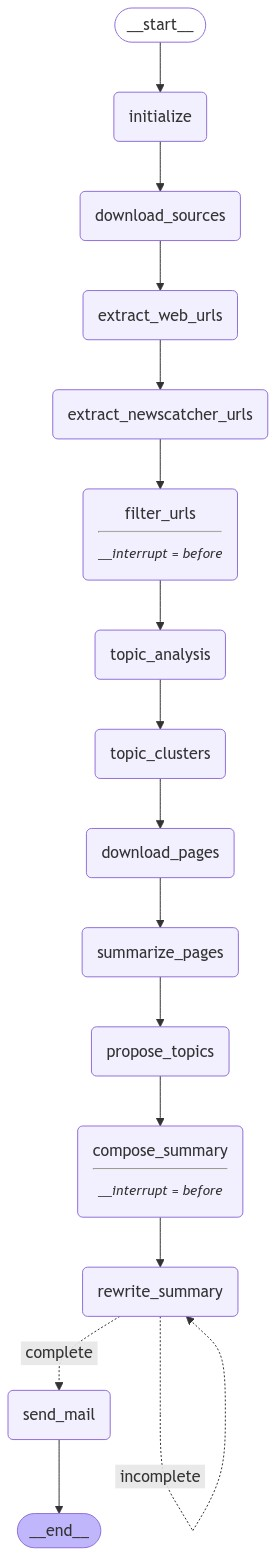

In [57]:
# Image(lg_agent.graph.get_graph().draw_png())
Image(lg_agent.app.get_graph().draw_mermaid_png())


In [ ]:
do_download = True
before_date = None
# before_date="2024-07-22 10:00:00"


In [ ]:
# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}
# initial state
state = AgentState()
state["before_date"] = before_date
state["do_download"] = do_download
log(f"Starting with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")


In [ ]:
state = lg_agent.run(state, config)

In [ ]:
state.items()

In [ ]:
user_approval = input("Edit topics? (yes/no): ")


In [ ]:
if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in lg_agent.graph.stream(None, config, stream_mode="debug"):
        if step["type"] == "checkpoint":
            display(f'Step {step["step"]}')
else:
    print("Operation cancelled by user.")


In [ ]:
# get last state
last_state = lg_agent.graph.get_state(config)
pd.DataFrame(last_state.values['AIdf'])


In [ ]:
# update state as node
# lg_agent.graph.update_state(config, {"foo": 2, "bar": ["b"]}, as_node="revise_summary")


In [ ]:
# resume from error starting at a node
# result = lg_agent.graph.invoke(None, {'configurable': {'thread_id': 'newsbot-thread-5'}, "next": "topic_analysis"})

In [ ]:
# Import packages
# Default packages
import time
import csv
import os
import json


# Preinstalled packages
import requests
import pandas


In [ ]:
# URL of our News API
base_url = 'https://api.newscatcherapi.com/v2/search'

